In [107]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
import glob
import pickle
hostname = os.uname()

In [108]:
data_path = "./PickledData/*"

print(f"ls of {data_path}:")
print(sorted(glob.glob(data_path)))

ls of ./PickledData/*:
['./PickledData/DoSpaceTrigger_Data_Batchb01_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb02_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb03_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb04_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb05_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb06_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb07_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb08_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb09_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb10_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb11_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb12_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb13_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb14_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb15_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb16_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb17_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb18_low.pkl', './P

In [109]:
data_path = "./PickledData/*"
all_files = sorted(glob.glob(data_path))


# if len(all_files) == 0:
#     print("No files found in the current data path, trying alternative paths...")
#     if 'tycho' in hostname or 'tycho' in hostname.nodename:
#         data_path = "/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/*"
#     if 'tedtop' in hostname:
#         data_path = "/home/fedor-tairli/work/CDEs/Data/Processed/CDE_100_Isolation_PickledData/*"
#     all_files = sorted(glob.glob(data_path))

print(f'Found {len(all_files)} files')
print(all_files)



Found 45 files
['./PickledData/DoSpaceTrigger_Data_Batchb01_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb02_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb03_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb04_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb05_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb06_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb07_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb08_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb09_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb10_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb11_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb12_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb13_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb14_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb15_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb16_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb17_low.pkl', './PickledData/DoSpaceTrigger_Data_Batchb18_low.pkl', './PickledDa

In [110]:
# Now lets do stats

Rec_Trigger_Duration = []
Myy_Trigger_Duration = []

Rec_Trigger_Multiplicity = []
Myy_Trigger_Multiplicity = []

Rec_Trigger_Traces = []
Myy_Trigger_Traces = []

Gen_LogE = []
Gen_Xmax = []
Gen_Chi0 = []
Gen_Rp   = []
Gen_Primary = []
Gen_EventClass = []
Gen_Cherenkov_Fraction = []

Batches_to_collect = all_files[0:3]

for batch in Batches_to_collect:
    print(f'Processing {batch}')
    with open(batch, 'rb') as f:
        batch_data = pickle.load(f)
    for Event in batch_data:
        Rec_Trigger = Event['PixelData']['RecTrigger']
        Myy_Trigger = Event['MyyTrigger']

        # Duration
        triggered_positions_Rec = np.where(Rec_Trigger)[1]
        if triggered_positions_Rec.size > 0:
            duration_Rec = triggered_positions_Rec.max() - triggered_positions_Rec.min() + 1
        else:
            duration_Rec = 0
        Rec_Trigger_Duration.append(duration_Rec)

        triggered_positions_Myy = np.where(Myy_Trigger)[1]
        if triggered_positions_Myy.size > 0:
            duration_Myy = triggered_positions_Myy.max() - triggered_positions_Myy.min() + 1
        else:
            duration_Myy = 0
        Myy_Trigger_Duration.append(duration_Myy)

        # Multiplicity
        multiplicity_Rec = np.sum(np.any(Rec_Trigger, axis=1))
        Rec_Trigger_Multiplicity.append(multiplicity_Rec)

        multiplicity_Myy = np.sum(np.any(Myy_Trigger, axis=1))
        Myy_Trigger_Multiplicity.append(multiplicity_Myy)

        # Traces - sum over time bins where pixels are triggered
        Event_Rec_Trace = []
        Event_Start = triggered_positions_Rec.min() if triggered_positions_Rec.size > 0 else 0
        Event_End   = triggered_positions_Rec.max() + 1 if triggered_positions_Rec.size > 0 else 0

        for t in range(Event_Start, Event_End):
            pixels_triggered_at_t = np.where(Rec_Trigger[:, t])[0]
            trace_at_t = np.sum(Event['PixelData']['Trace'][pixels_triggered_at_t,t]) if pixels_triggered_at_t.size > 0 else 0
            Event_Rec_Trace.append(trace_at_t)
        Event_Rec_Trace = np.array(Event_Rec_Trace)
        Rec_Trigger_Traces.append(Event_Rec_Trace)
        
        Event_Myy_Trace = []
        Event_Start = triggered_positions_Myy.min() if triggered_positions_Myy.size > 0 else 0
        Event_End   = triggered_positions_Myy.max() + 1 if triggered_positions_Myy.size > 0 else 0
        for t in range(Event_Start, Event_End):
            pixels_triggered_at_t = np.where(Myy_Trigger[:, t])[0]
            trace_at_t = np.sum(Event['PixelData']['Trace'][pixels_triggered_at_t,t]) if pixels_triggered_at_t.size > 0 else 0
            Event_Myy_Trace.append(trace_at_t)
        Event_Myy_Trace = np.array(Event_Myy_Trace)
        Myy_Trigger_Traces.append(Event_Myy_Trace)



        # Gen info
        Gen_LogE.append(Event['Gen_LogE'])
        Gen_Xmax.append(Event['Gen_Xmax'])
        Gen_Chi0.append(Event['Gen_Chi0'])
        Gen_Rp.append(Event['Gen_Rp'])
        Gen_Primary.append(Event['Gen_Primary'])
        Gen_EventClass.append(Event['EventClass'])
        Gen_Cherenkov_Fraction.append(Event['Gen_CherenkovFraction'])




Rec_Trigger_Duration = np.array(Rec_Trigger_Duration)
Myy_Trigger_Duration = np.array(Myy_Trigger_Duration)

Rec_Trigger_Multiplicity = np.array(Rec_Trigger_Multiplicity)
Myy_Trigger_Multiplicity = np.array(Myy_Trigger_Multiplicity)

Gen_LogE = np.array(Gen_LogE)
Gen_Xmax = np.array(Gen_Xmax)
Gen_Chi0 = np.array(Gen_Chi0)
Gen_Rp   = np.array(Gen_Rp)
Gen_Primary = np.array(Gen_Primary)
Gen_EventClass = np.array(Gen_EventClass)
Gen_Cherenkov_Fraction = np.array(Gen_Cherenkov_Fraction)

# Traces must remain in lists, cuase they are different lengths

    

Processing ./PickledData/DoSpaceTrigger_Data_Batchb01_low.pkl


/remote/tychodata/ftairli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Processing ./PickledData/DoSpaceTrigger_Data_Batchb02_low.pkl
Processing ./PickledData/DoSpaceTrigger_Data_Batchb03_low.pkl


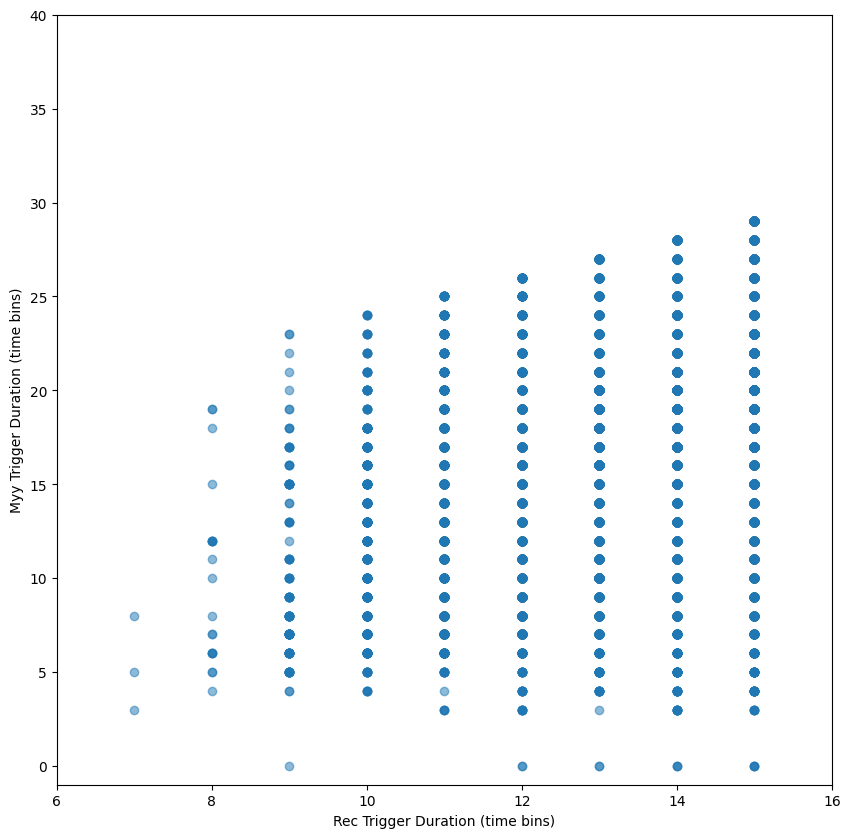

In [111]:
plt.figure(figsize = [10,10])
plt.scatter(Rec_Trigger_Duration, Myy_Trigger_Duration, alpha=0.5)
plt.xlabel('Rec Trigger Duration (time bins)')
plt.ylabel('Myy Trigger Duration (time bins)')
plt.xlim(6,16)
plt.ylim(-1,40)
plt.show()

Text(0, 0.5, 'Myy Trigger Multiplicity / Rec Trigger Multiplicity')

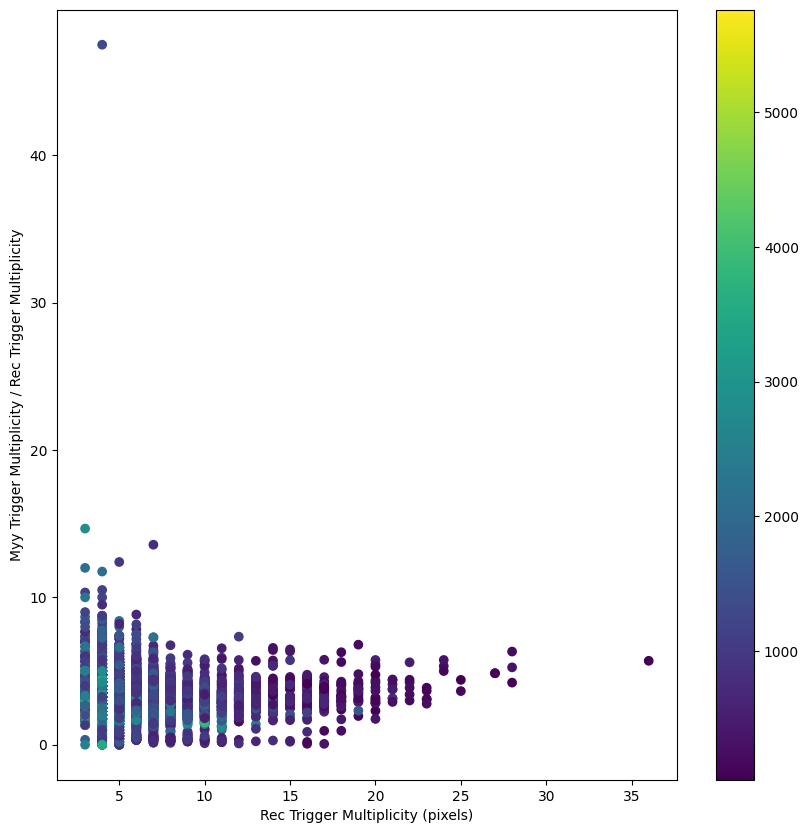

In [112]:

plt.figure(figsize = [10,10])
safe_plot_mask = Rec_Trigger_Multiplicity > 0
plt.scatter(Rec_Trigger_Multiplicity[safe_plot_mask], Myy_Trigger_Multiplicity[safe_plot_mask]/Rec_Trigger_Multiplicity[safe_plot_mask],c = Gen_Rp[safe_plot_mask])
plt.colorbar()
plt.xlabel('Rec Trigger Multiplicity (pixels)')
plt.ylabel('Myy Trigger Multiplicity / Rec Trigger Multiplicity')


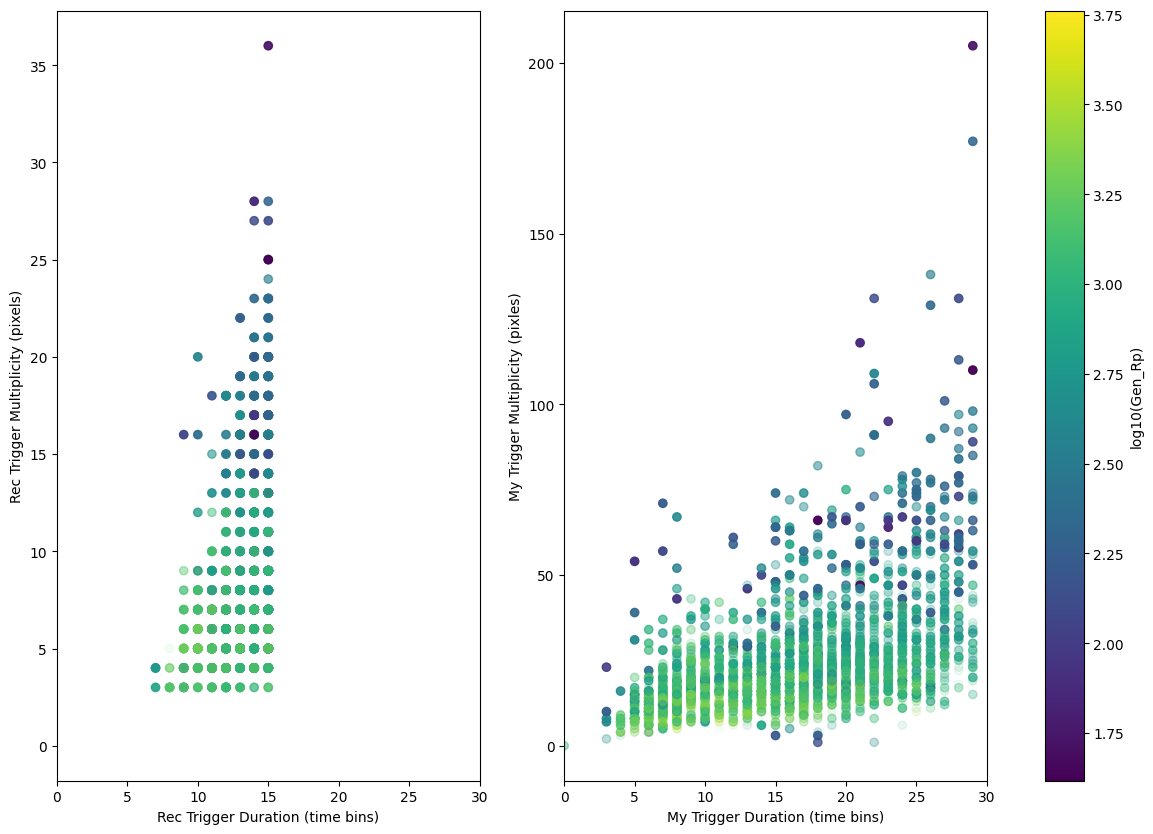

In [113]:
fig,ax = plt.subplots(1,2, figsize = [15,10])
CF_limit = 95
CF_scale = 100-CF_limit

Alpha = Gen_Cherenkov_Fraction-CF_limit
Alpha = np.clip(Alpha,0,CF_scale)/CF_scale

ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c = np.log10(Gen_Rp), alpha=Alpha)
ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c = np.log10(Gen_Rp), alpha=Alpha)
plt.colorbar(ax[1].collections[0], ax=ax, label='log10(Gen_Rp)')

ax[0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[1].set_xlabel('My Trigger Duration (time bins)')
ax[1].set_ylabel('My Trigger Multiplicity (pixles)')

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
plt.show()

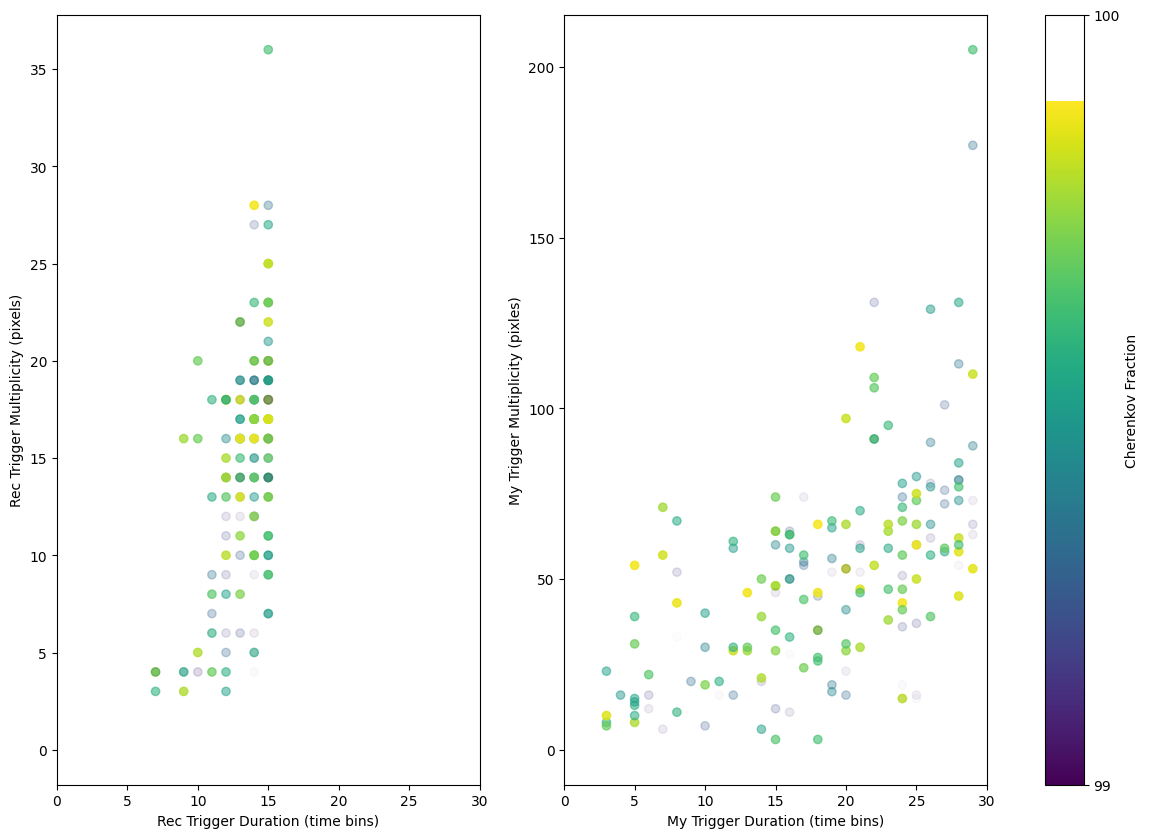

In [114]:
# fig,ax = plt.subplots(1,2, figsize = [15,10])
# CF_limit = 97
# CF_scale = 100-CF_limit

# Alpha = Gen_Cherenkov_Fraction-CF_limit
# Alpha = np.clip(Alpha,0,CF_scale)/CF_scale

# ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c = Alpha, alpha=Alpha)
# ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c = Alpha, alpha=Alpha)
# plt.colorbar(ax[1].collections[0], ax=ax, label='Cherenkov Fraction')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
CF_limit = 99
CF_scale = 100 - CF_limit

Alpha = Gen_Cherenkov_Fraction - CF_limit
Alpha = np.clip(Alpha, 0, CF_scale) / CF_scale

sc1 = ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c=Alpha, alpha=Alpha)
sc2 = ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c=Alpha, alpha=Alpha)
cbar = plt.colorbar(sc2, ax=ax, label='Cherenkov Fraction')

cbar.set_ticks([0, 1])
cbar.set_ticklabels([CF_limit, 100])


ax[0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[1].set_xlabel('My Trigger Duration (time bins)')
ax[1].set_ylabel('My Trigger Multiplicity (pixles)')

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
plt.show()

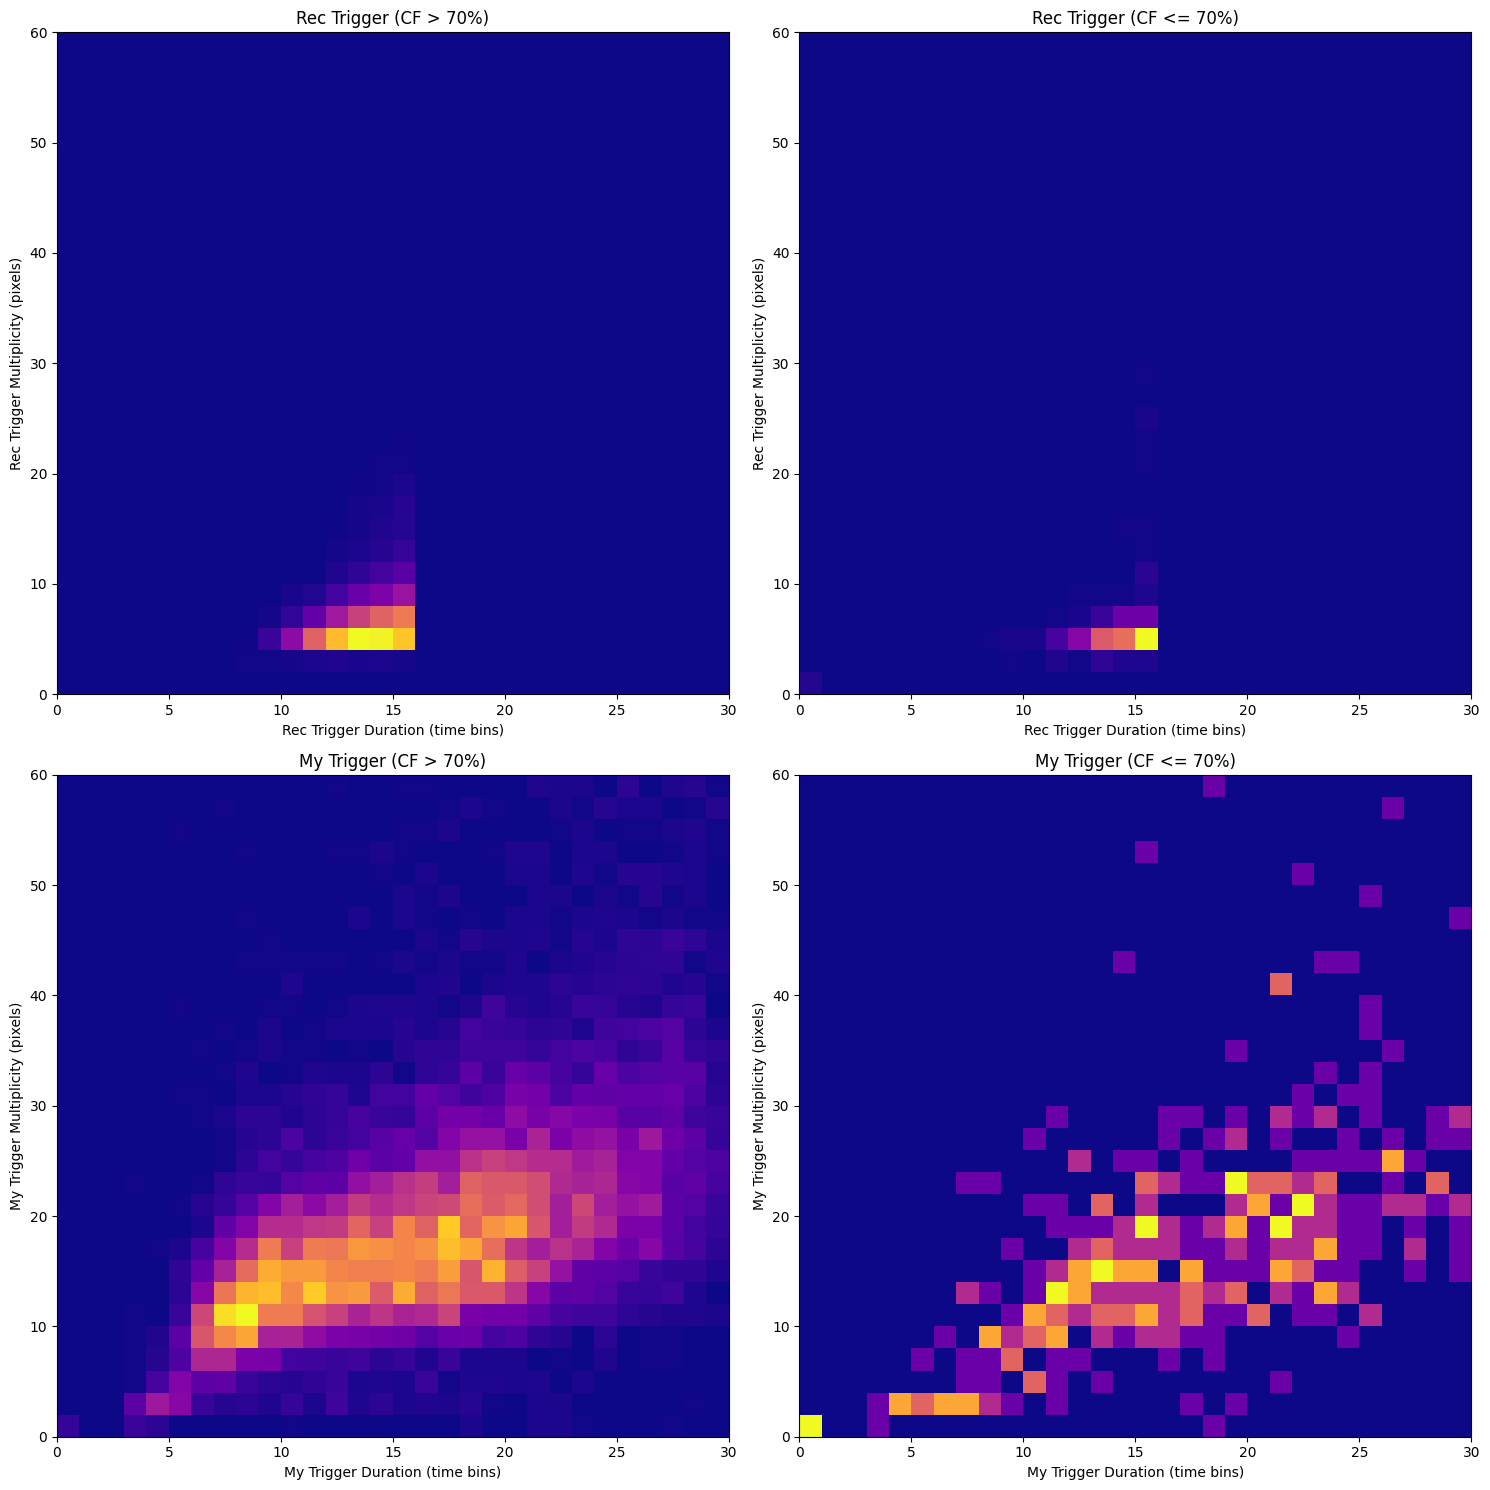

In [115]:
fig, ax = plt.subplots(2,2, figsize = [15,15])

CF_Cut = 70
Mask = Gen_Cherenkov_Fraction > CF_Cut

C = Gen_Cherenkov_Fraction

ax[0,0].hist2d(Rec_Trigger_Duration[Mask], Rec_Trigger_Multiplicity[Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[0,0].scatter(Rec_Trigger_Duration[Mask], Rec_Trigger_Multiplicity[Mask], c=Gen_Rp[Mask], cmap='plasma')
ax[0,0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0,0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[0,0].set_title(f'Rec Trigger (CF > {CF_Cut}%)')
ax[0,0].set_xlim(0,30)
ax[0,0].set_ylim(0,60)

ax[0,1].hist2d(Rec_Trigger_Duration[~Mask], Rec_Trigger_Multiplicity[~Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[0,1].scatter(Rec_Trigger_Duration[~Mask], Rec_Trigger_Multiplicity[~Mask], c=Gen_Rp[~Mask], cmap='plasma')
ax[0,1].set_xlabel('Rec Trigger Duration (time bins)')
ax[0,1].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[0,1].set_title(f'Rec Trigger (CF <= {CF_Cut}%)')
ax[0,1].set_xlim(0,30)
ax[0,1].set_ylim(0,60)

ax[1,0].hist2d(Myy_Trigger_Duration[Mask], Myy_Trigger_Multiplicity[Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[1,0].scatter(Myy_Trigger_Duration[Mask], Myy_Trigger_Multiplicity[Mask], c=Gen_Rp[Mask], cmap='plasma')
ax[1,0].set_xlabel('My Trigger Duration (time bins)')
ax[1,0].set_ylabel('My Trigger Multiplicity (pixels)')
ax[1,0].set_title(f'My Trigger (CF > {CF_Cut}%)')
ax[1,0].set_xlim(0,30)
ax[1,0].set_ylim(0,60)

ax[1,1].hist2d(Myy_Trigger_Duration[~Mask], Myy_Trigger_Multiplicity[~Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[1,1].scatter(Myy_Trigger_Duration[~Mask], Myy_Trigger_Multiplicity[~Mask], c=Gen_Rp[~Mask], cmap='plasma')
ax[1,1].set_xlabel('My Trigger Duration (time bins)')
ax[1,1].set_ylabel('My Trigger Multiplicity (pixels)')
ax[1,1].set_title(f'My Trigger (CF <= {CF_Cut}%)')
ax[1,1].set_xlim(0,30)
ax[1,1].set_ylim(0,60)
plt.tight_layout()
plt.show()

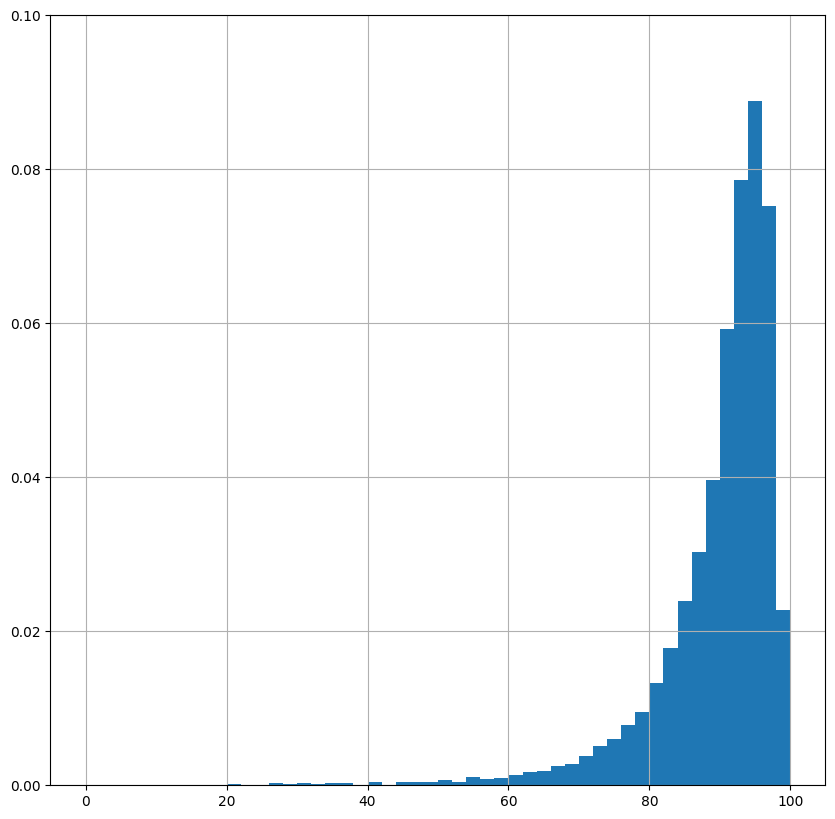

In [116]:
plt.figure(figsize = [10,10])
plt.hist(Gen_Cherenkov_Fraction, bins=50, range=[0,100],density=True)
plt.ylim(0,0.1)
plt.grid()

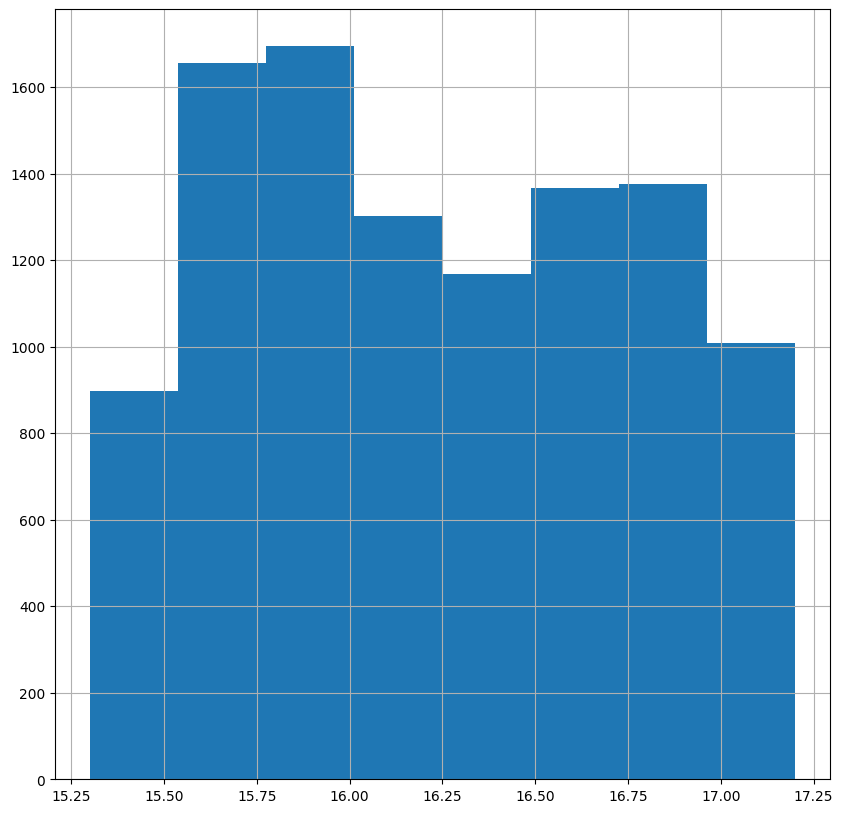

In [117]:
plt.figure(figsize = [10,10])
plt.hist(Gen_LogE, bins=8)
# plt.ylim(0,0.1)
plt.grid()

9712


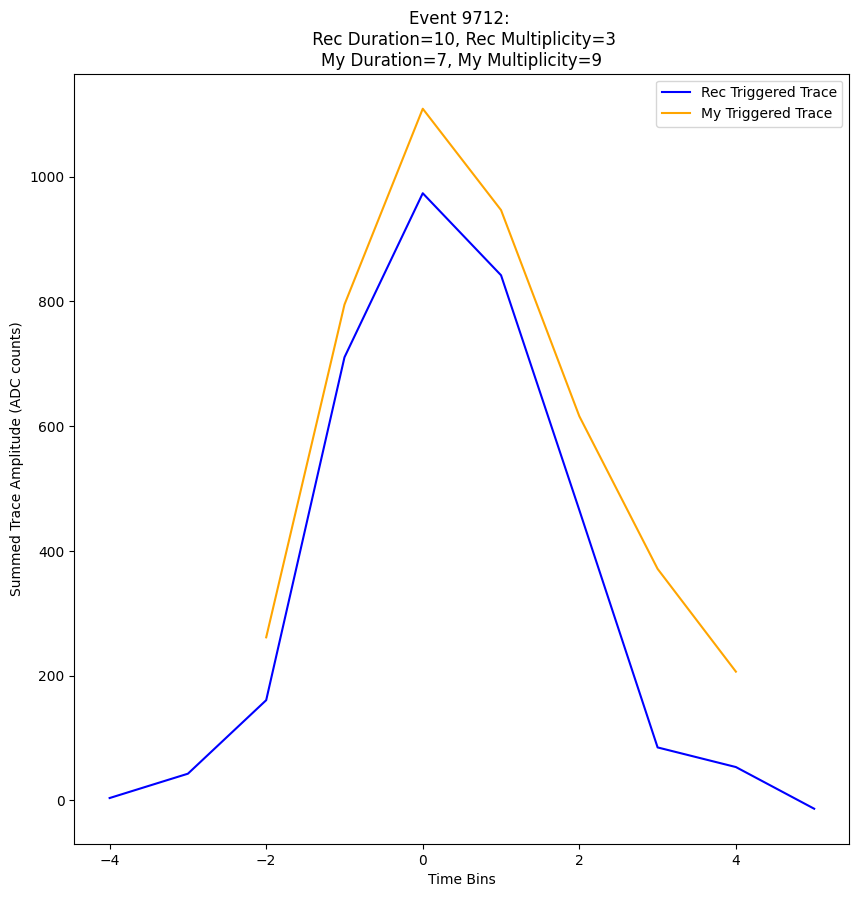

In [118]:
N = np.random.randint(0, len(Rec_Trigger_Traces))
print(N)

plt.figure(figsize = [10,10])

Rec_Trigger_Trace = Rec_Trigger_Traces[N]
Myy_Trigger_Trace = Myy_Trigger_Traces[N]

# Find the index of the maximum value
max_index_Rec = np.argmax(Rec_Trigger_Trace)
max_index_Myy = np.argmax(Myy_Trigger_Trace)

# Center the x values
x_values_Rec = np.arange(len(Rec_Trigger_Trace)) - max_index_Rec
x_values_Myy = np.arange(len(Myy_Trigger_Trace)) - max_index_Myy

plt.plot(x_values_Rec, Rec_Trigger_Trace, label='Rec Triggered Trace', color='blue')
plt.plot(x_values_Myy, Myy_Trigger_Trace, label='My Triggered Trace', color='orange')

plt.xlabel('Time Bins')
plt.ylabel('Summed Trace Amplitude (ADC counts)')
plt.title(f'Event {N}: \n Rec Duration={Rec_Trigger_Duration[N]}, Rec Multiplicity={Rec_Trigger_Multiplicity[N]}\nMy Duration={Myy_Trigger_Duration[N]}, My Multiplicity={Myy_Trigger_Multiplicity[N]}')
# plt.yscale('log')
plt.legend()

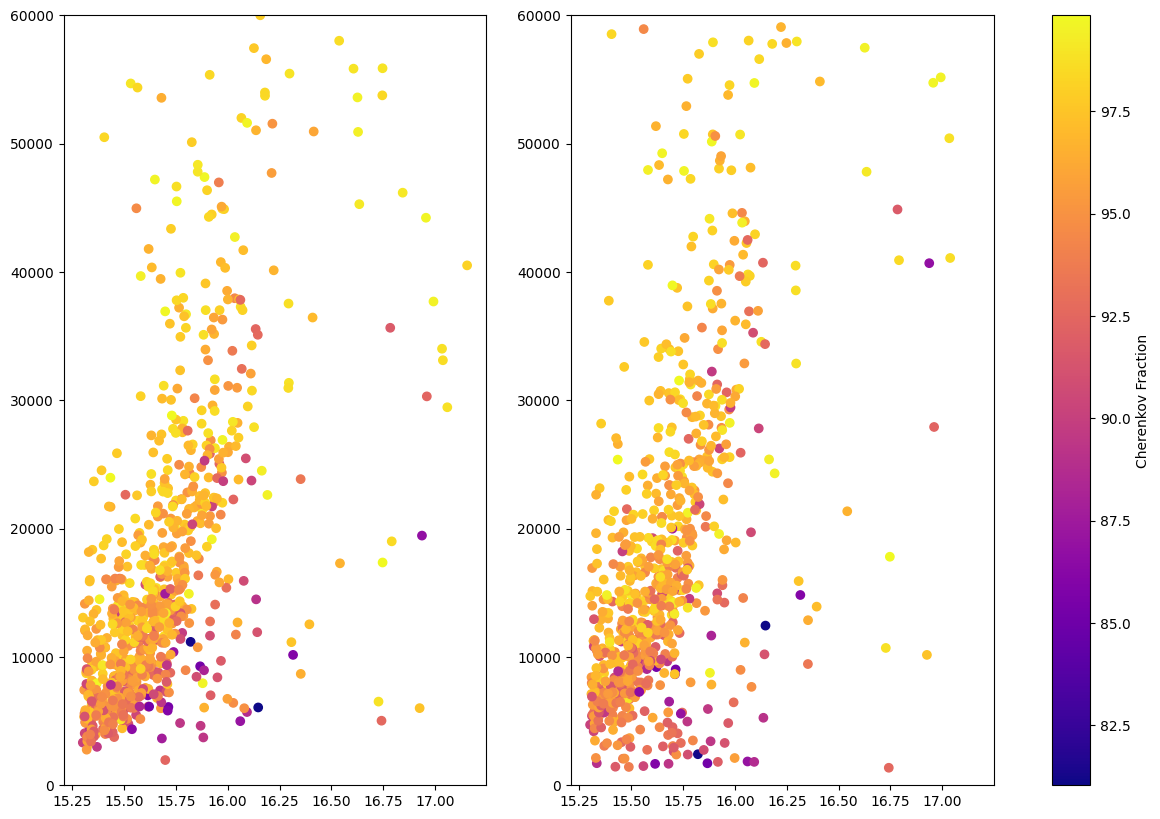

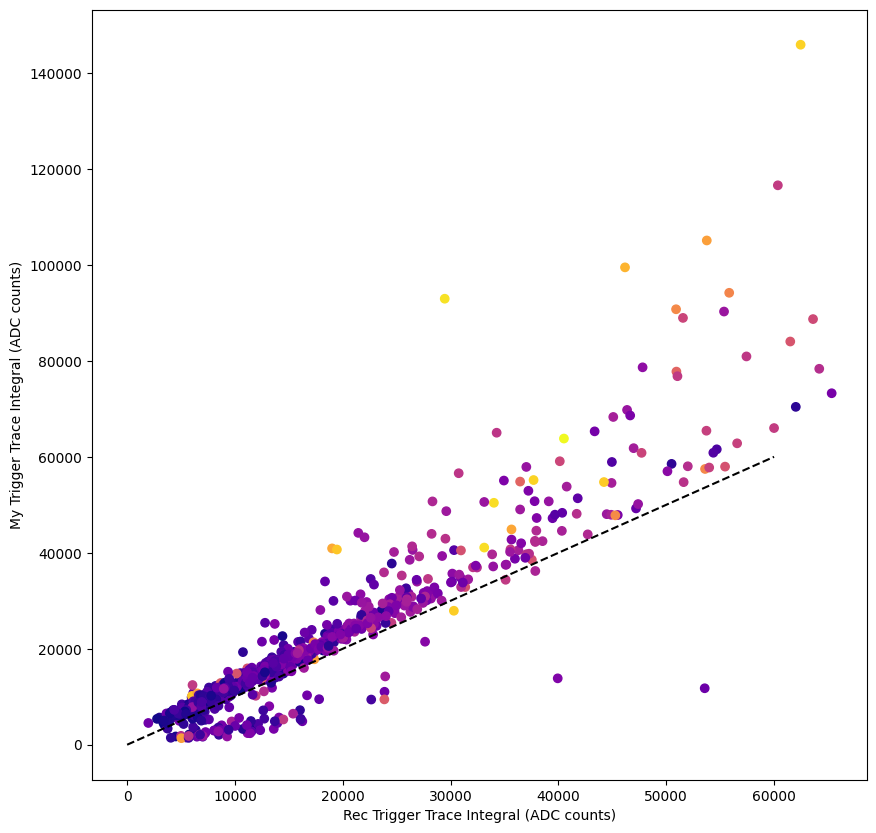

In [119]:
X = [np.sum(Rec_Trigger_Trace) for Rec_Trigger_Trace in Rec_Trigger_Traces]
Y = [np.sum(Myy_Trigger_Trace) for Myy_Trigger_Trace in Myy_Trigger_Traces]

Energy = Gen_LogE
cut = (Gen_Rp < 750) & (Gen_Cherenkov_Fraction > 80)

X = np.array(X)[cut]
Y = np.array(Y)[cut]
Energy = np.array(Energy)[cut]

fig, ax = plt.subplots(1,2, figsize = [15,10])



ax[0].scatter(Energy, X, c= Gen_Cherenkov_Fraction[cut], cmap='plasma')
ax[1].scatter(Energy, Y, c= Gen_Cherenkov_Fraction[cut], cmap='plasma')

plt.colorbar(ax[1].collections[0], ax=ax, label='Cherenkov Fraction')

ax[0].set_ylim(0,60000)
ax[1].set_ylim(0,60000)


plt.figure(figsize = [10,10])
plt.scatter(X,Y, c= Energy, cmap='plasma')
plt.xlabel('Rec Trigger Trace Integral (ADC counts)')
plt.ylabel('My Trigger Trace Integral (ADC counts)')

plt.plot([0, 60000], [0, 60000], color='black', linestyle='--')



#### Histograms of the triggered Signals in Pixels

In [120]:
with open(all_files[0], 'rb') as f:
    Example_Batch = pickle.load(f)

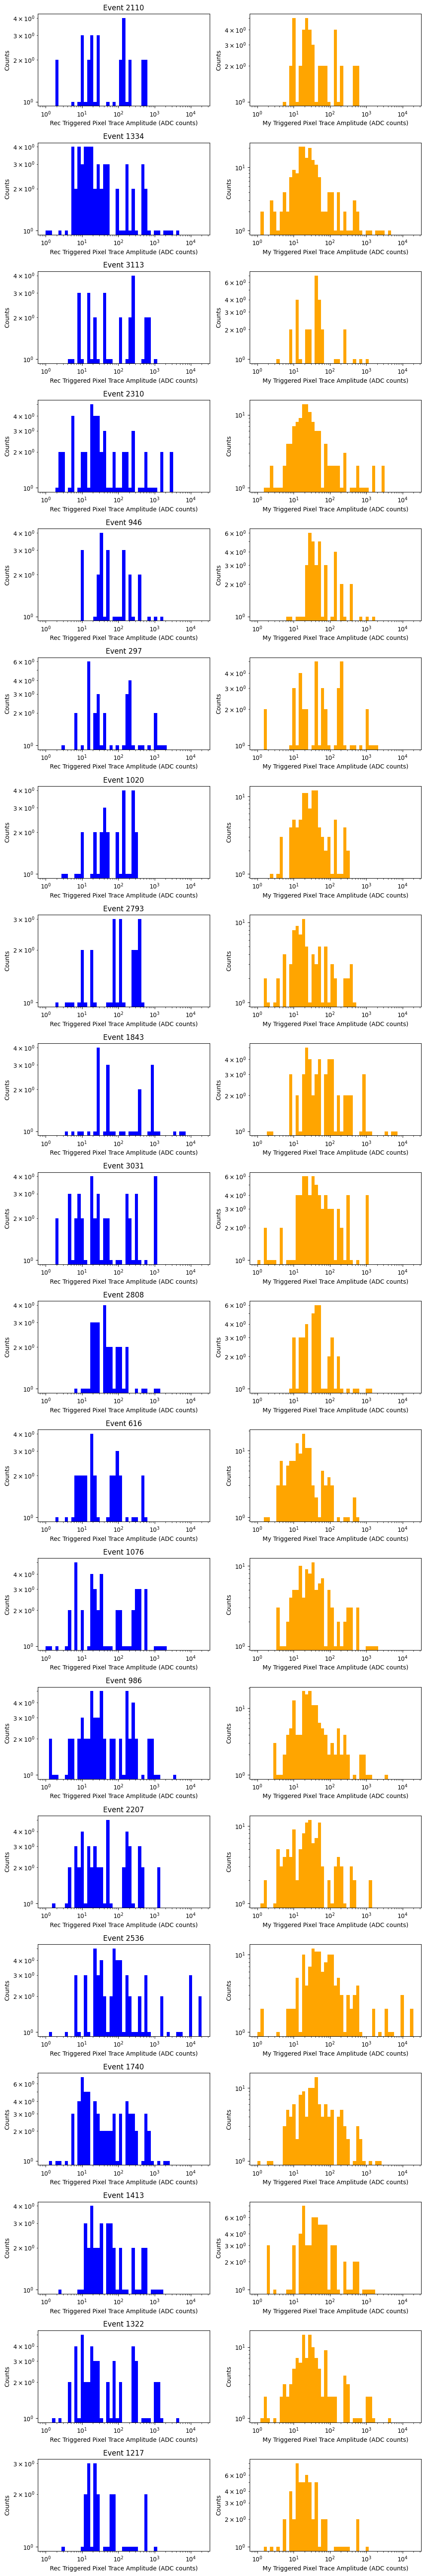

In [121]:
N_plots = 20

CF_Threshold = 95

fig, ax = plt.subplots(N_plots, 2, figsize = [10,3*N_plots])

for i in range(N_plots):
    CF_Fraction = 0 
    while CF_Fraction < CF_Threshold:
        Random_Event = np.random.randint(0, len(Example_Batch))
        Event = Example_Batch[Random_Event]
        CF_Fraction = Event['Gen_CherenkovFraction']


    Rec_Trigger = Event['PixelData']['RecTrigger']
    Myy_Trigger = Event['MyyTrigger']

    Trace = Event['PixelData']['Trace']

    Rec_Trigger_Trace = Trace[Rec_Trigger].flatten()
    Myy_Trigger_Trace = Trace[Myy_Trigger].flatten()

    bins = np.logspace(0,4.3, 50)

    ax[i,0].hist(Rec_Trigger_Trace, bins=bins, color= 'blue')
    ax[i,1].hist(Myy_Trigger_Trace, bins=bins, color= 'orange')
    ax[i,0].set_xscale('log')
    ax[i,1].set_xscale('log')
    ax[i,0].set_yscale('log')
    ax[i,1].set_yscale('log')
    ax[i,0].set_xlabel('Rec Triggered Pixel Trace Amplitude (ADC counts)')
    ax[i,1].set_xlabel('My Triggered Pixel Trace Amplitude (ADC counts)')
    ax[i,0].set_ylabel('Counts')
    ax[i,1].set_ylabel('Counts')
    ax[i,0].set_title(f'Event {Random_Event}')

plt.tight_layout()


    


#### Using Saturated Pixels to find high CF Events

In [122]:
with open(all_files[0], 'rb') as f:
    Example_Batch = pickle.load(f)

In [123]:
Example_Batch_Pruned = []

for Event in Example_Batch:
    Max_Signal_In_All_Trace = np.max(Event['PixelData']['Trace'])
    if Max_Signal_In_All_Trace > 15000:
        Example_Batch_Pruned.append(Event)
print(f'Pruned batch from {len(Example_Batch)} to {len(Example_Batch_Pruned)} events')

Pruned batch from 3495 to 47 events


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.05319149, 0.44680851]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  9

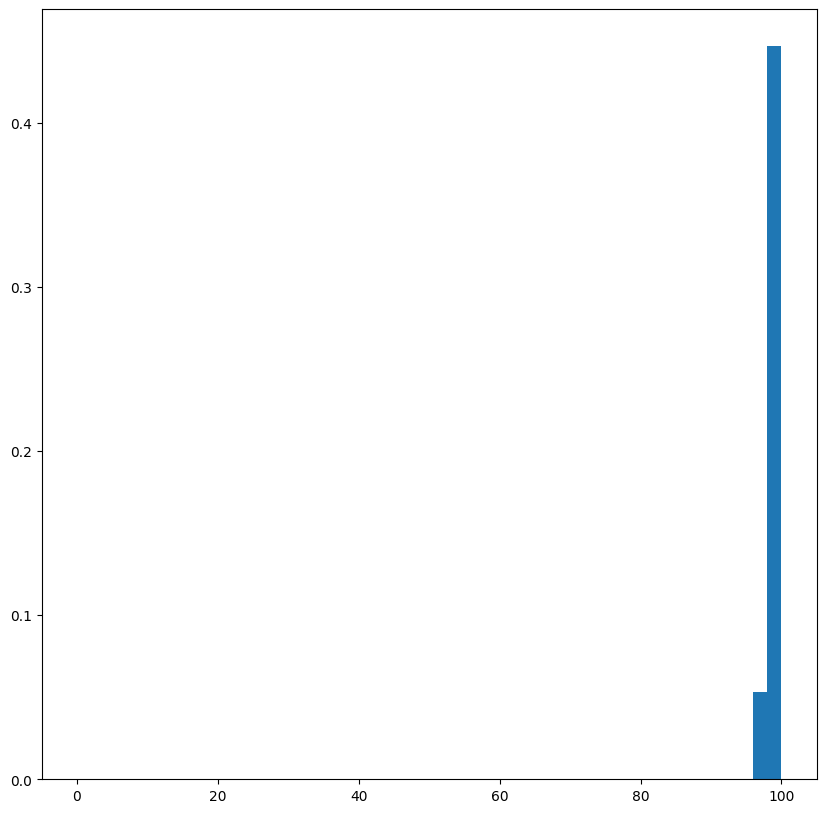

In [126]:
All_GeneChernkovFraction = []
for event in Example_Batch_Pruned:
    All_GeneChernkovFraction.append(event['Gen_CherenkovFraction'])

All_GeneChernkovFraction = np.array(All_GeneChernkovFraction)
plt.figure(figsize = [10,10])
plt.hist(All_GeneChernkovFraction, bins=50, range=[0,100],density=True)

/tmp/ipykernel_25115/4122436525.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,2, figsize = [18,10])


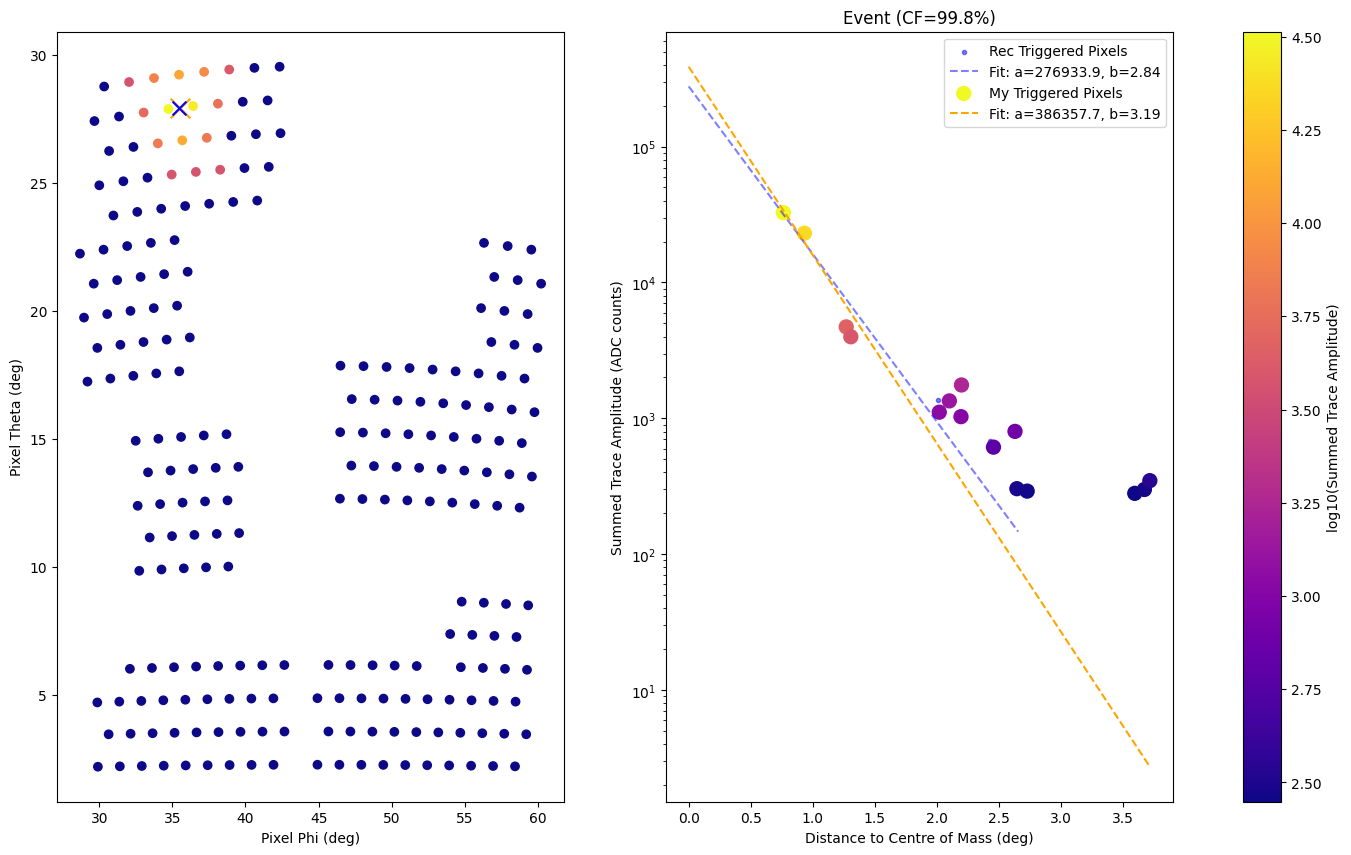

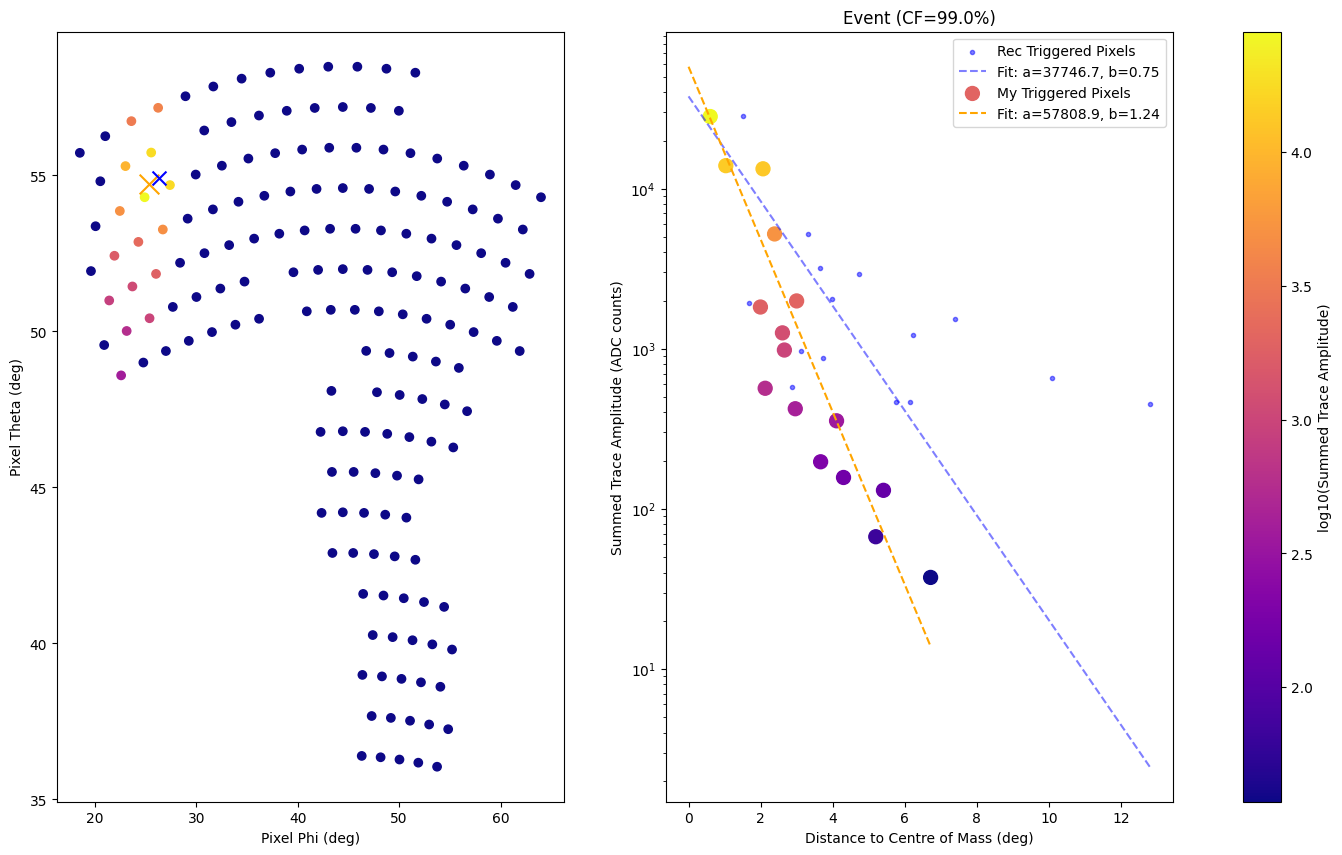

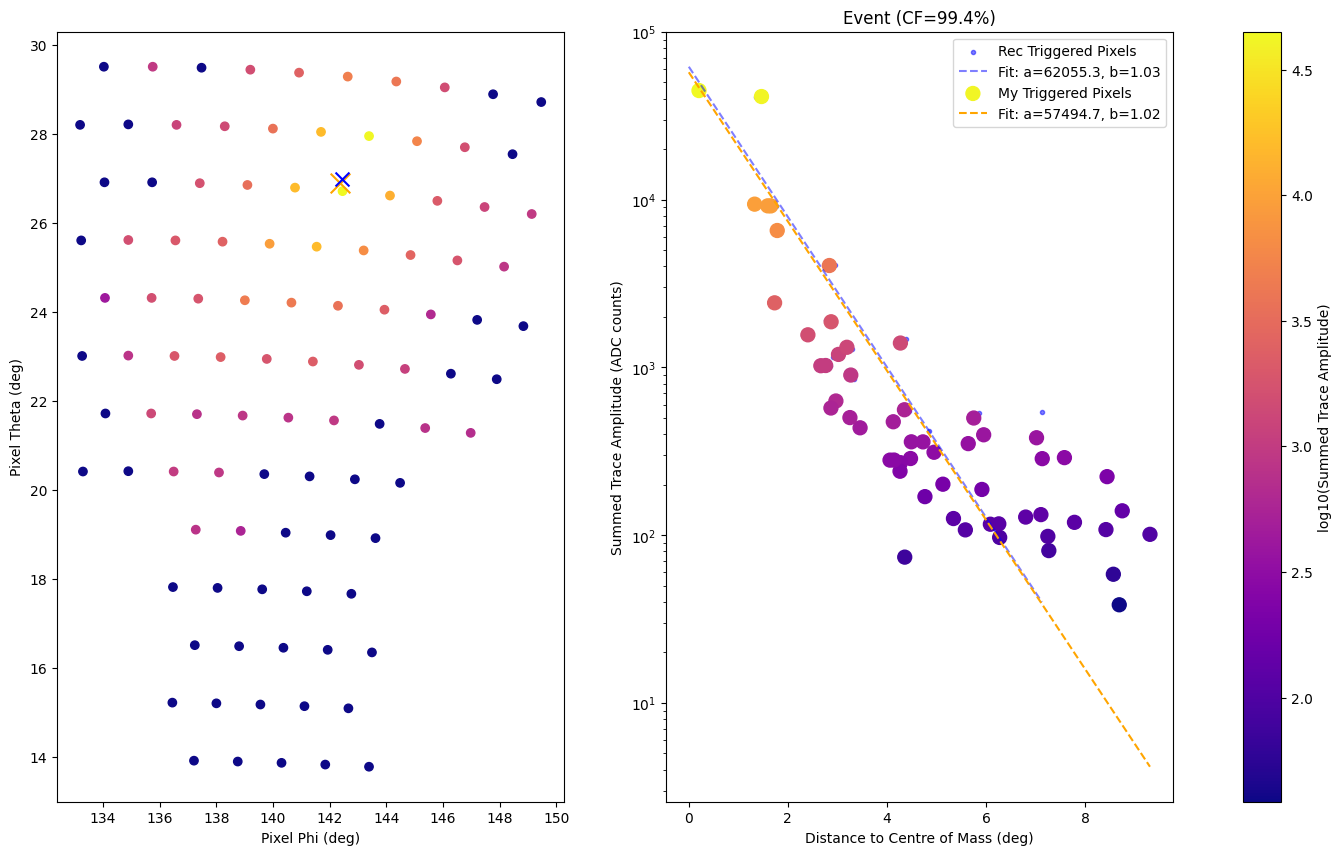

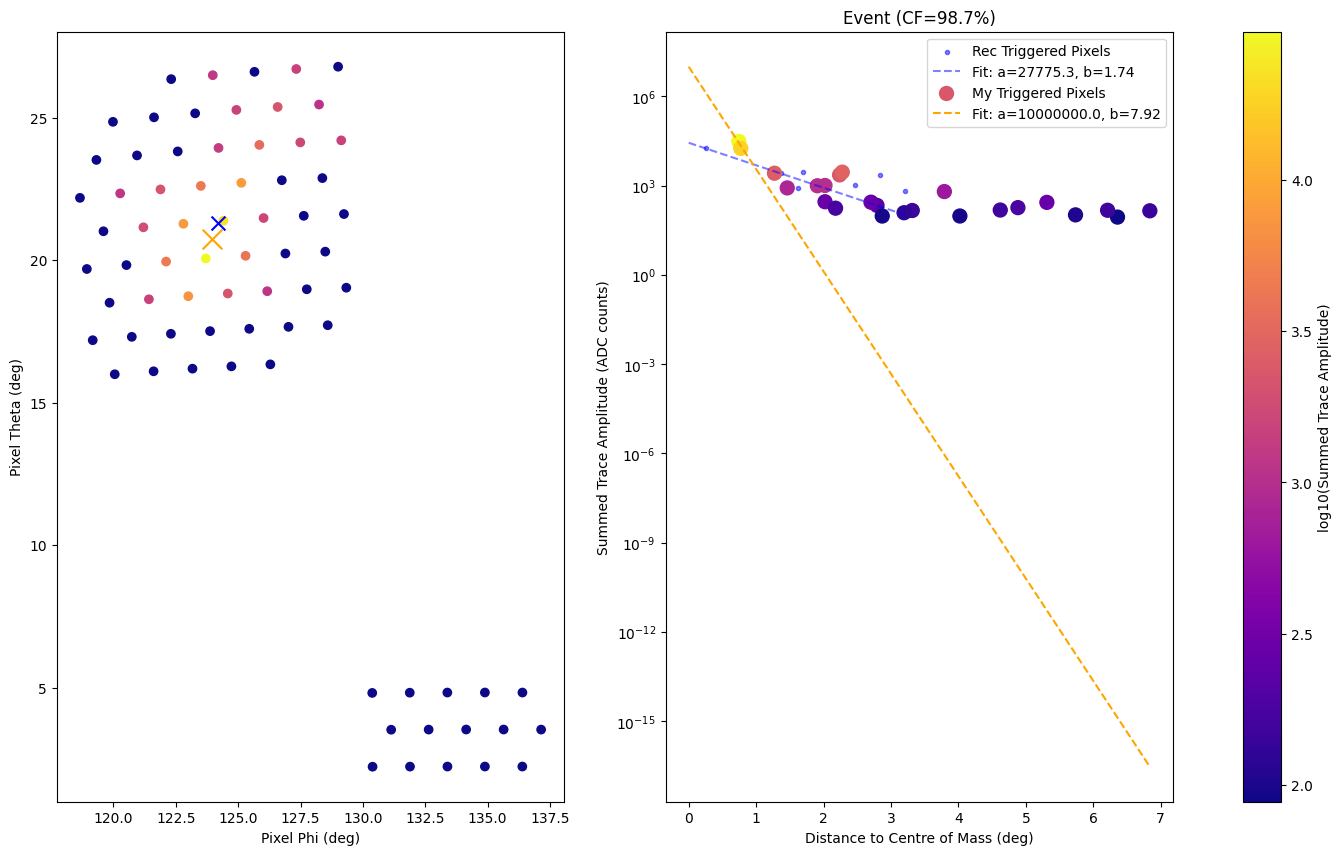

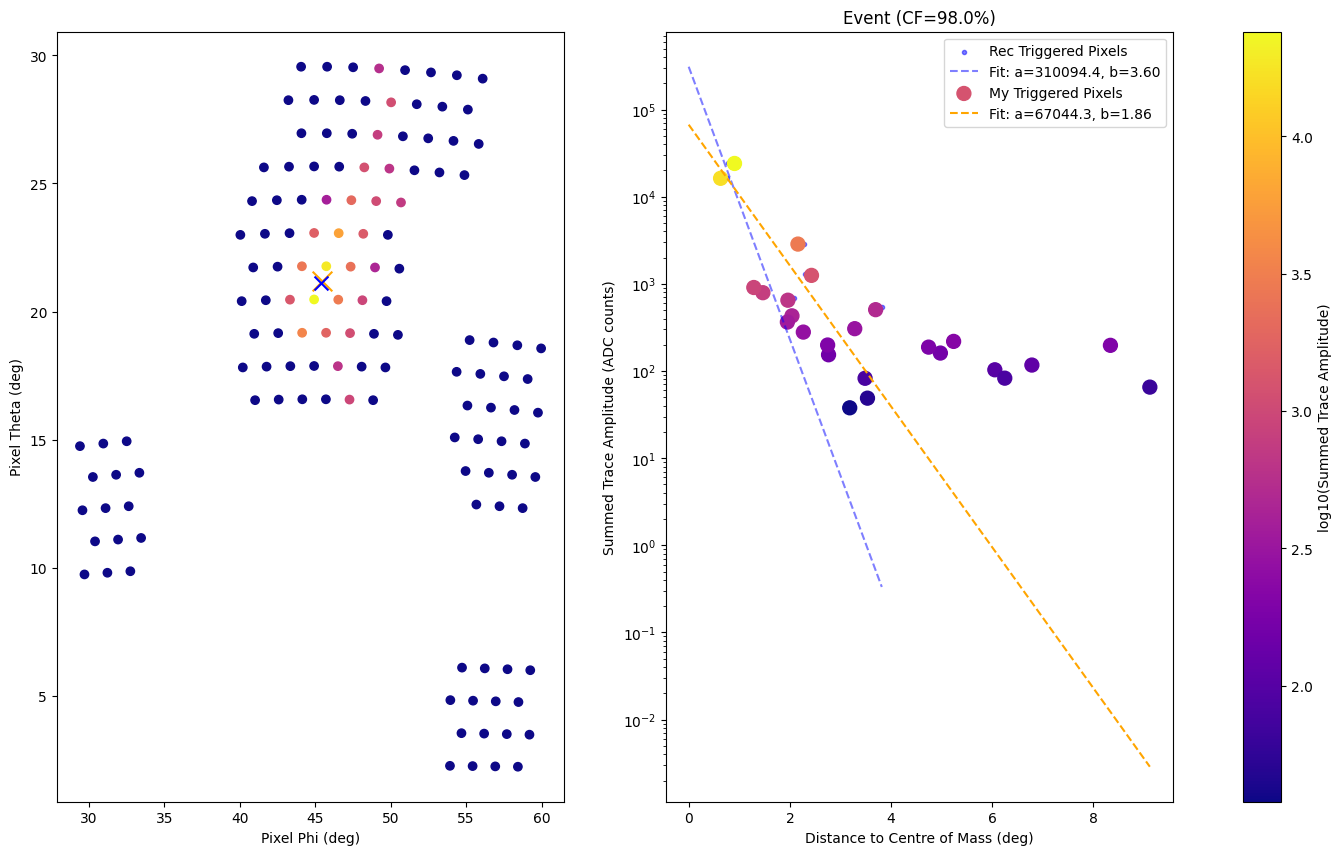

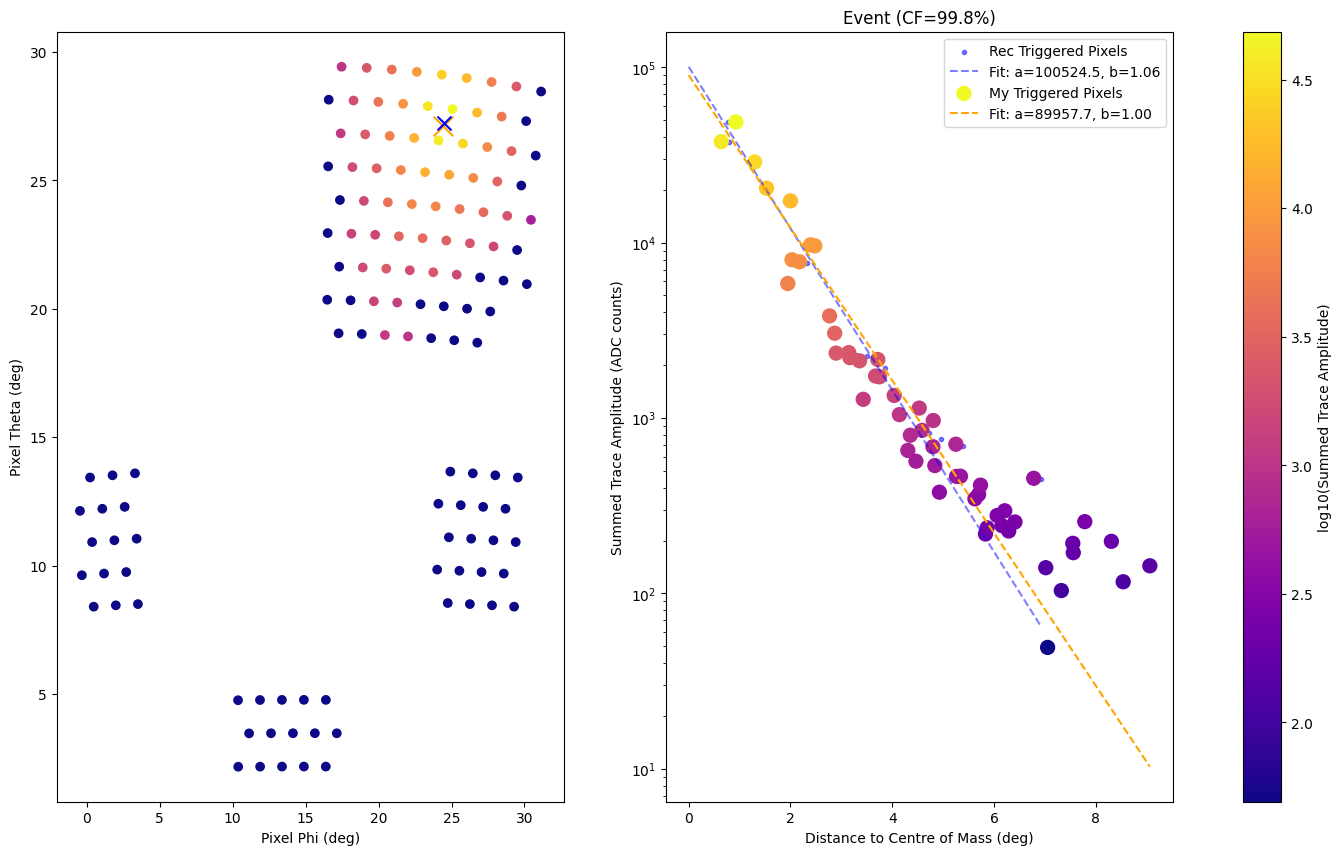

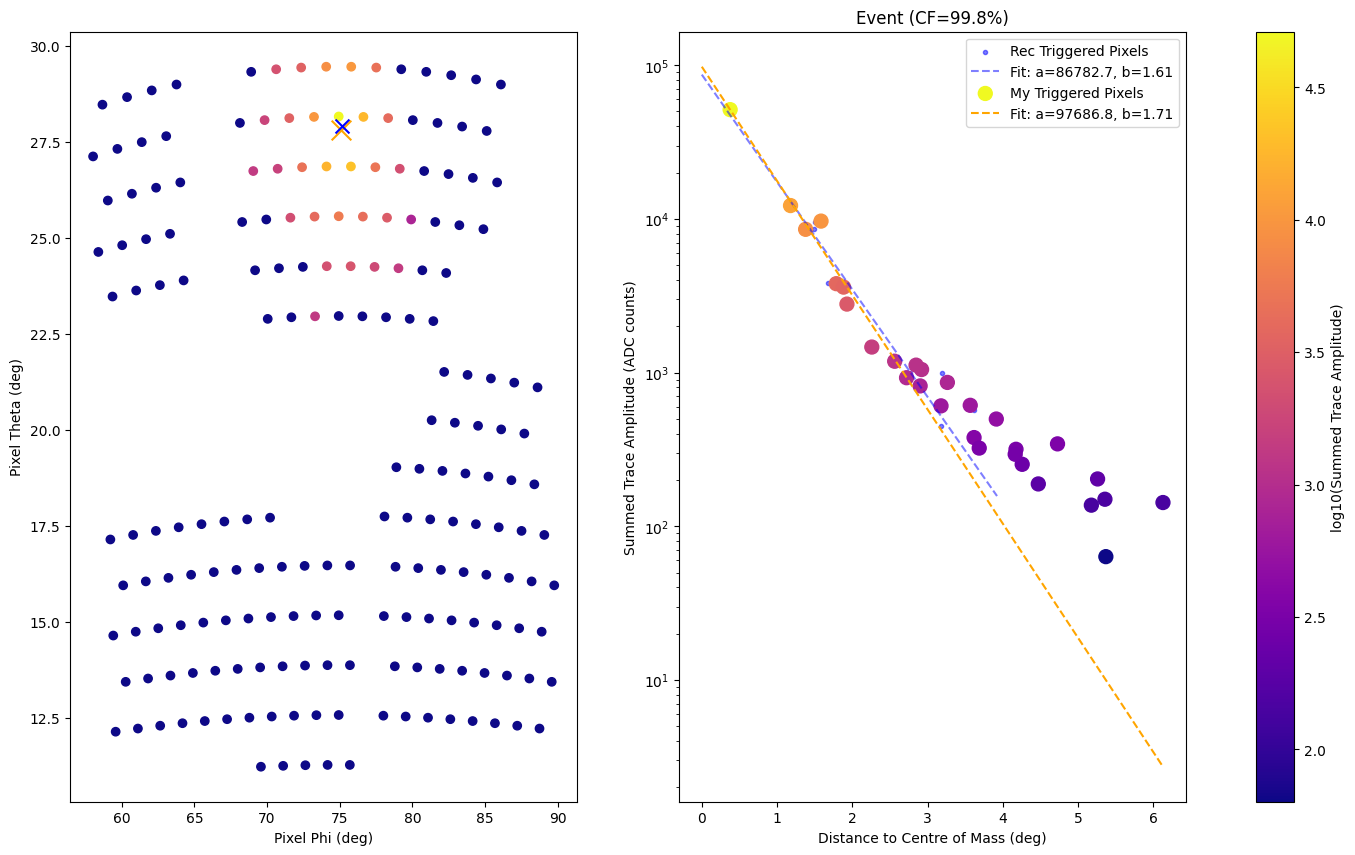

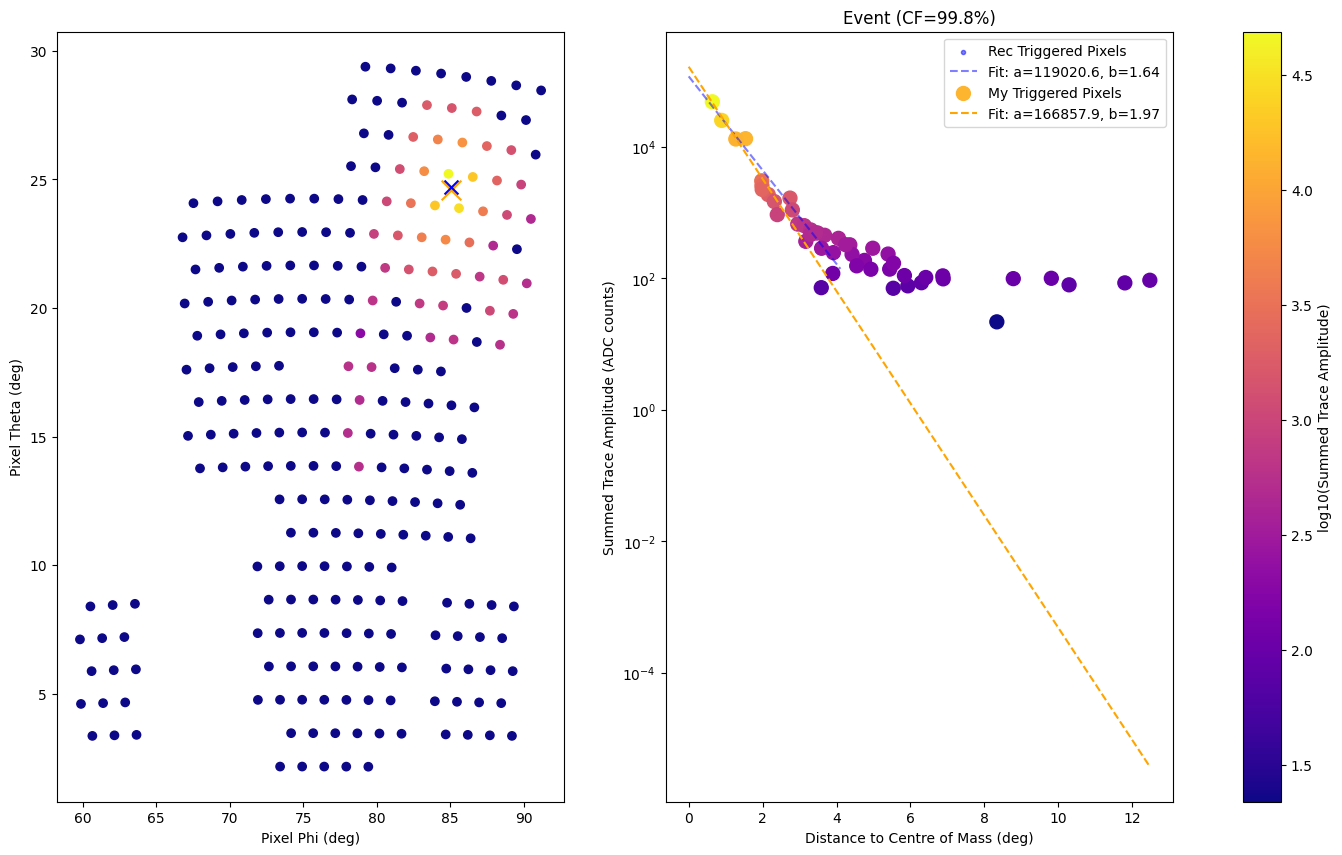

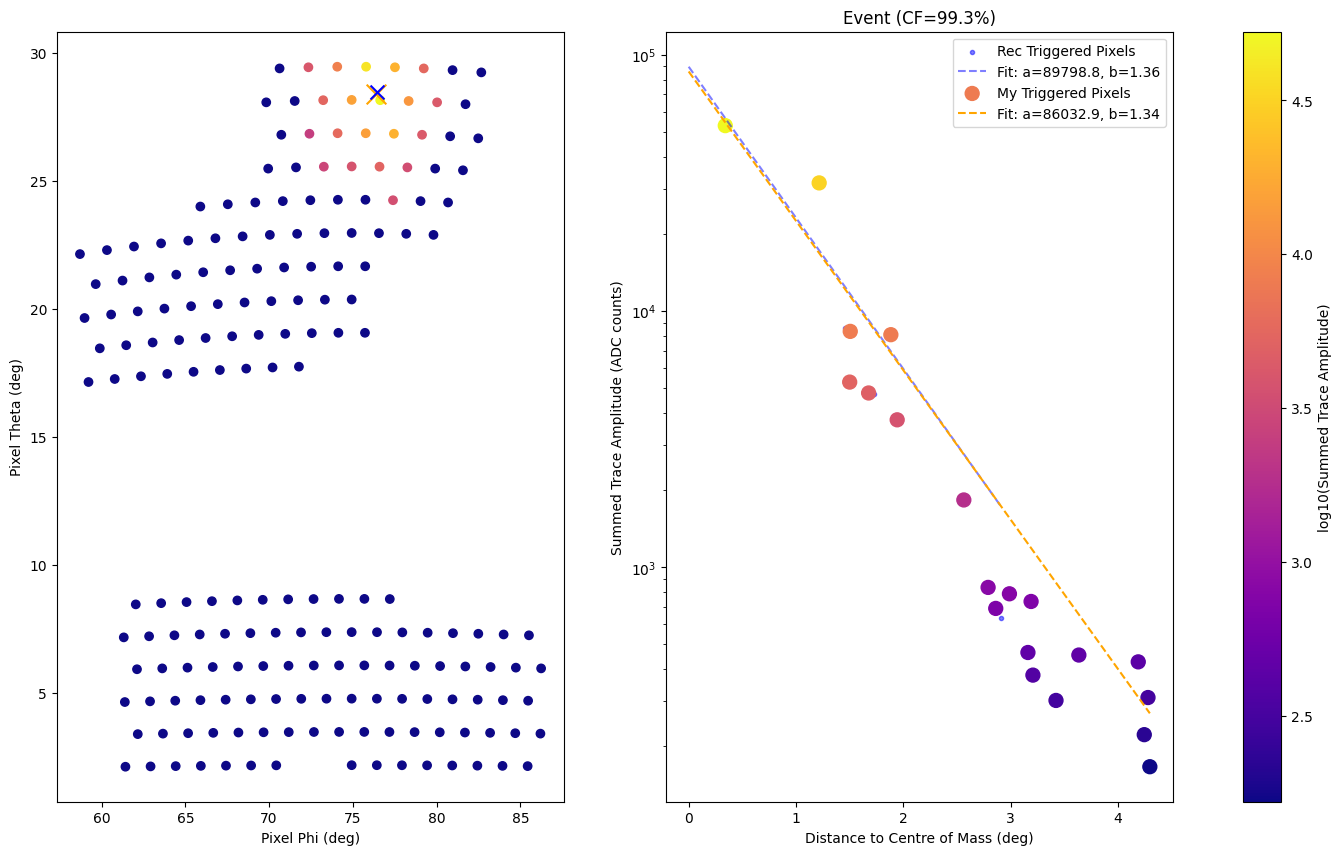

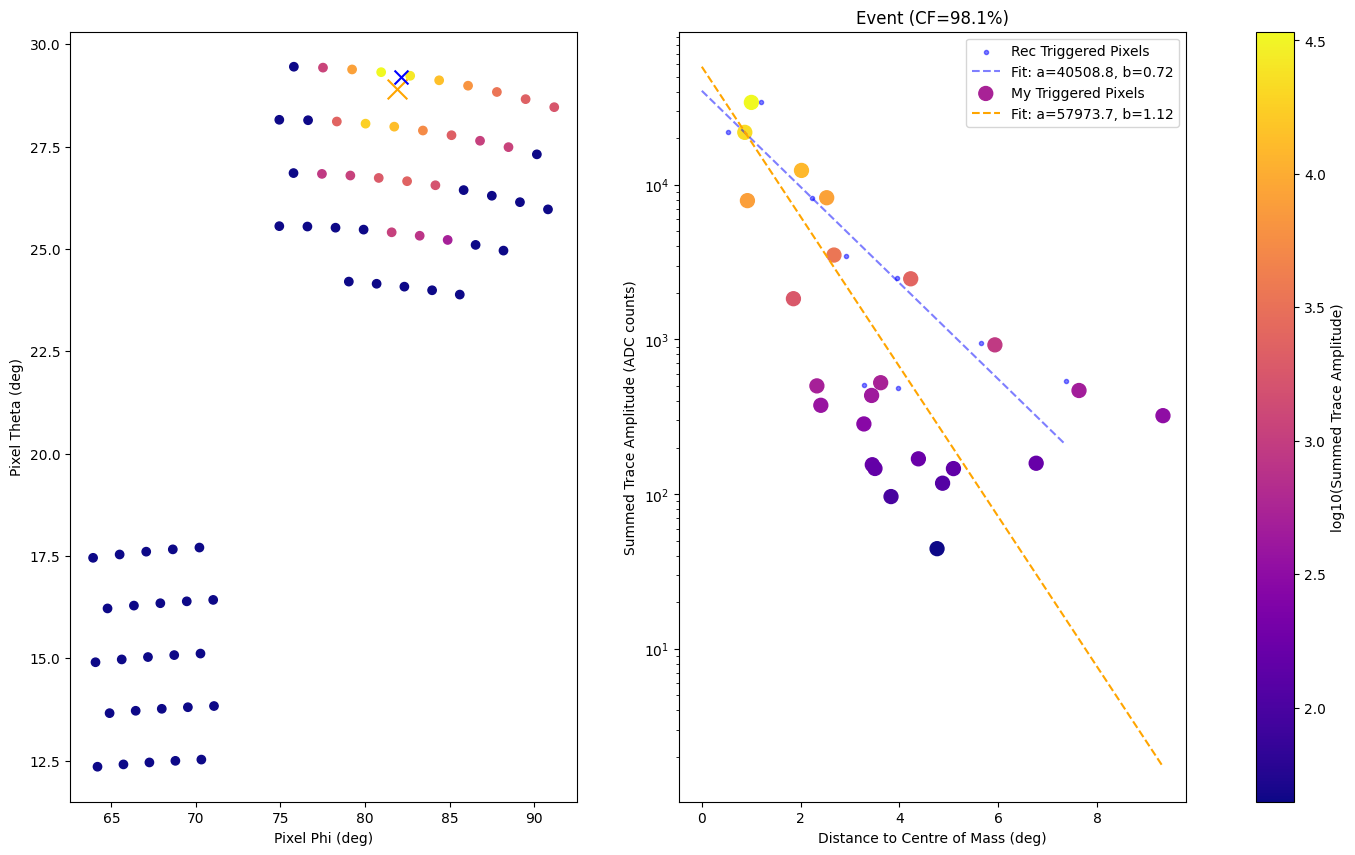

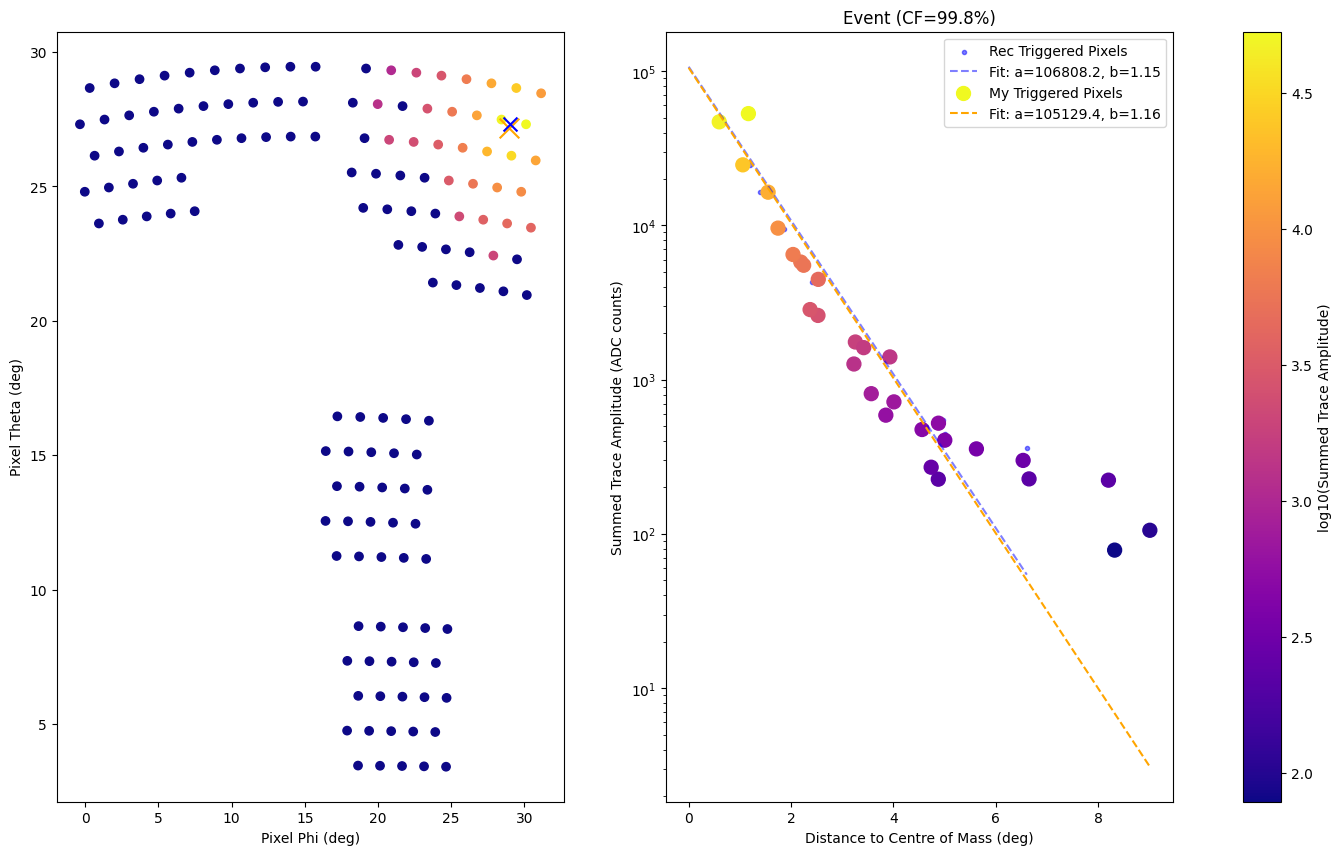

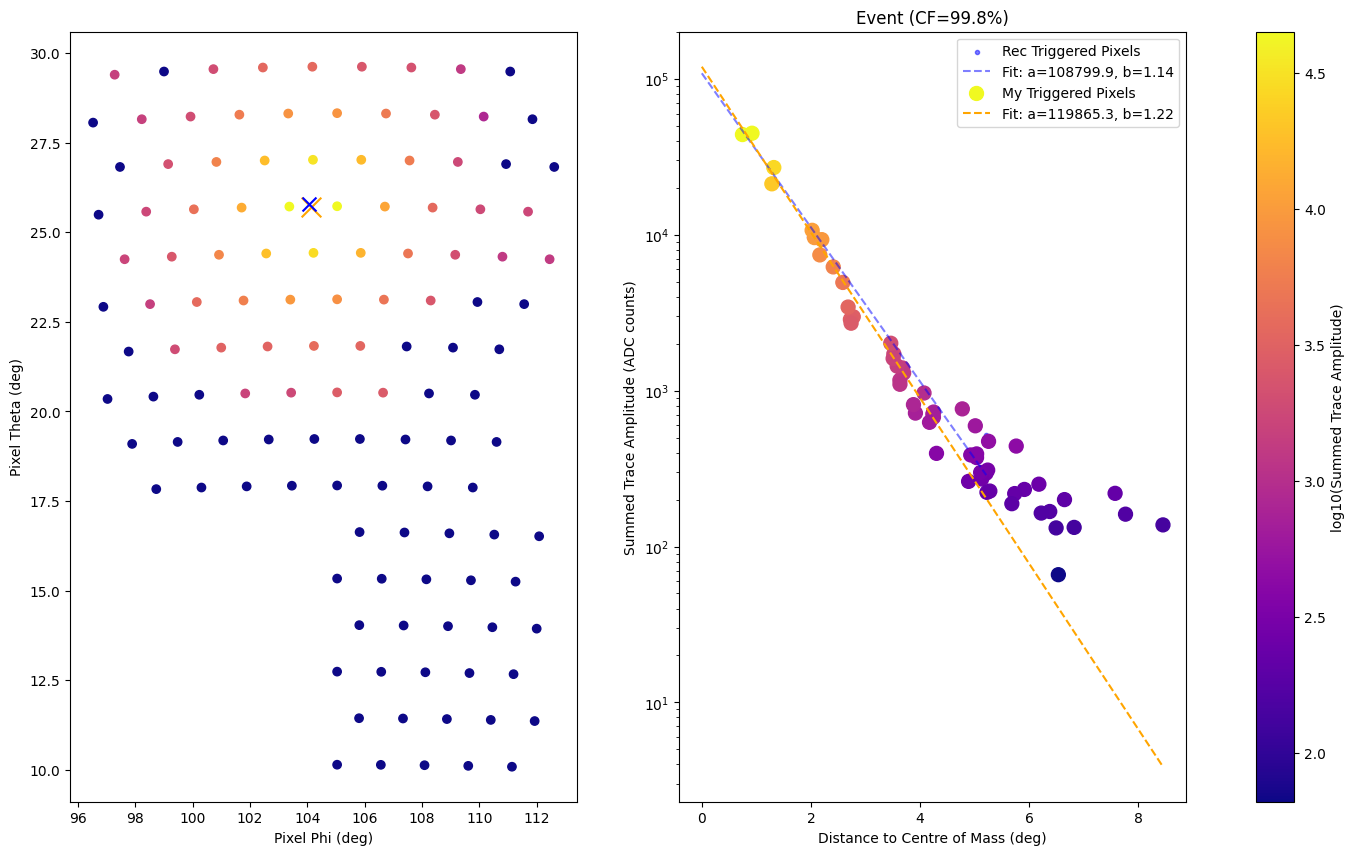

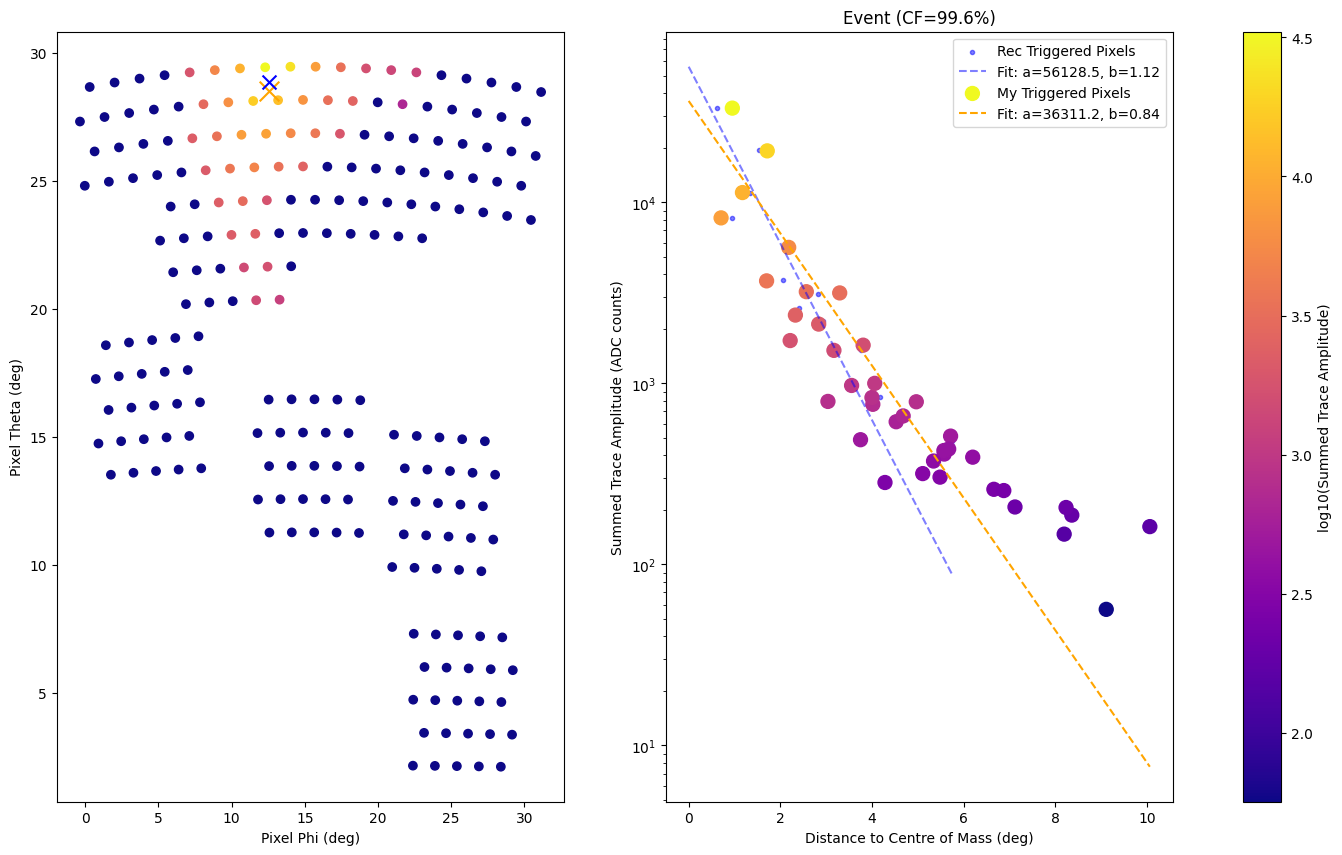

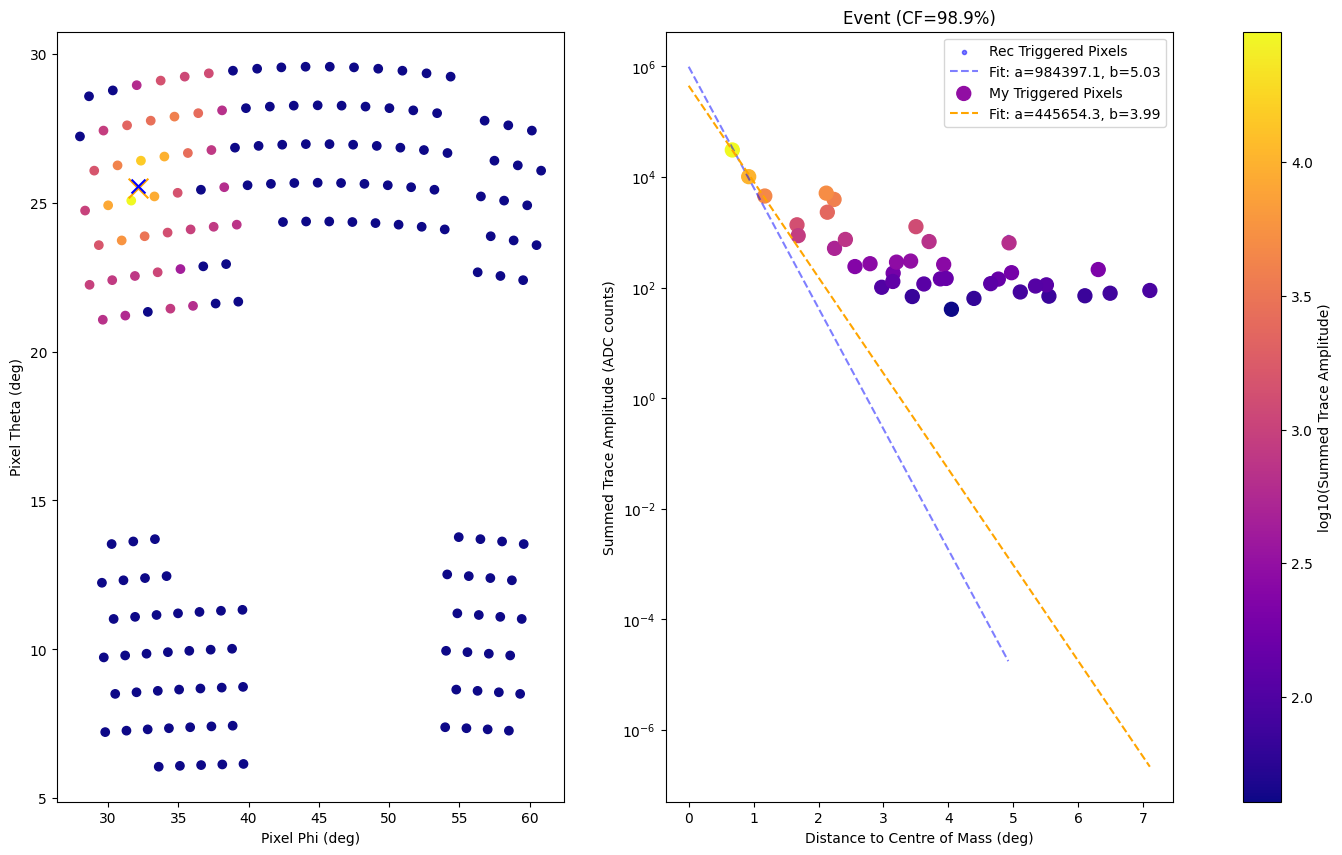

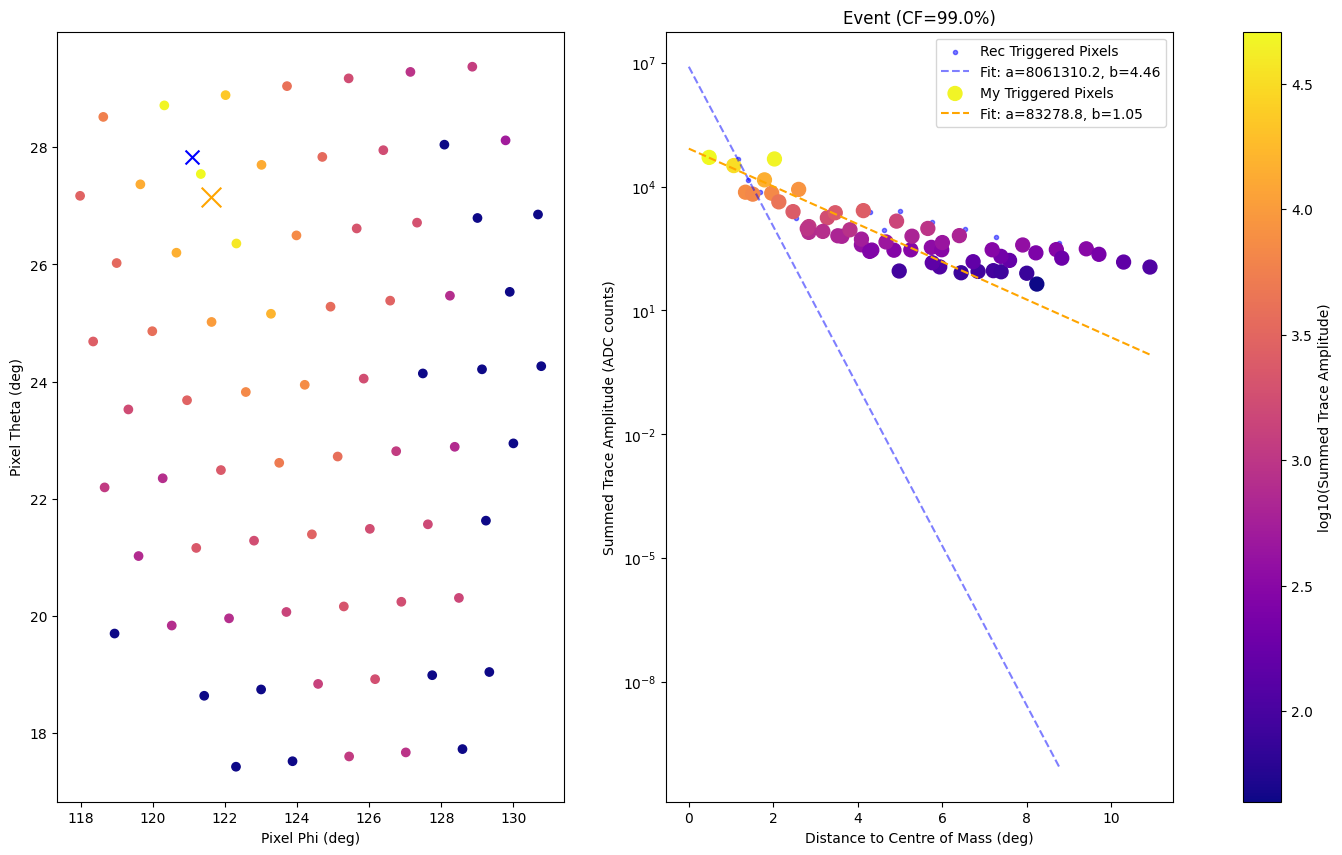

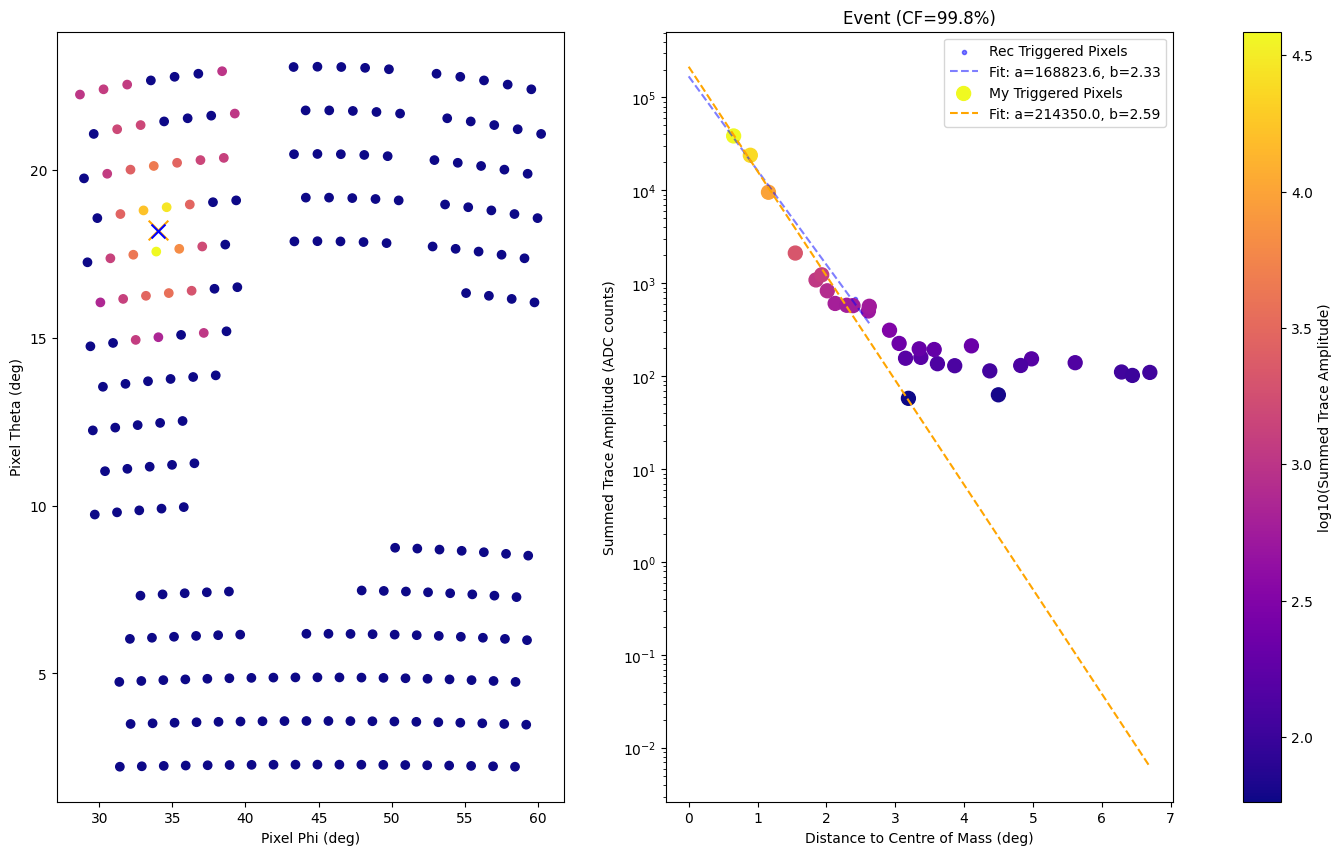

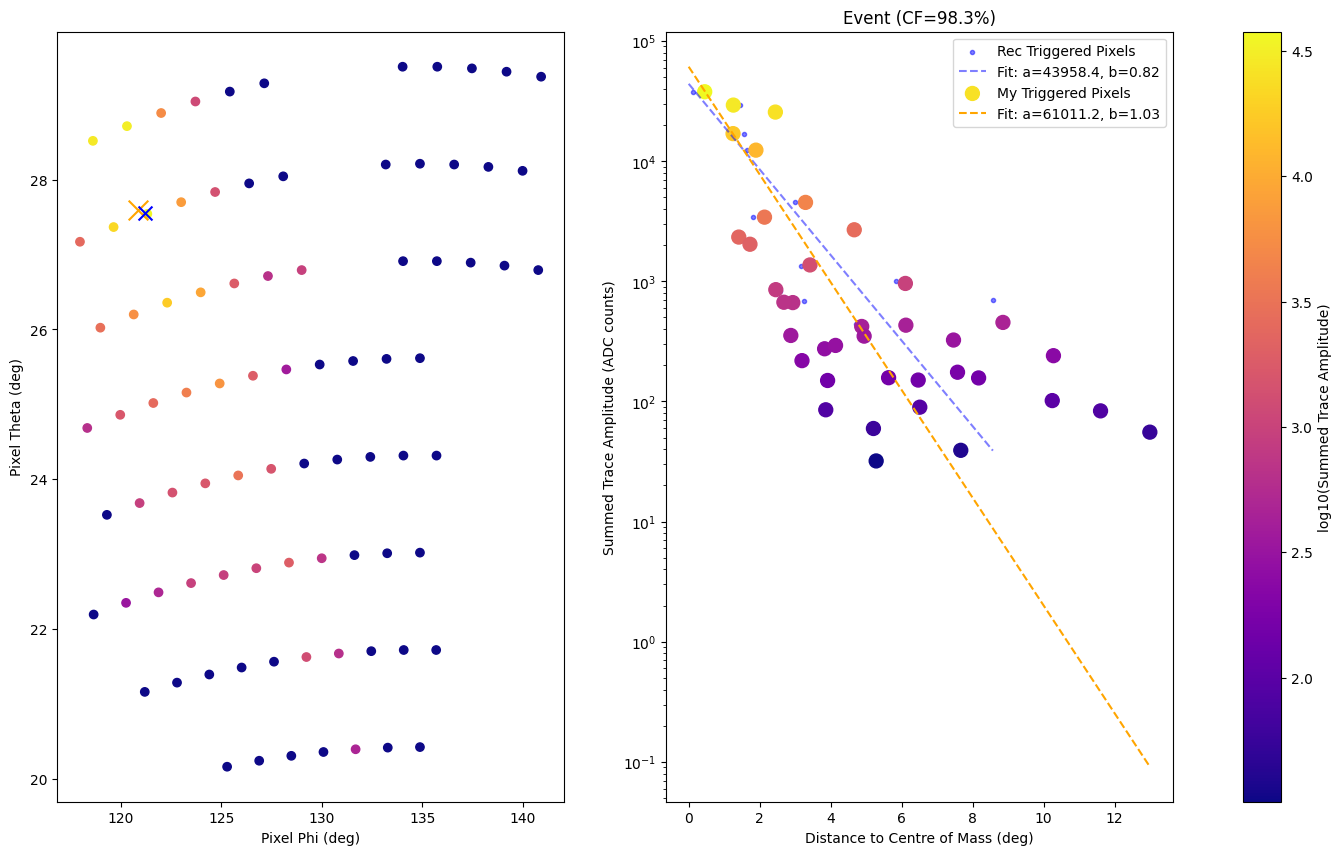

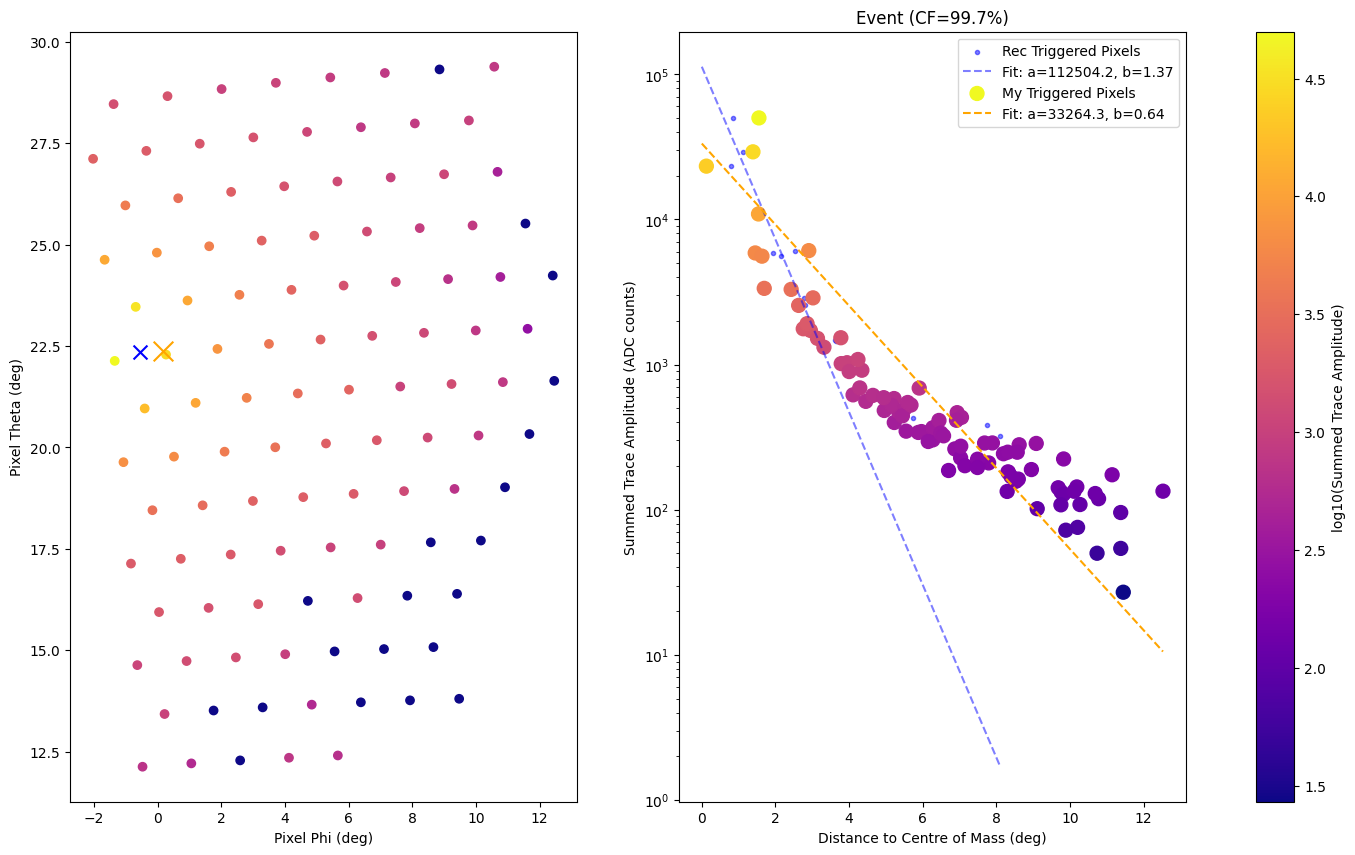

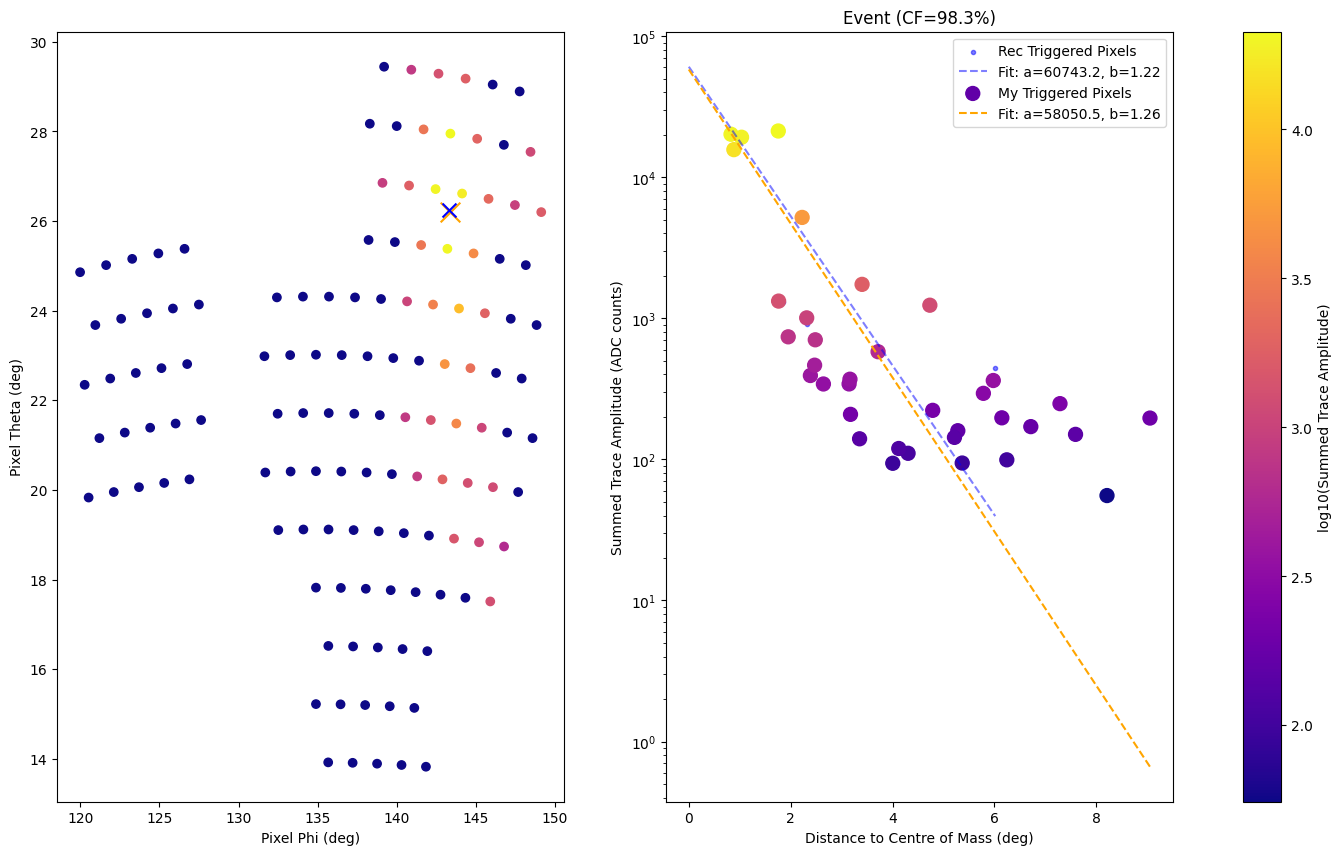

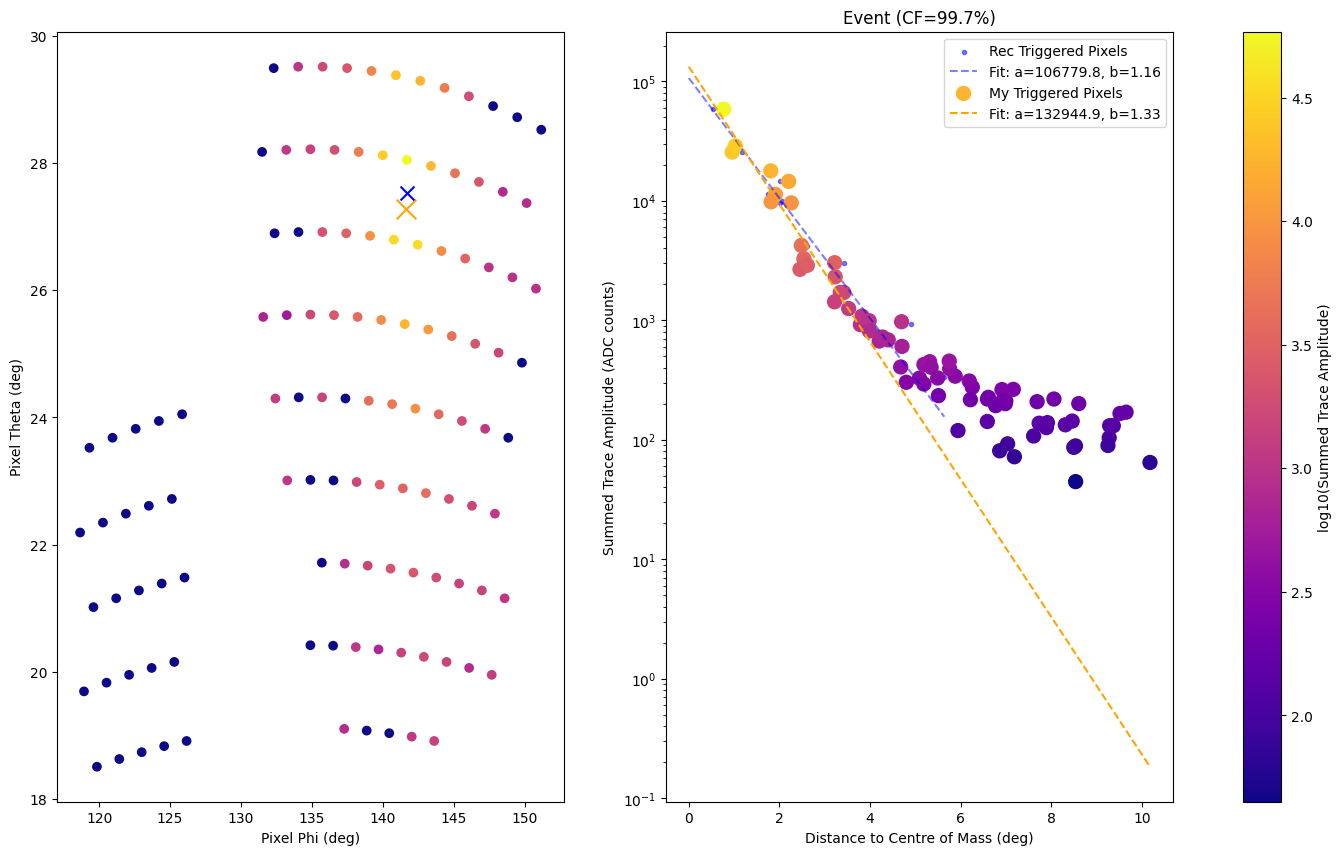

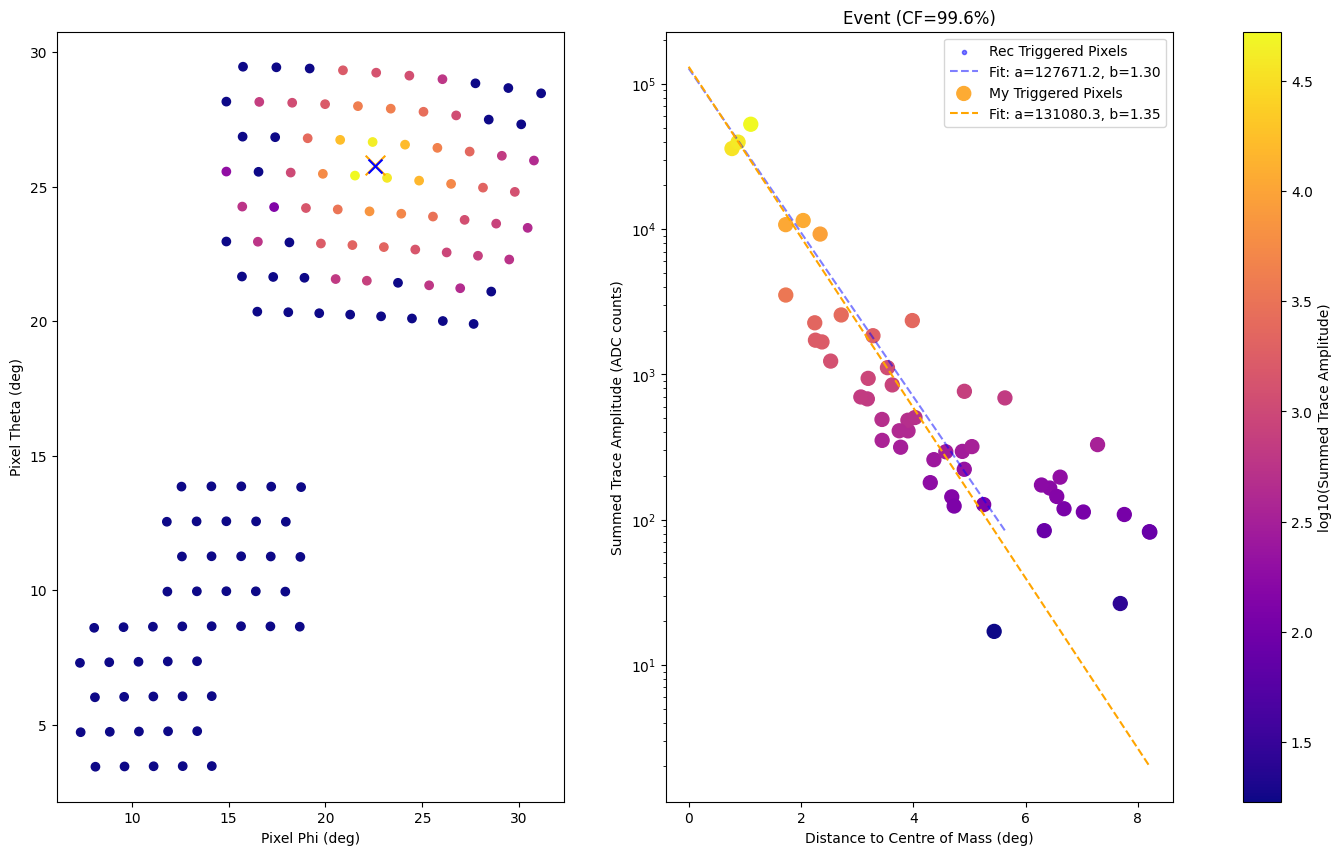

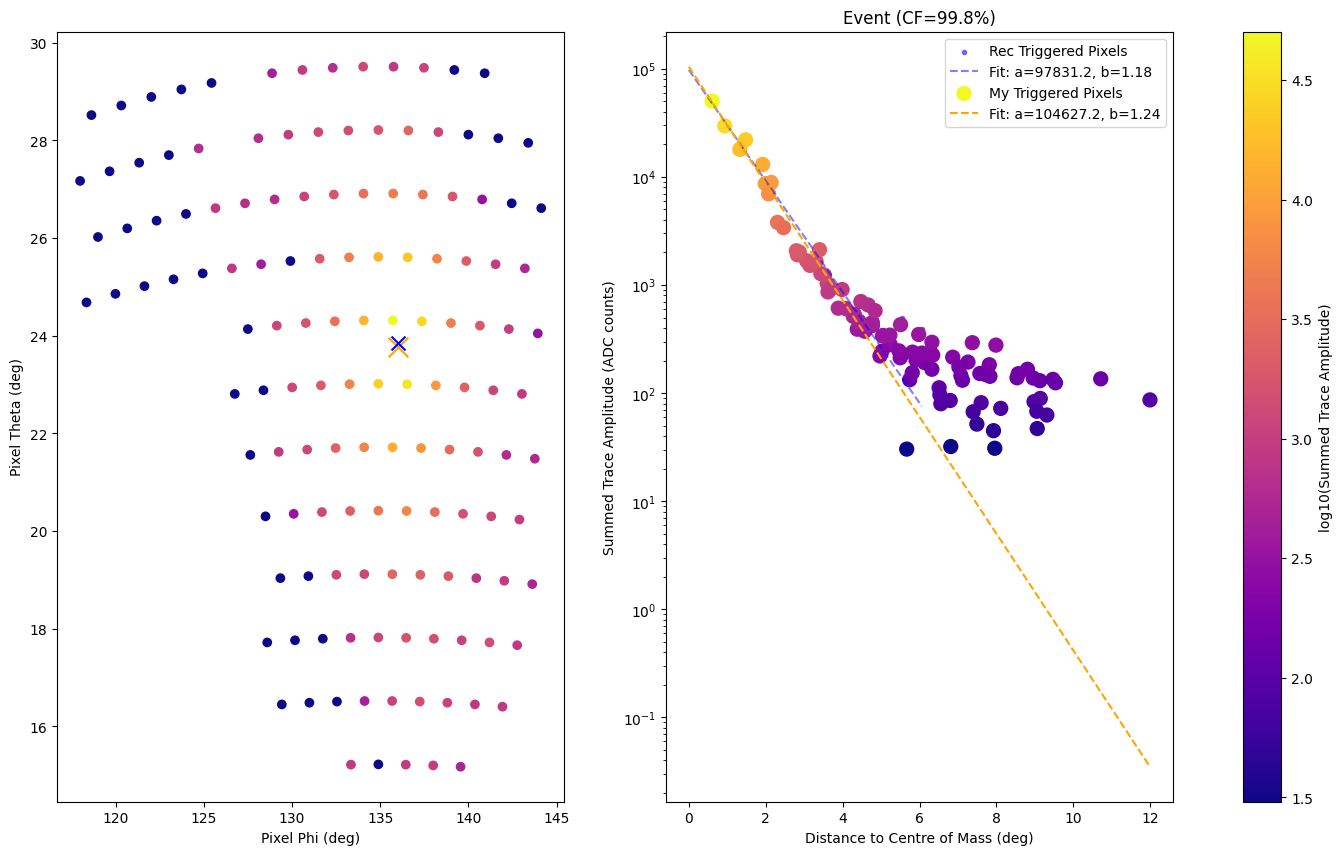

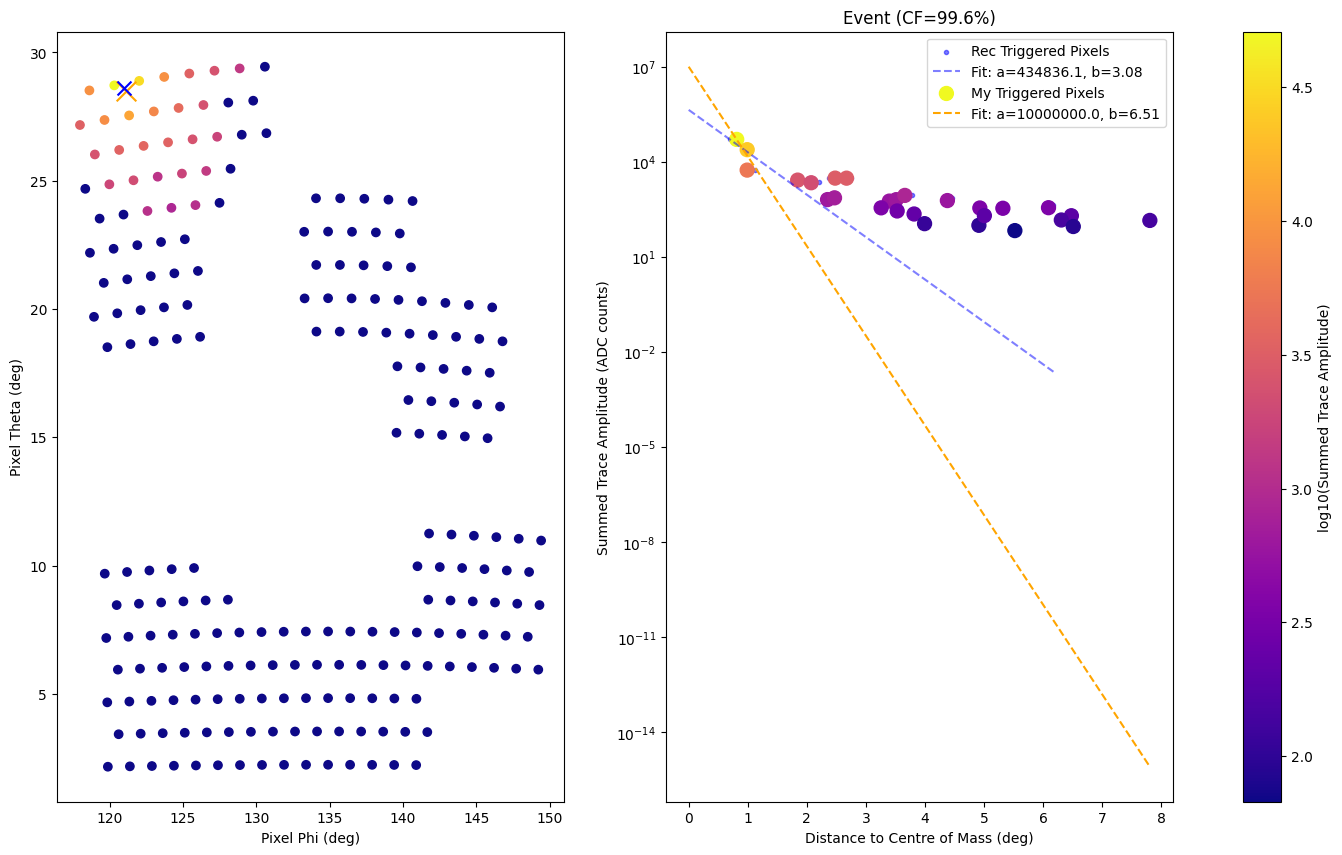

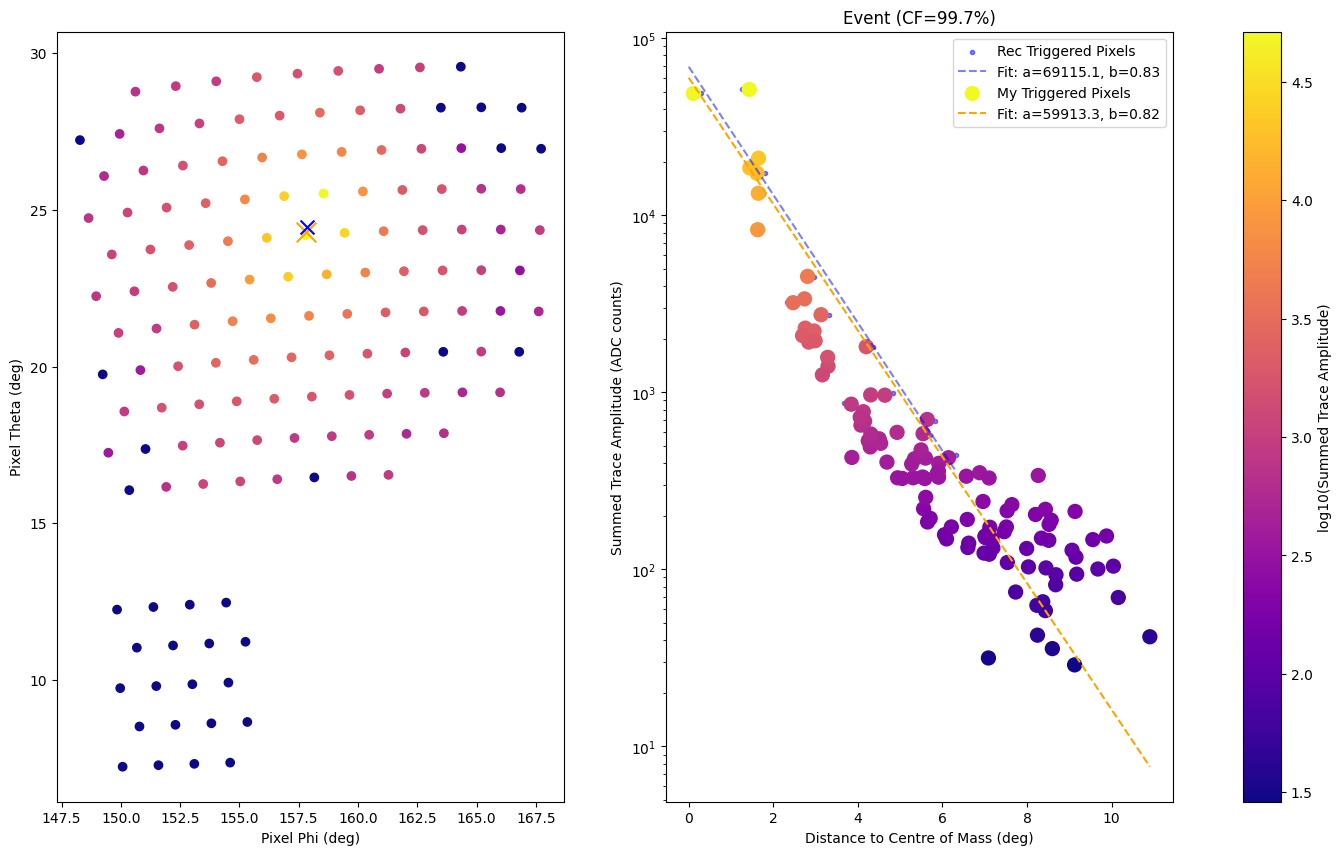

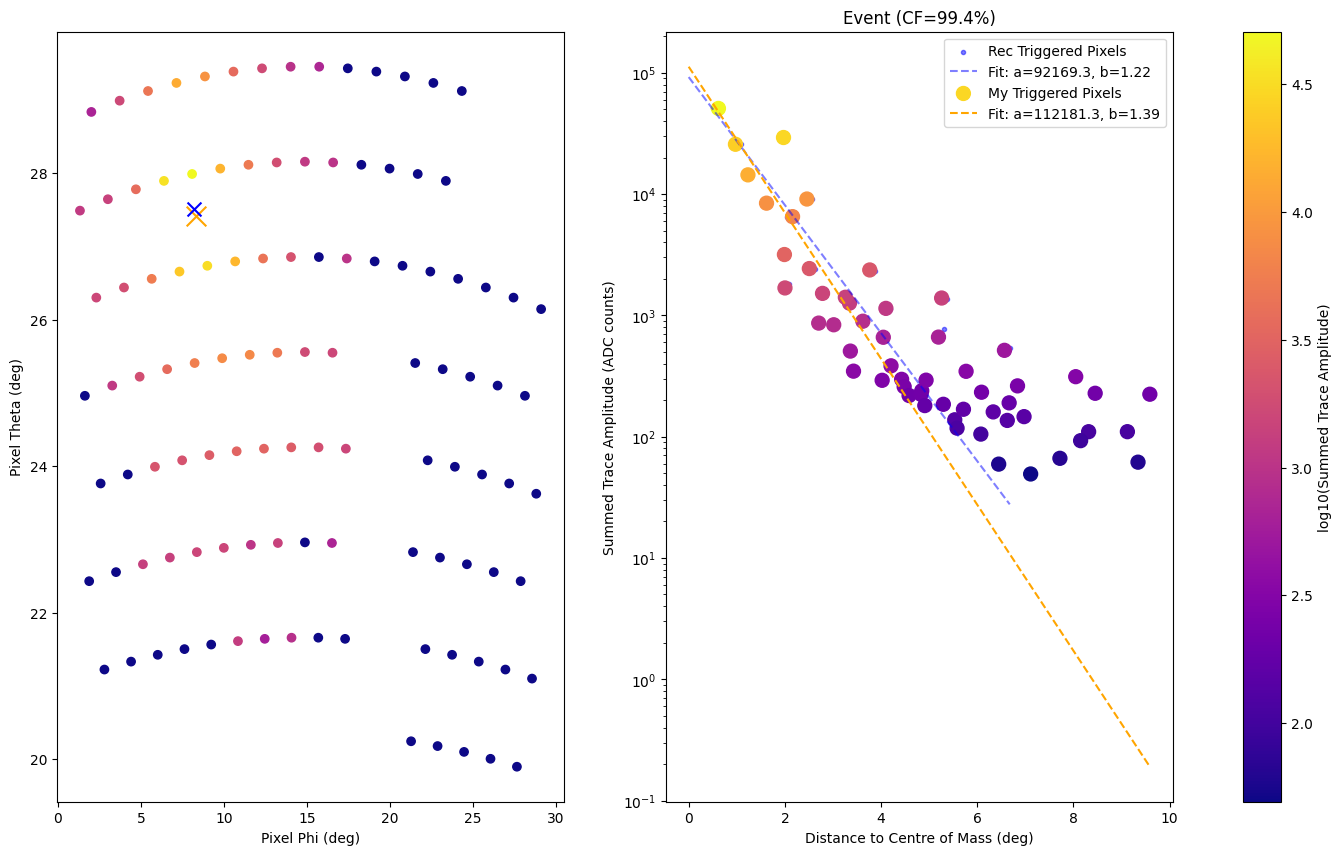

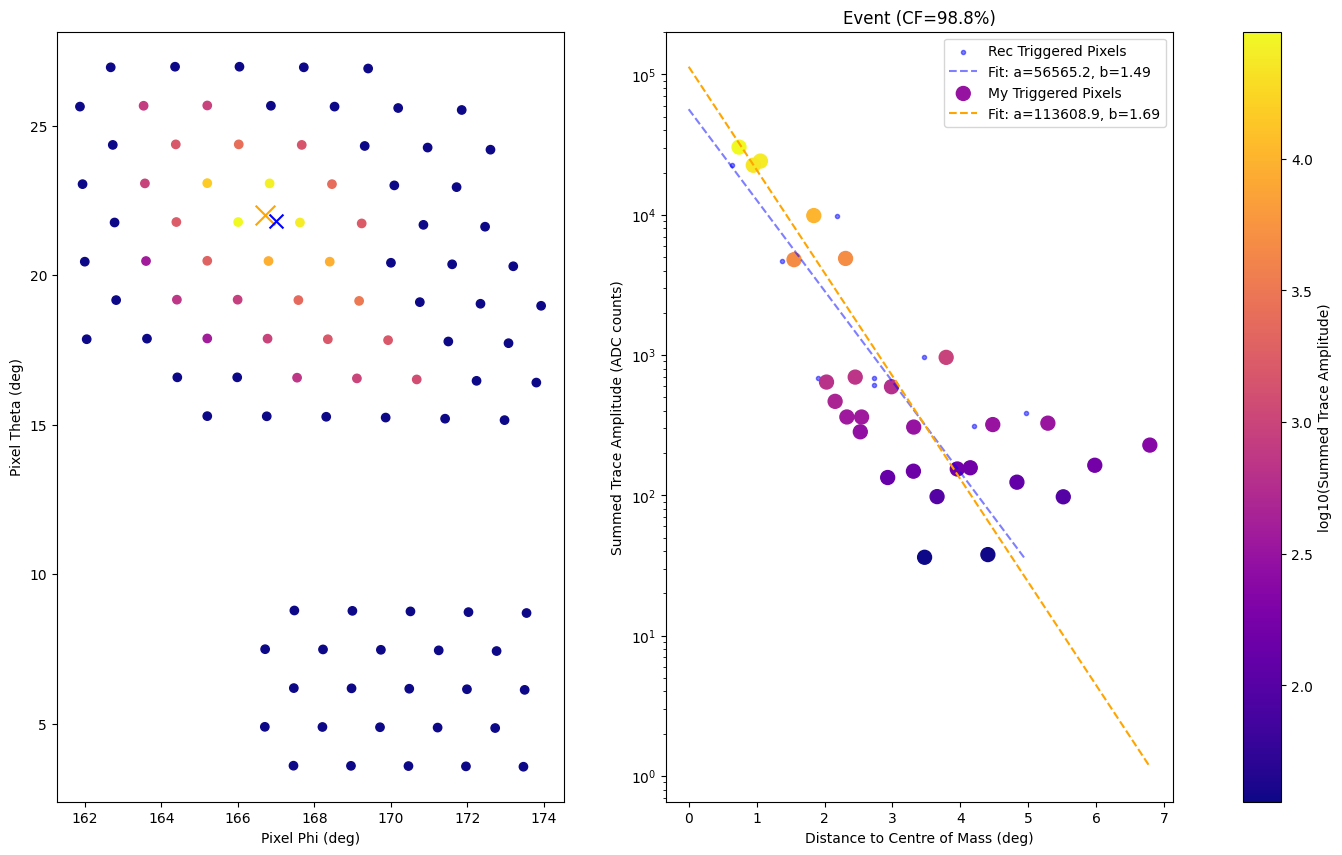

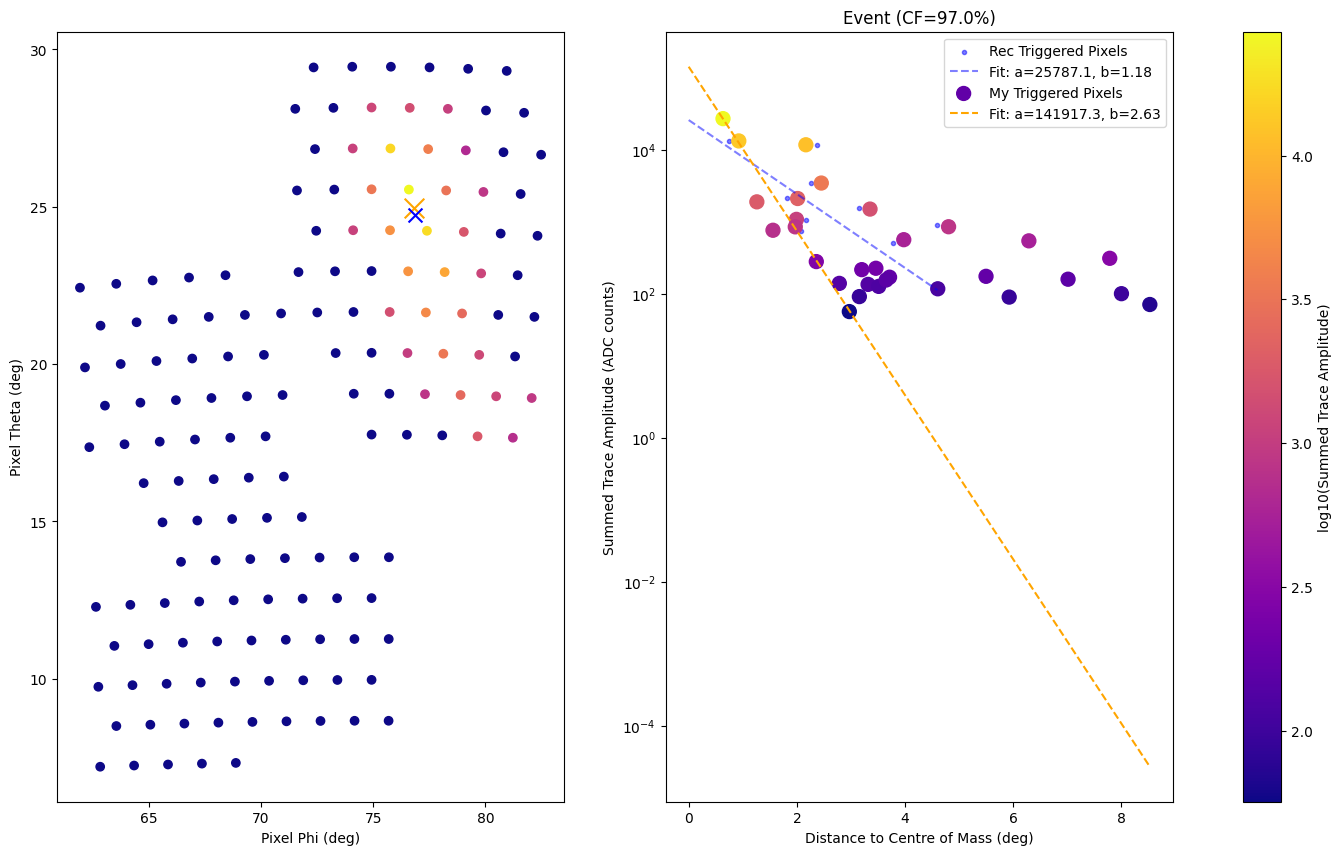

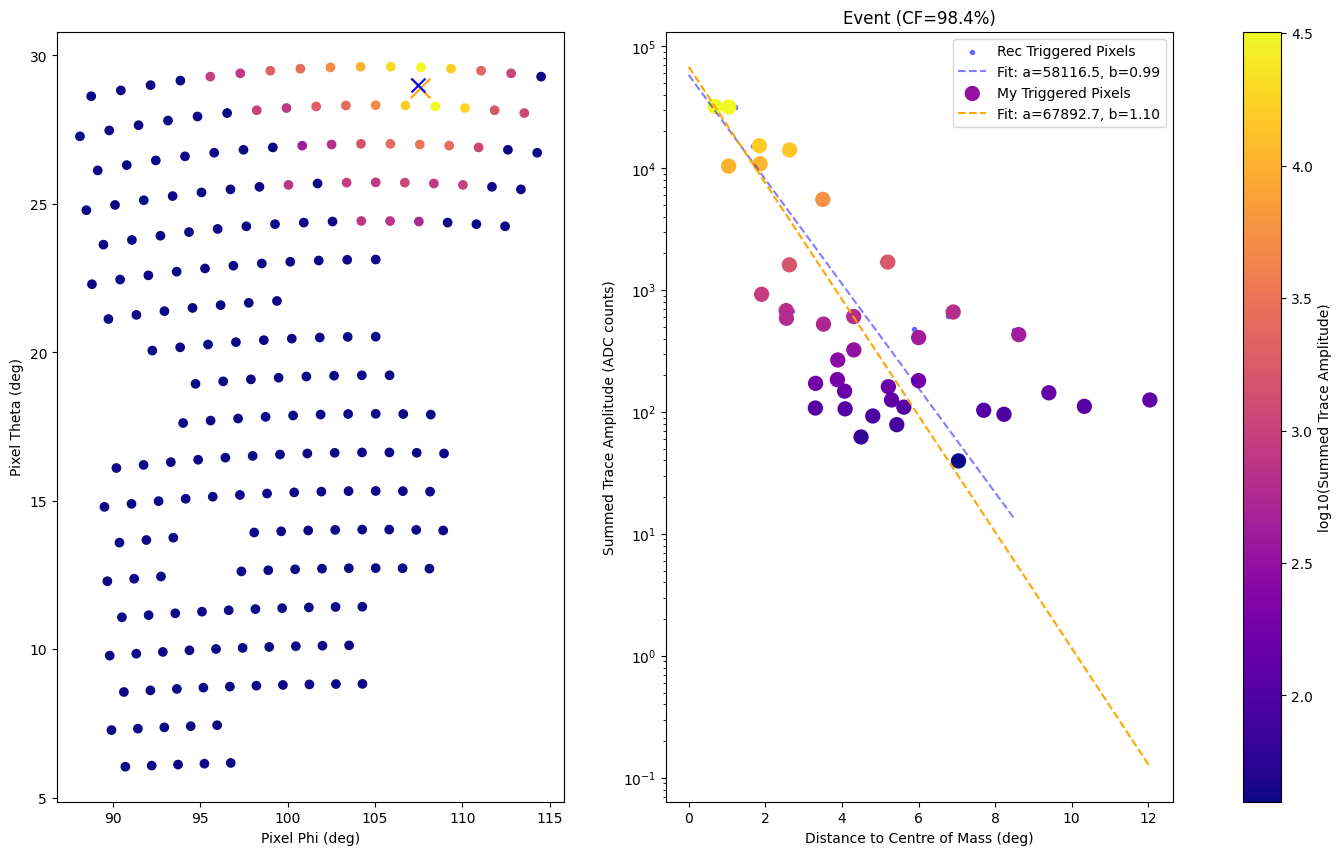

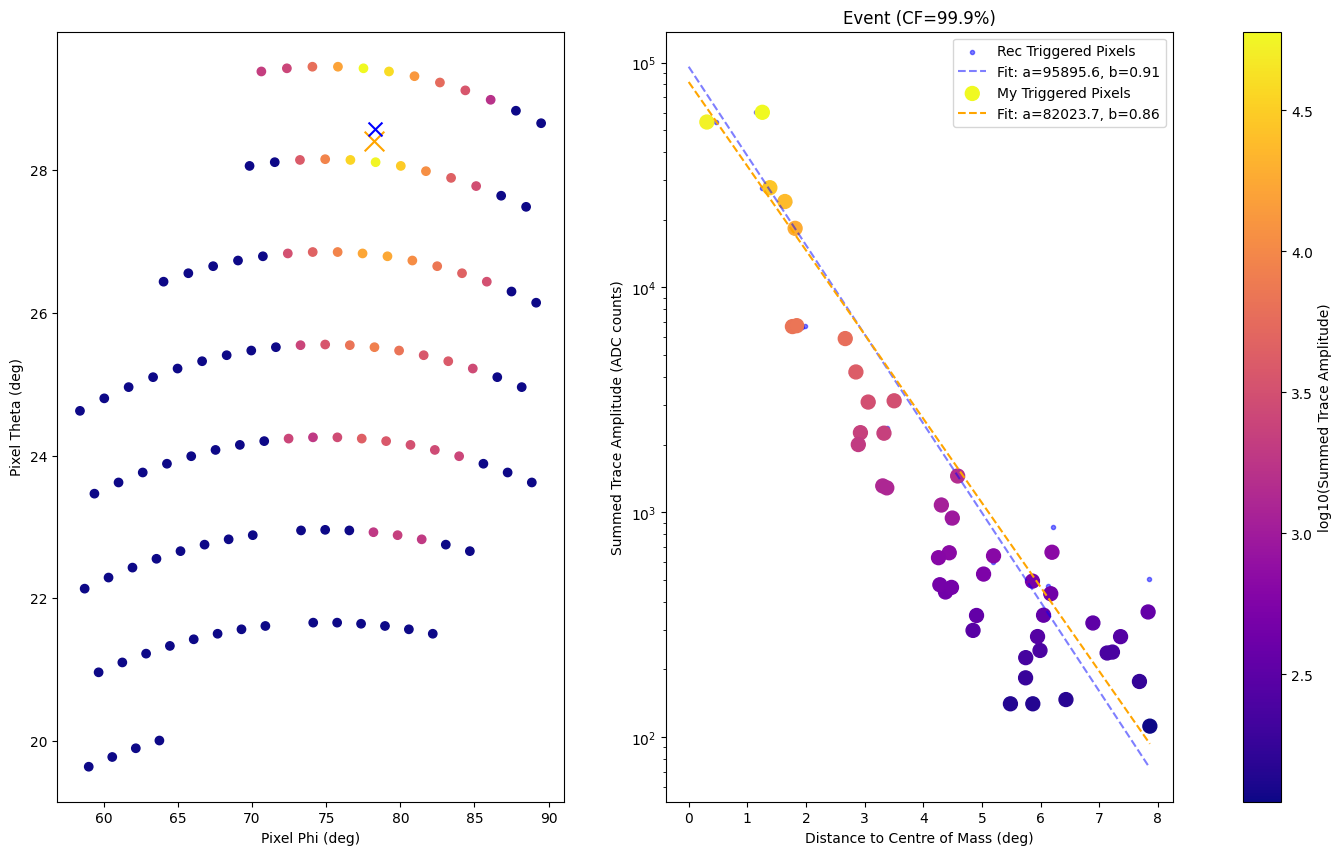

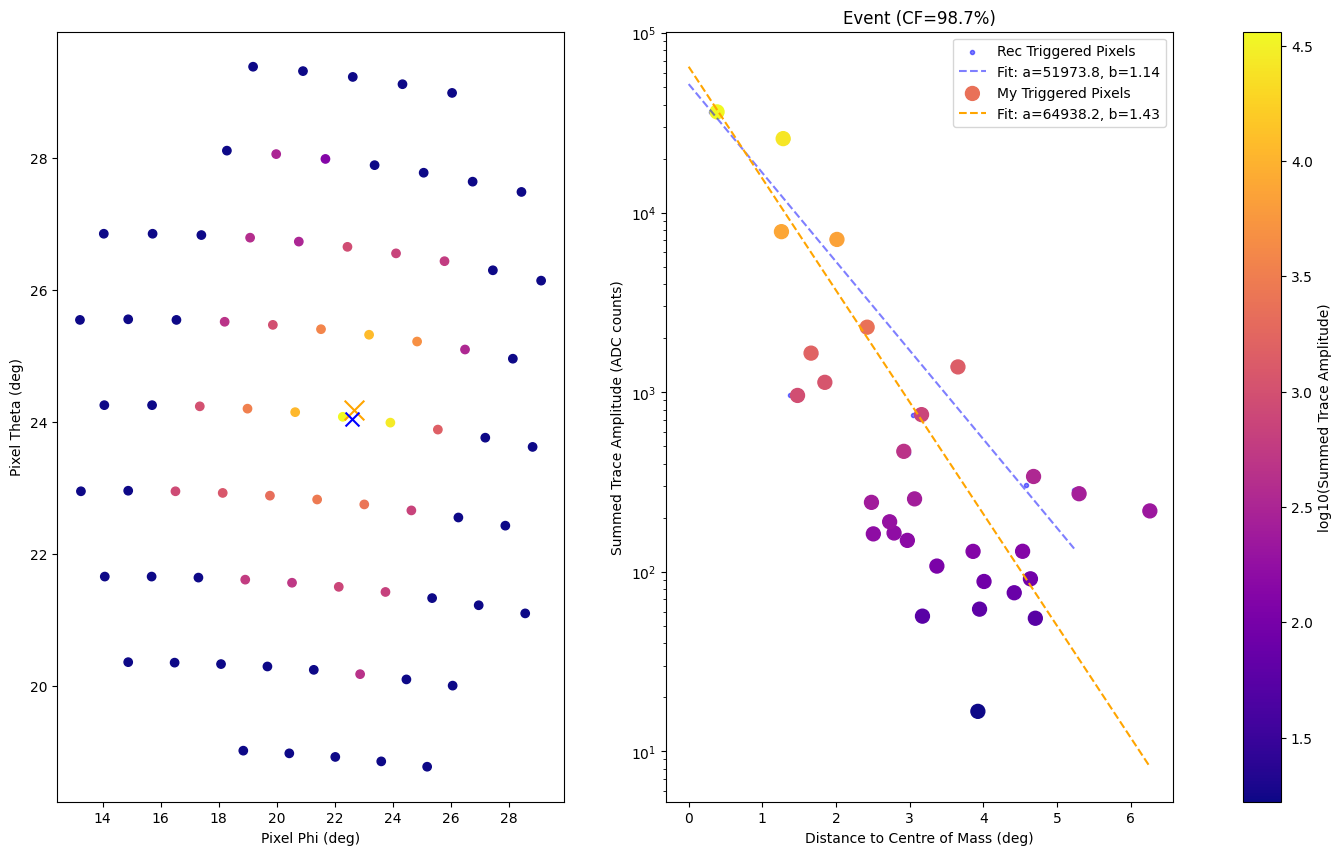

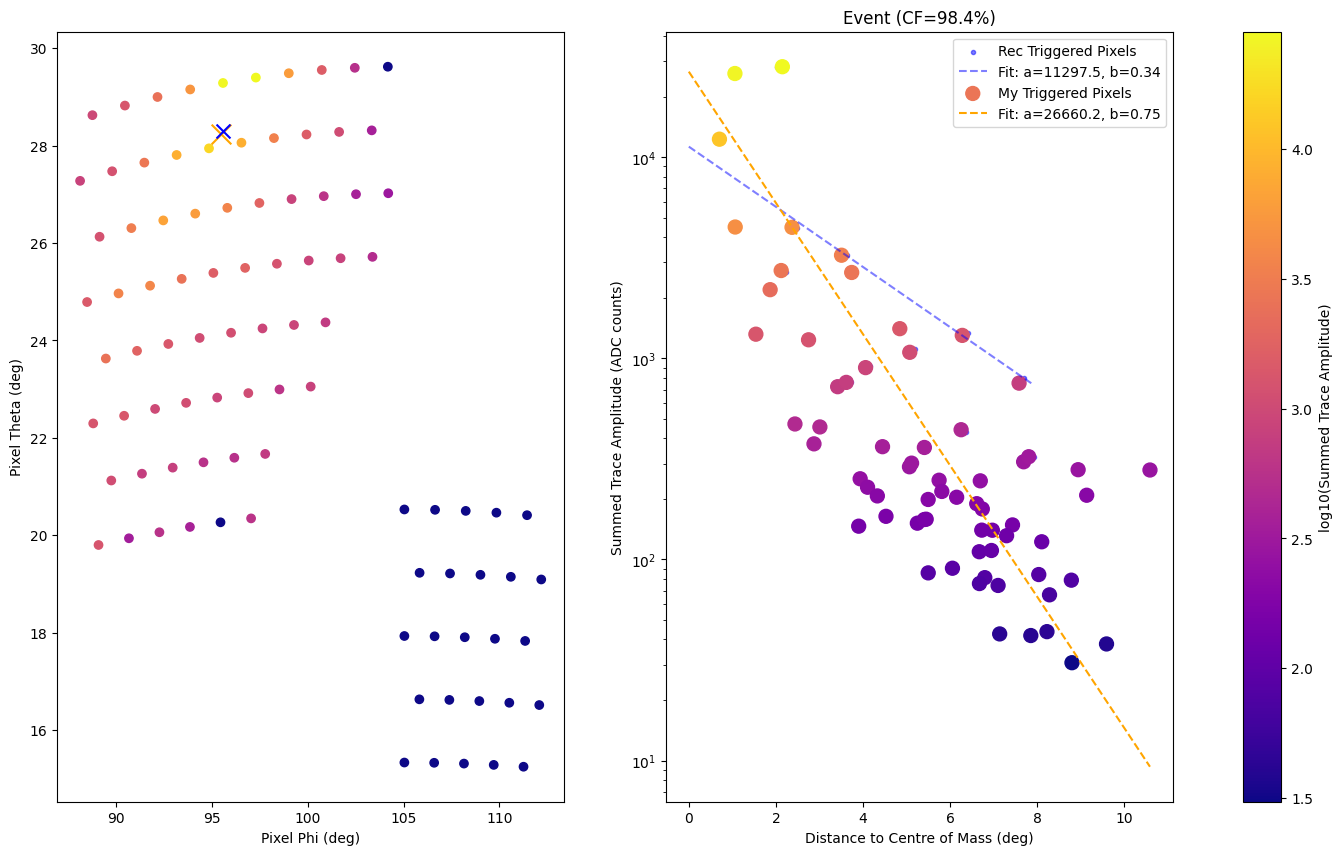

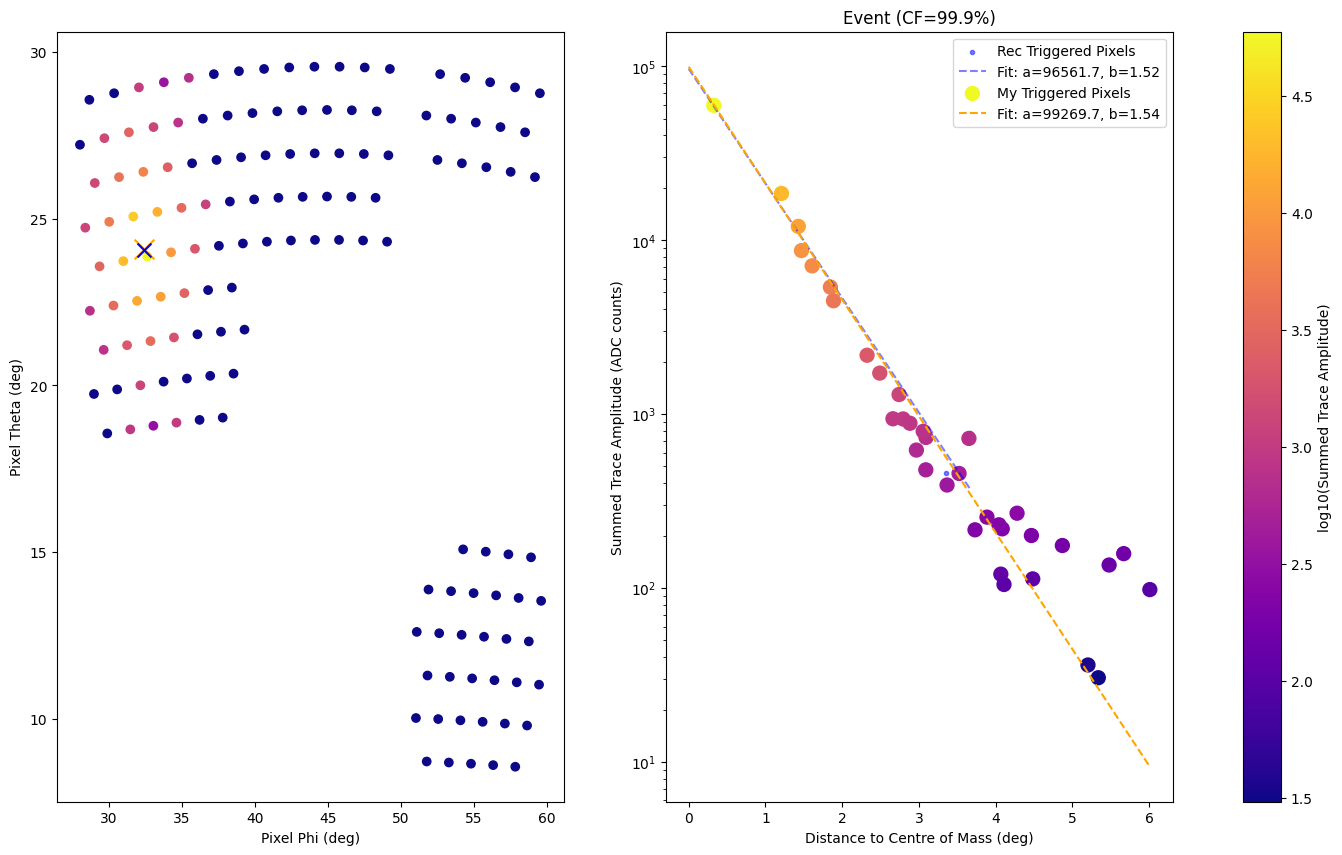

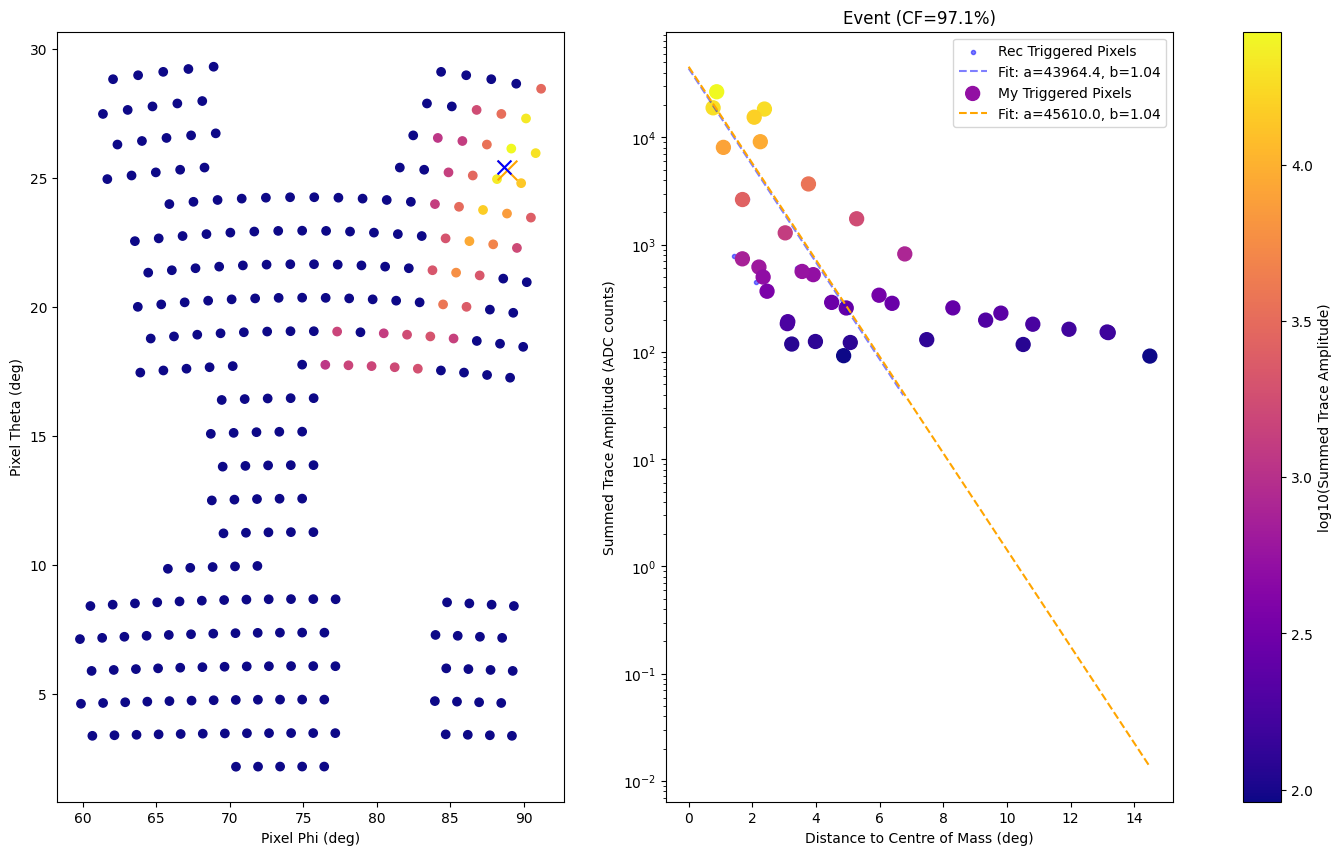

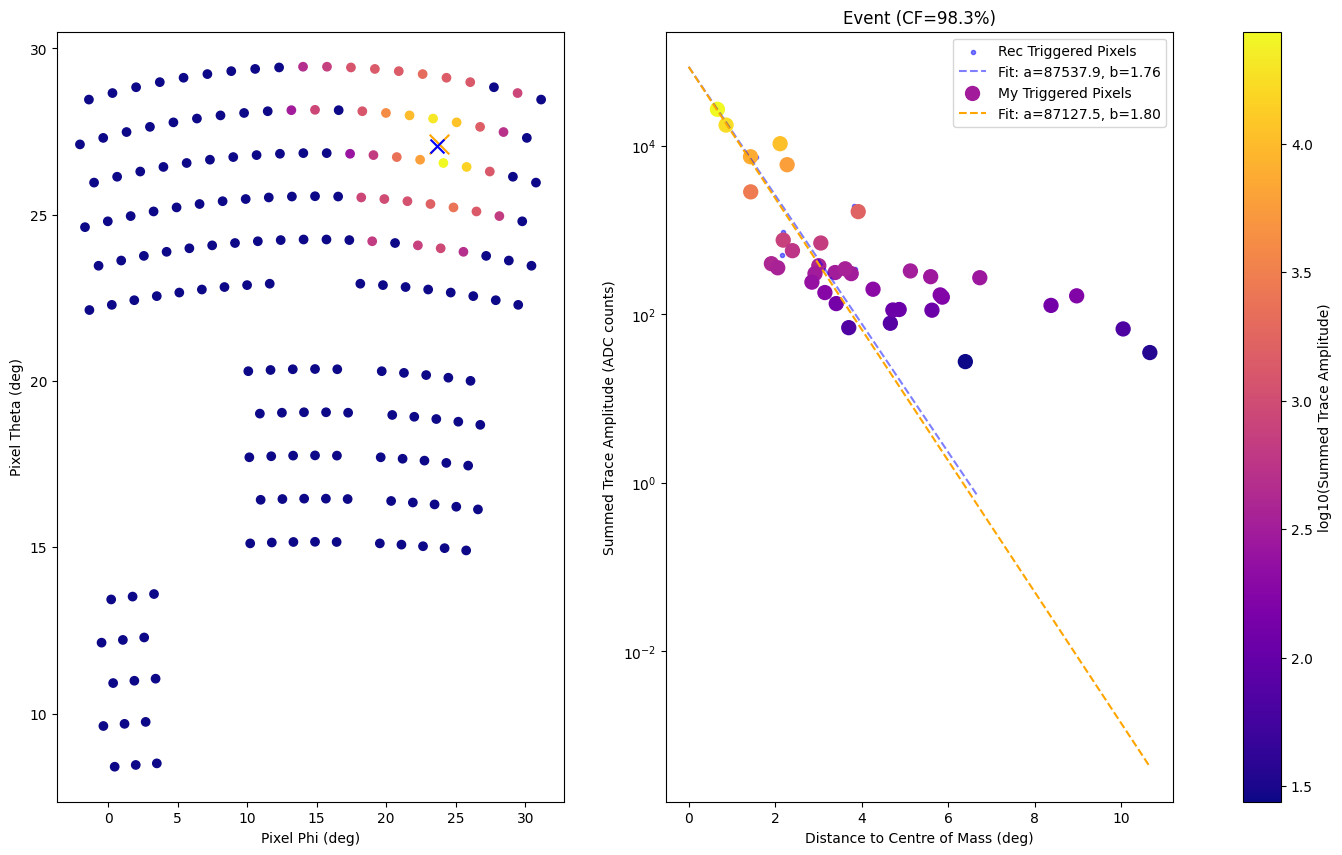

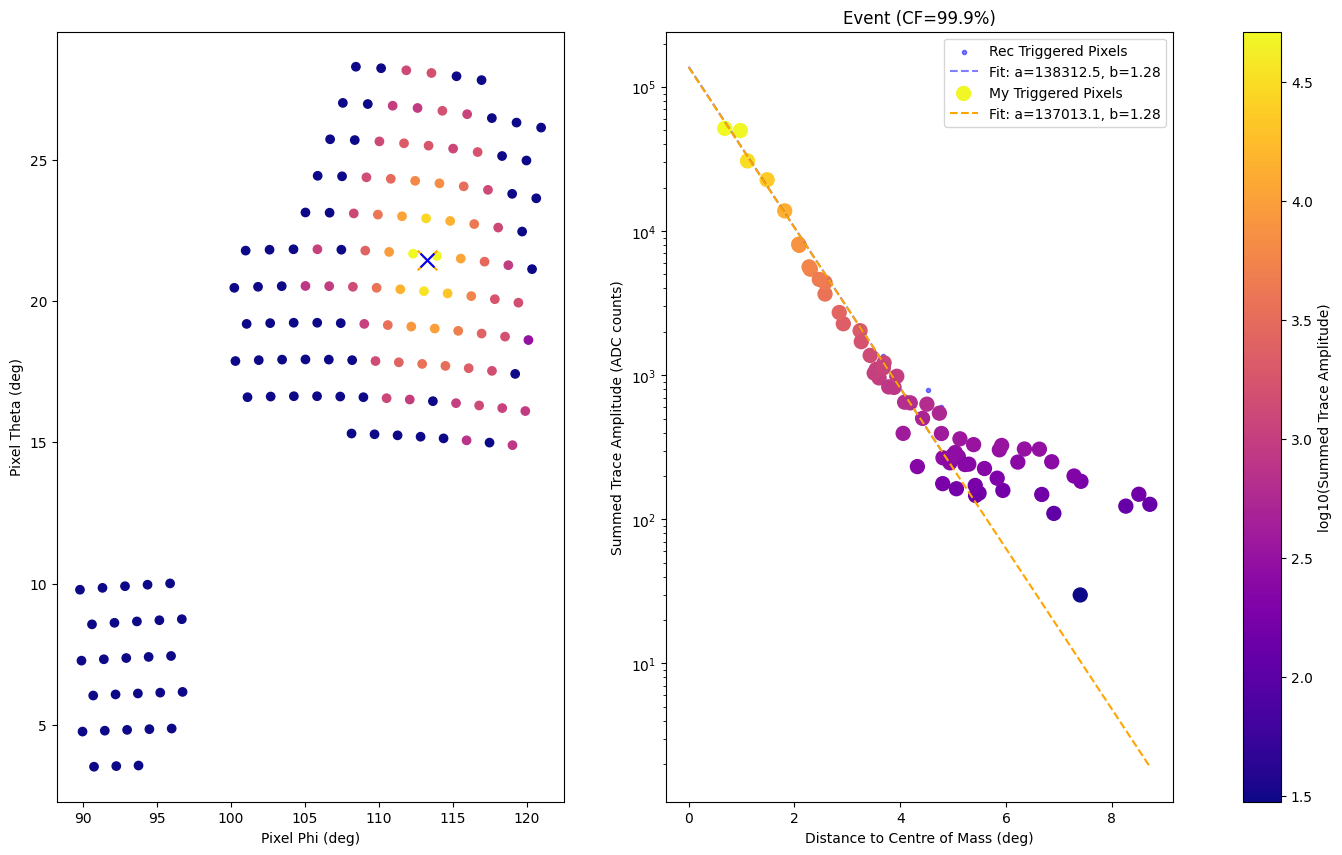

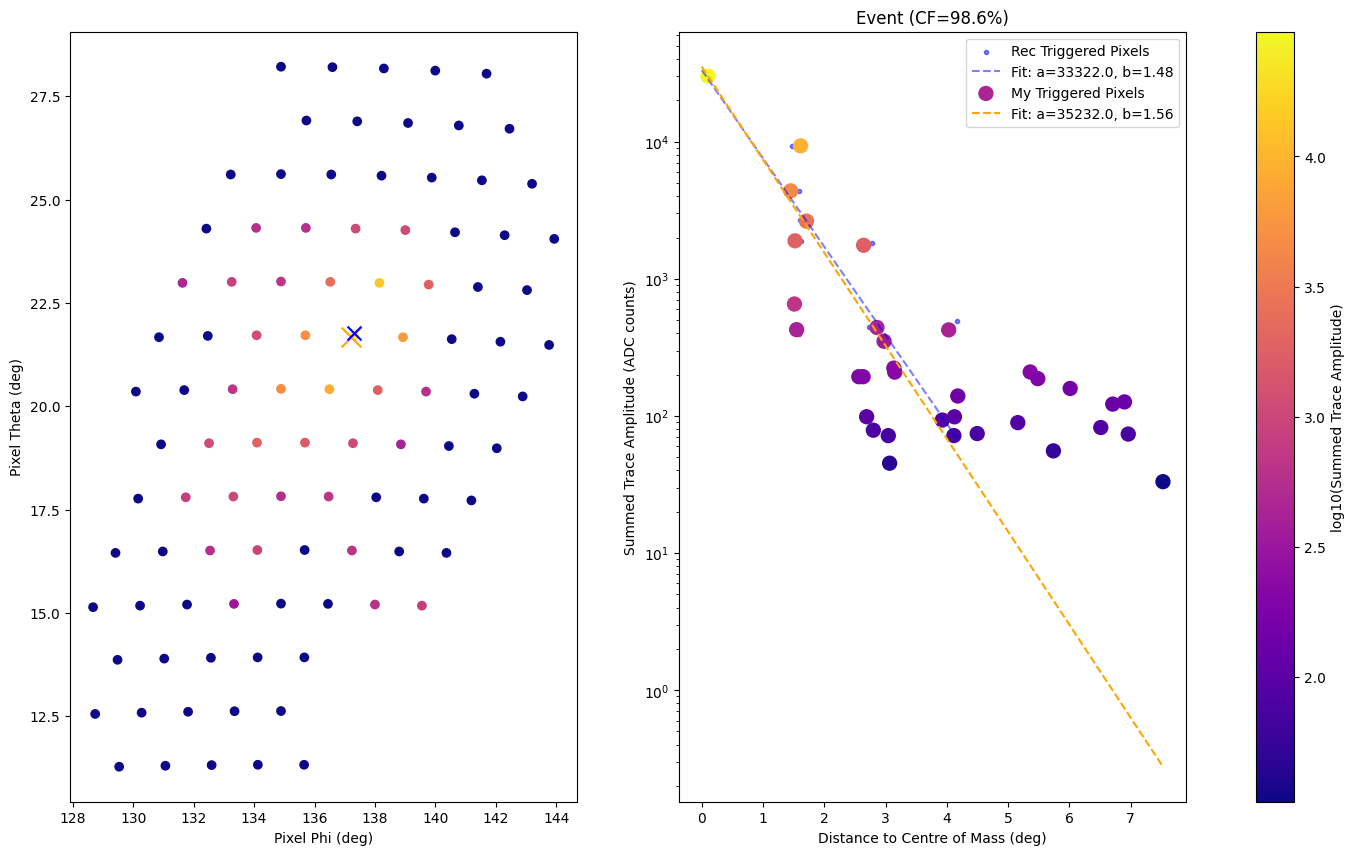

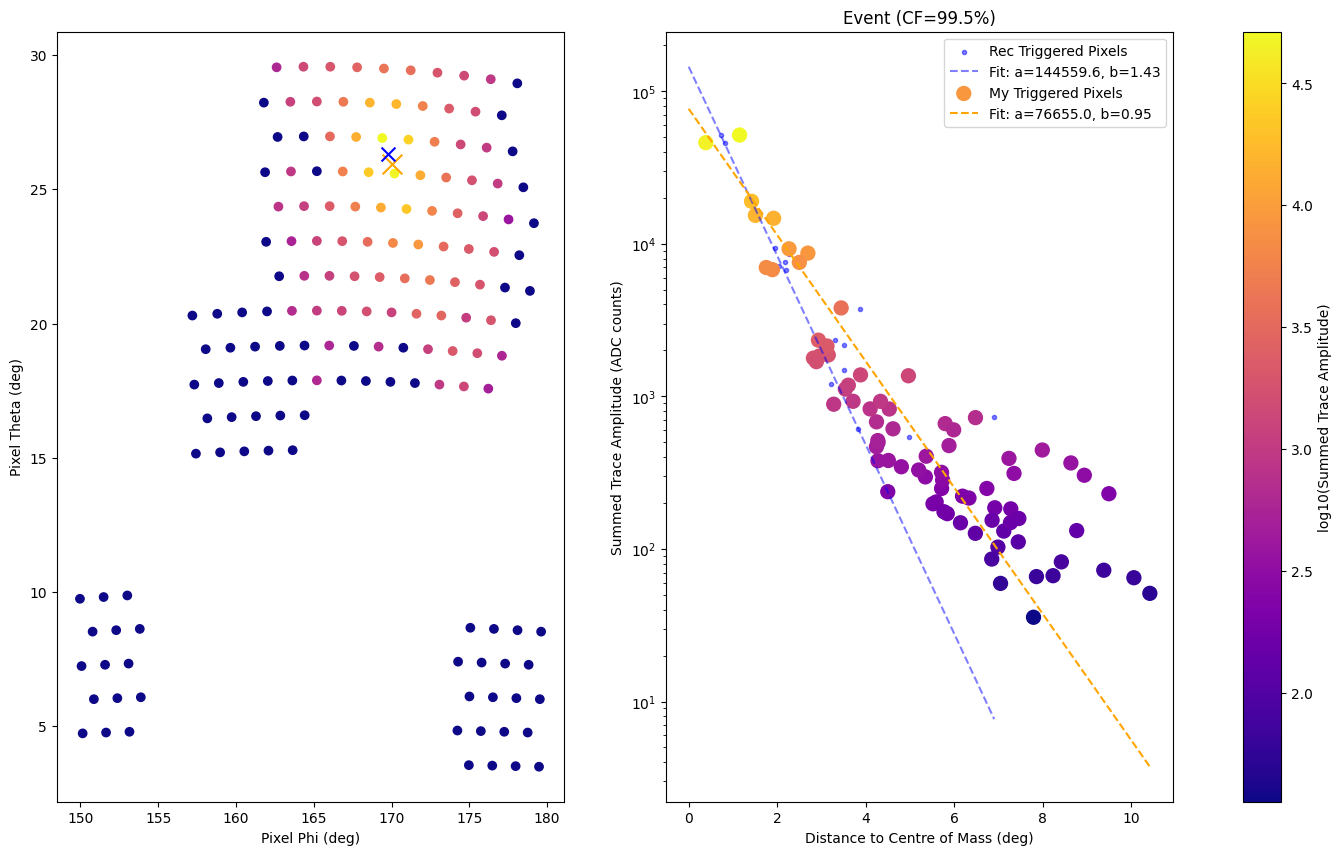

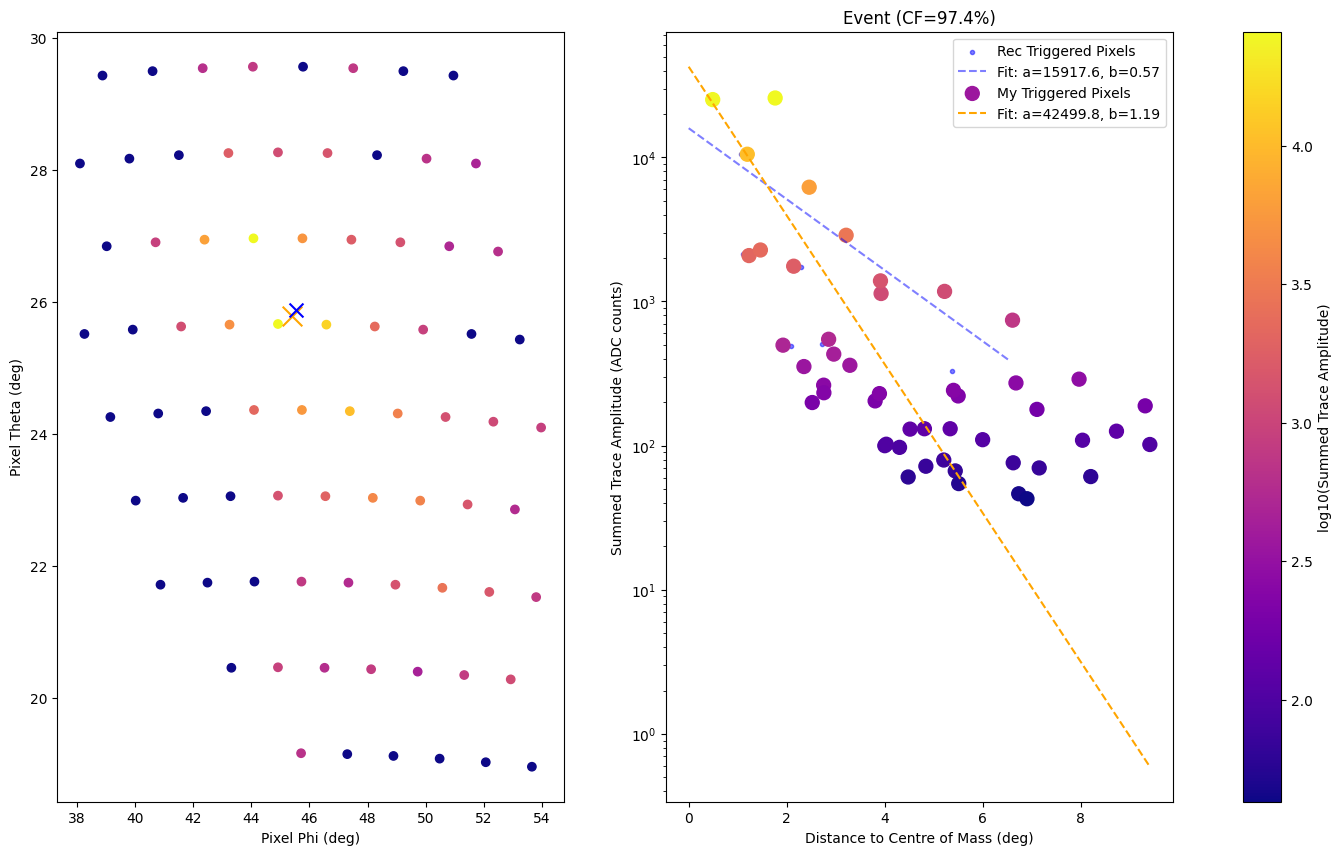

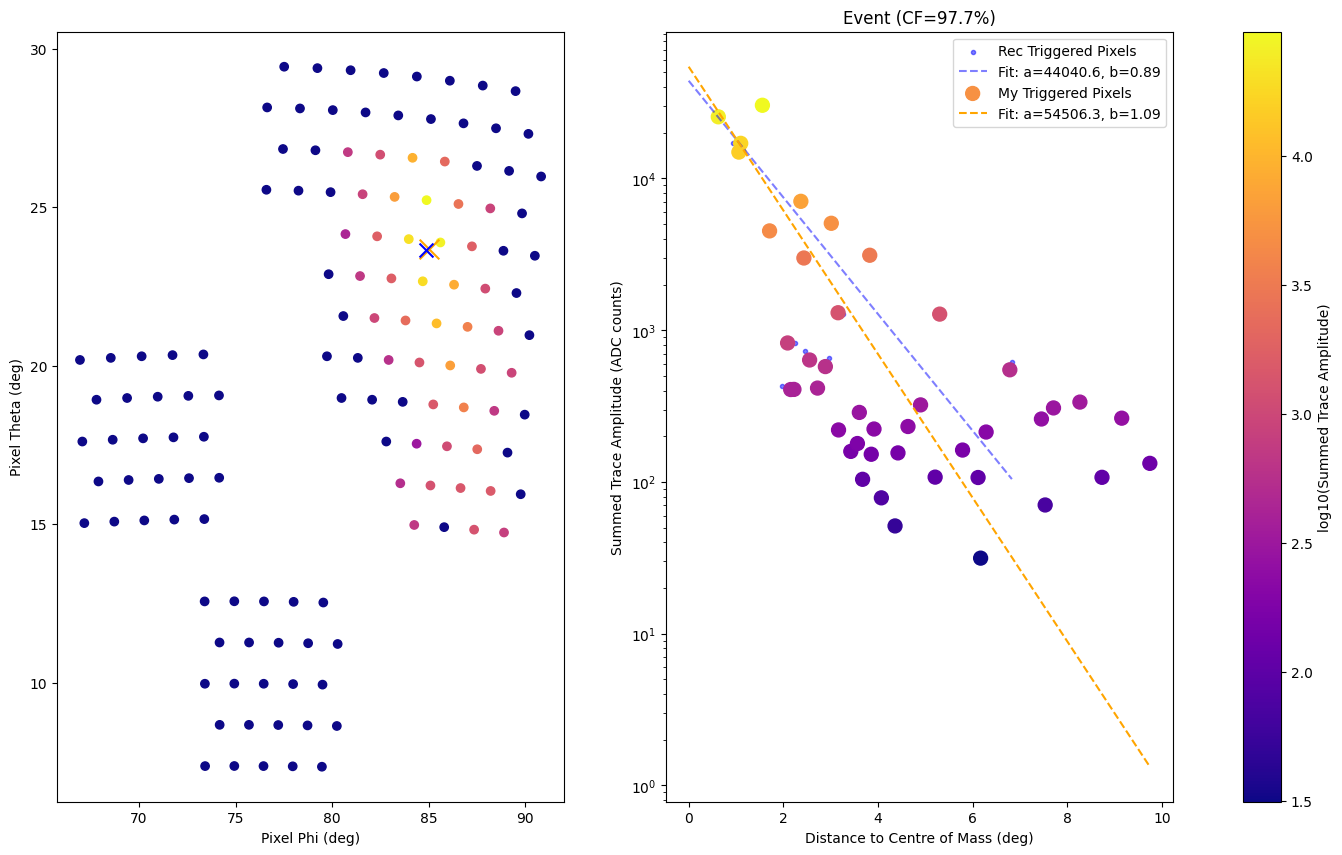

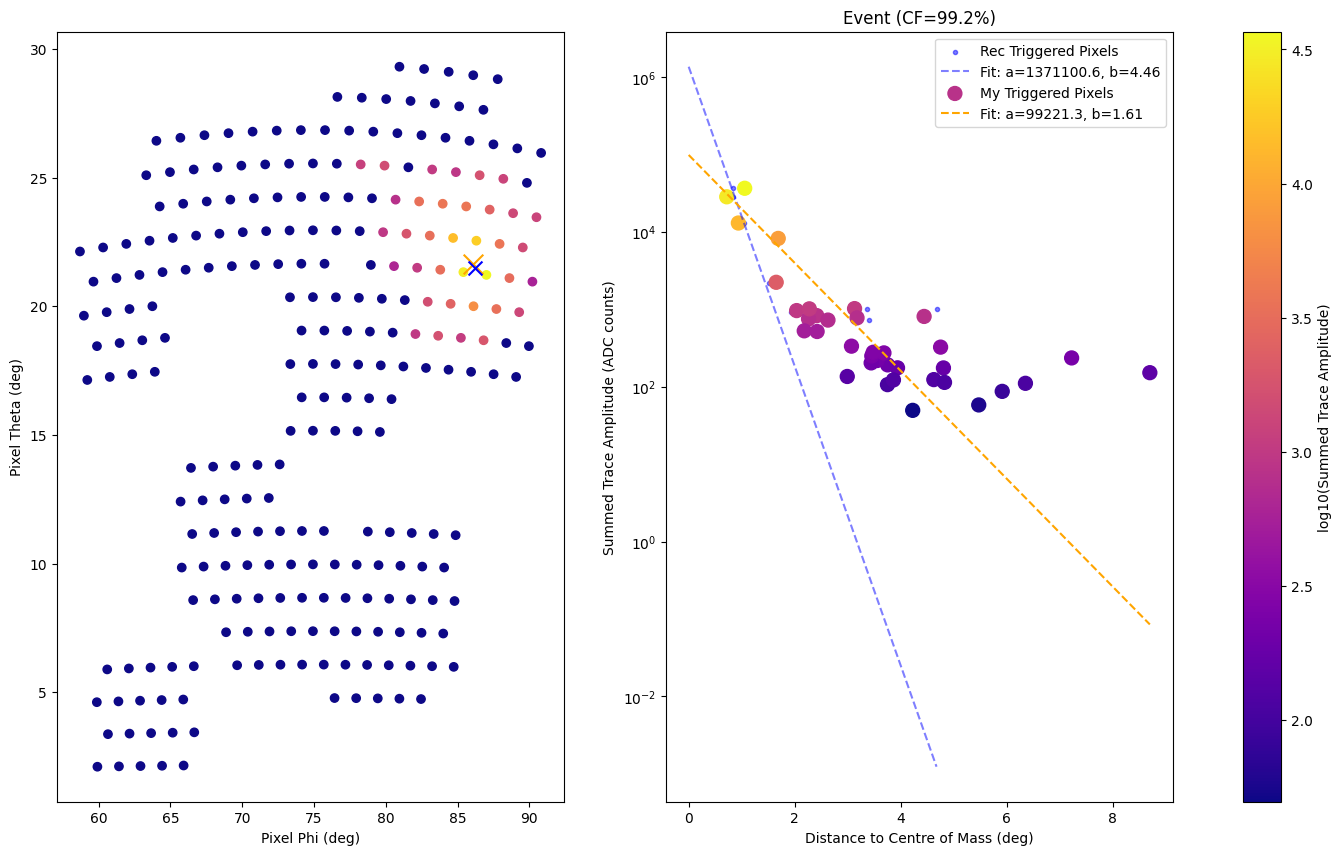

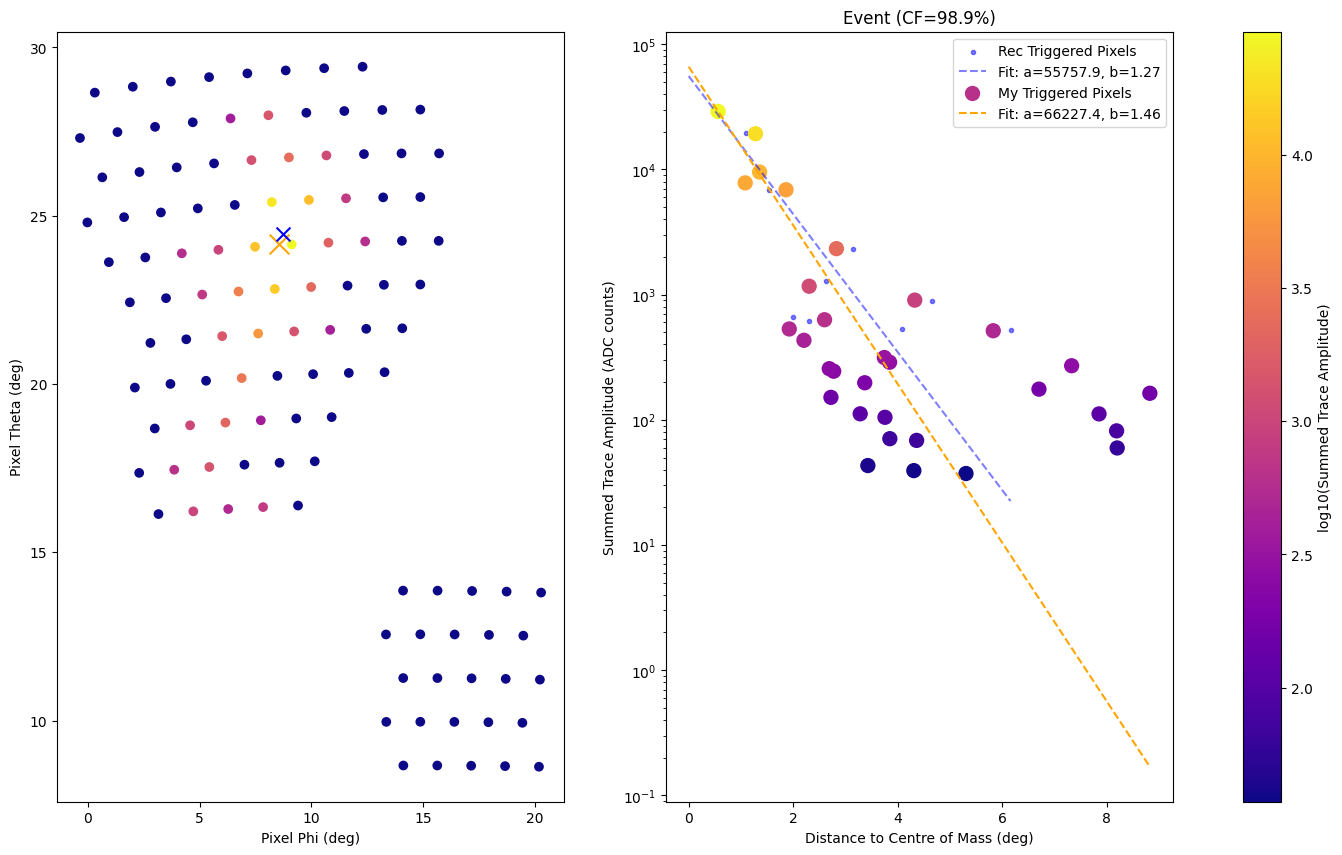

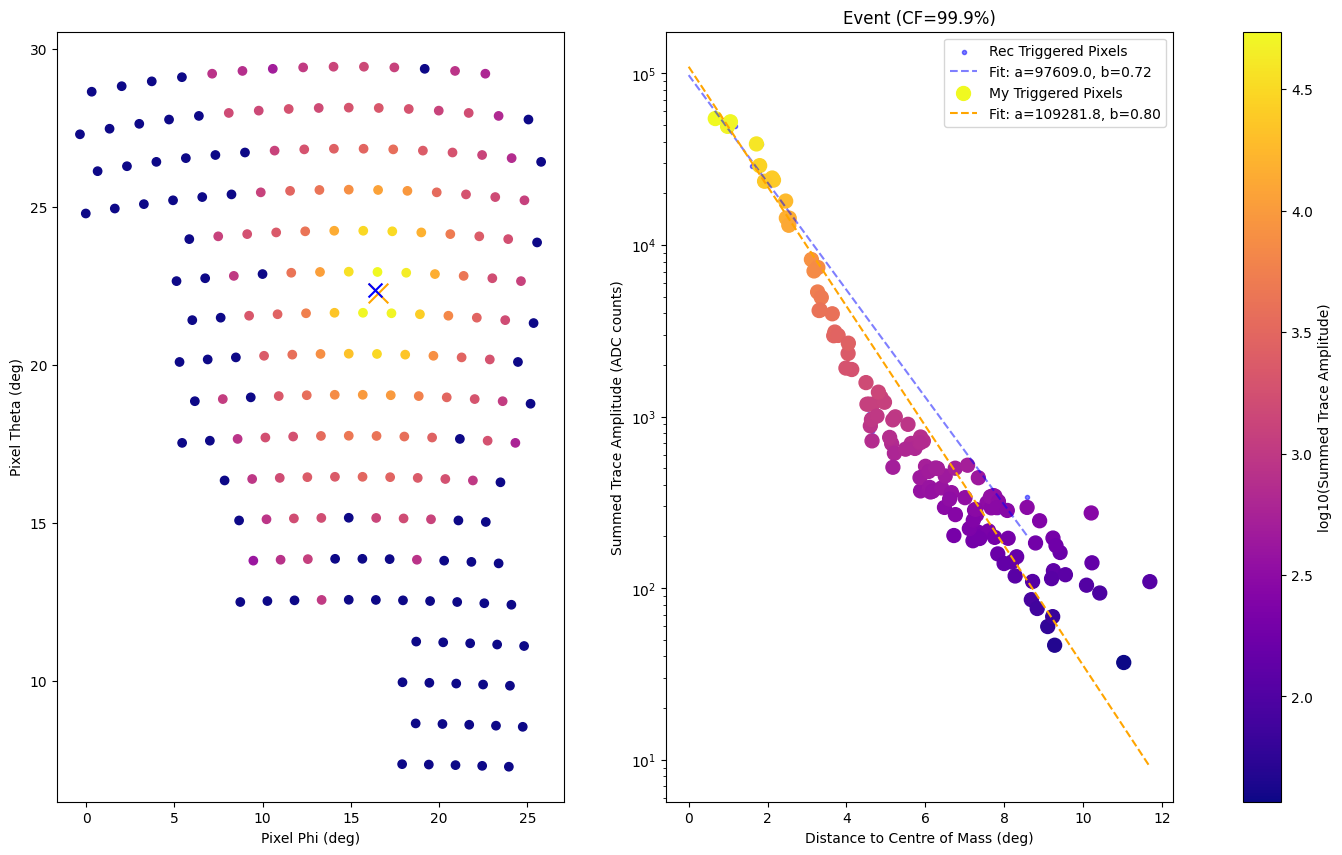

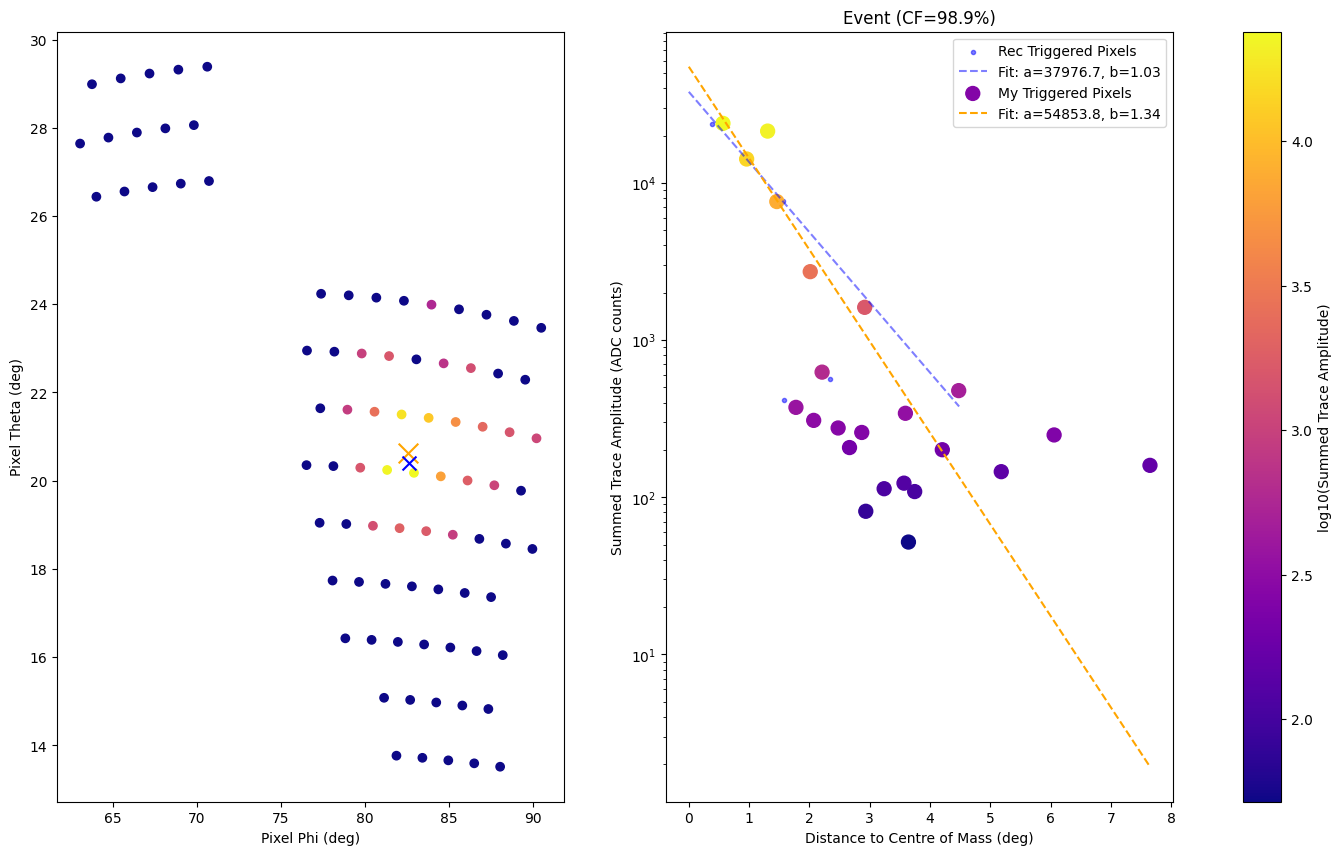

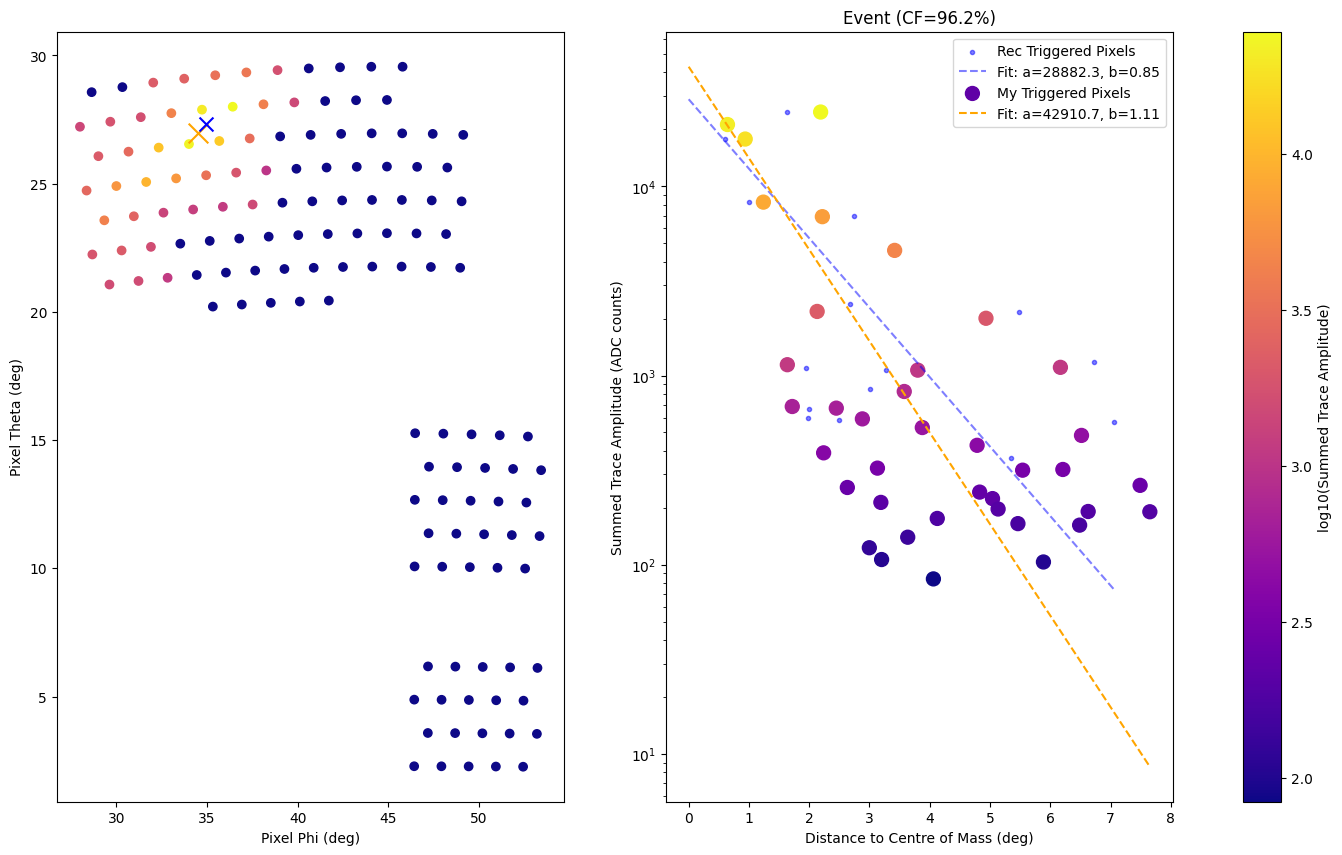

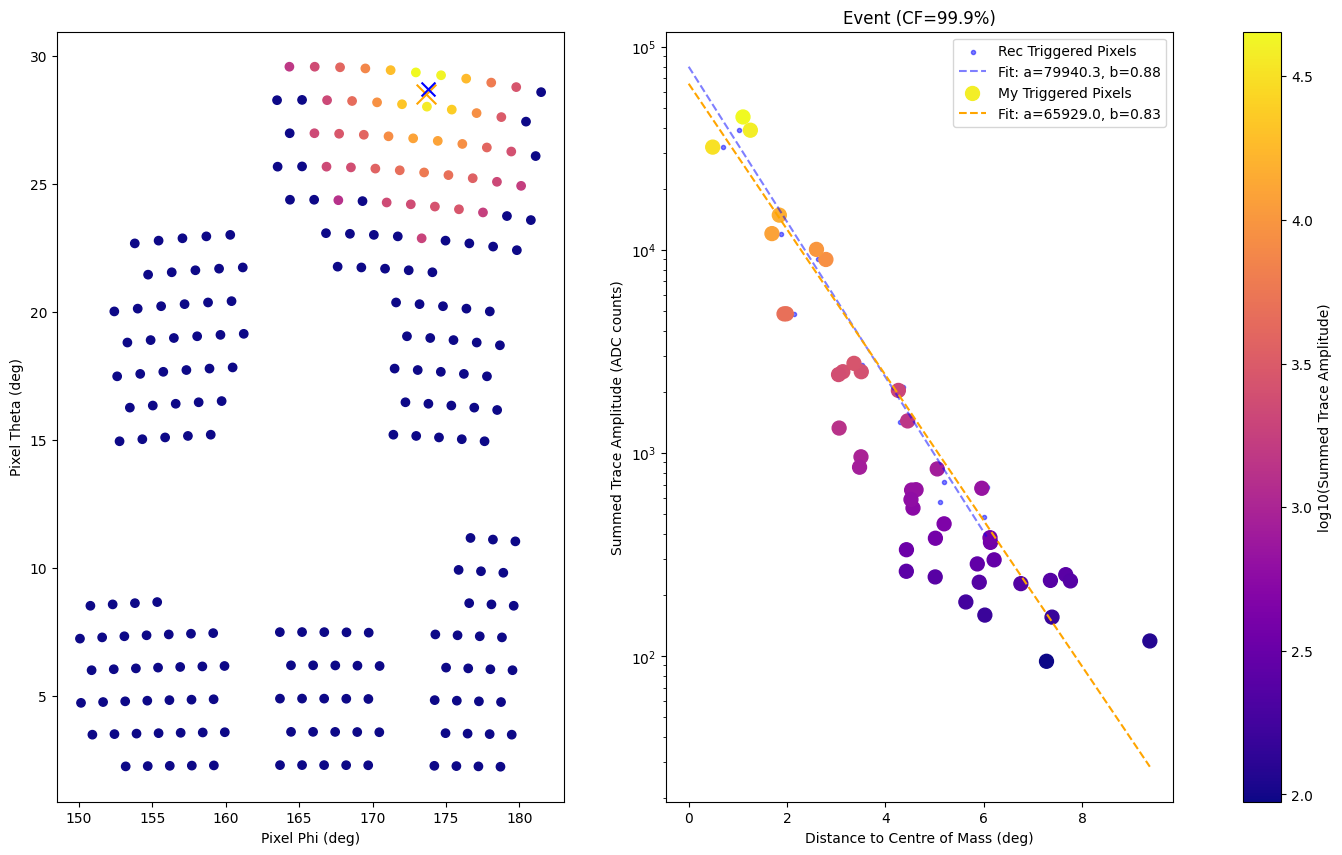

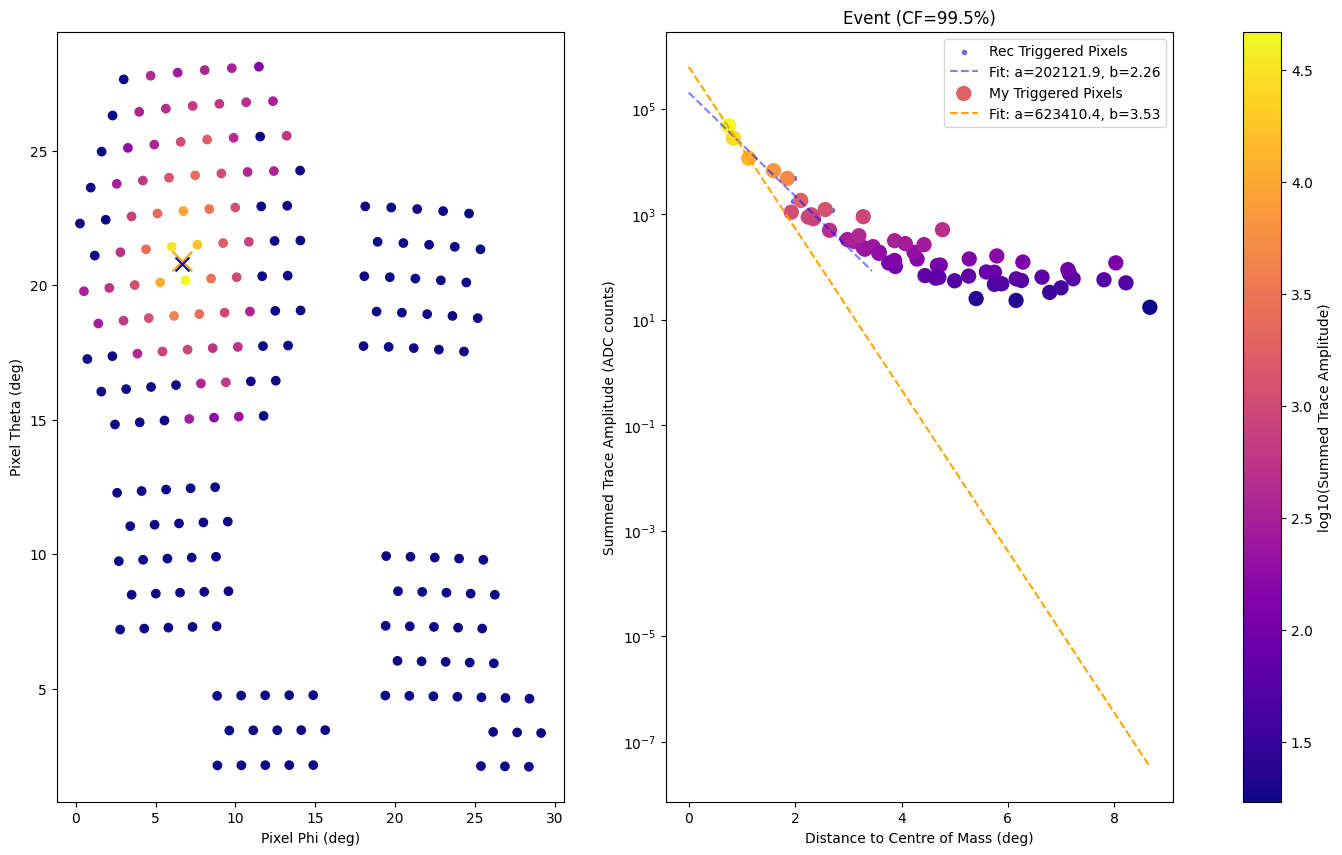

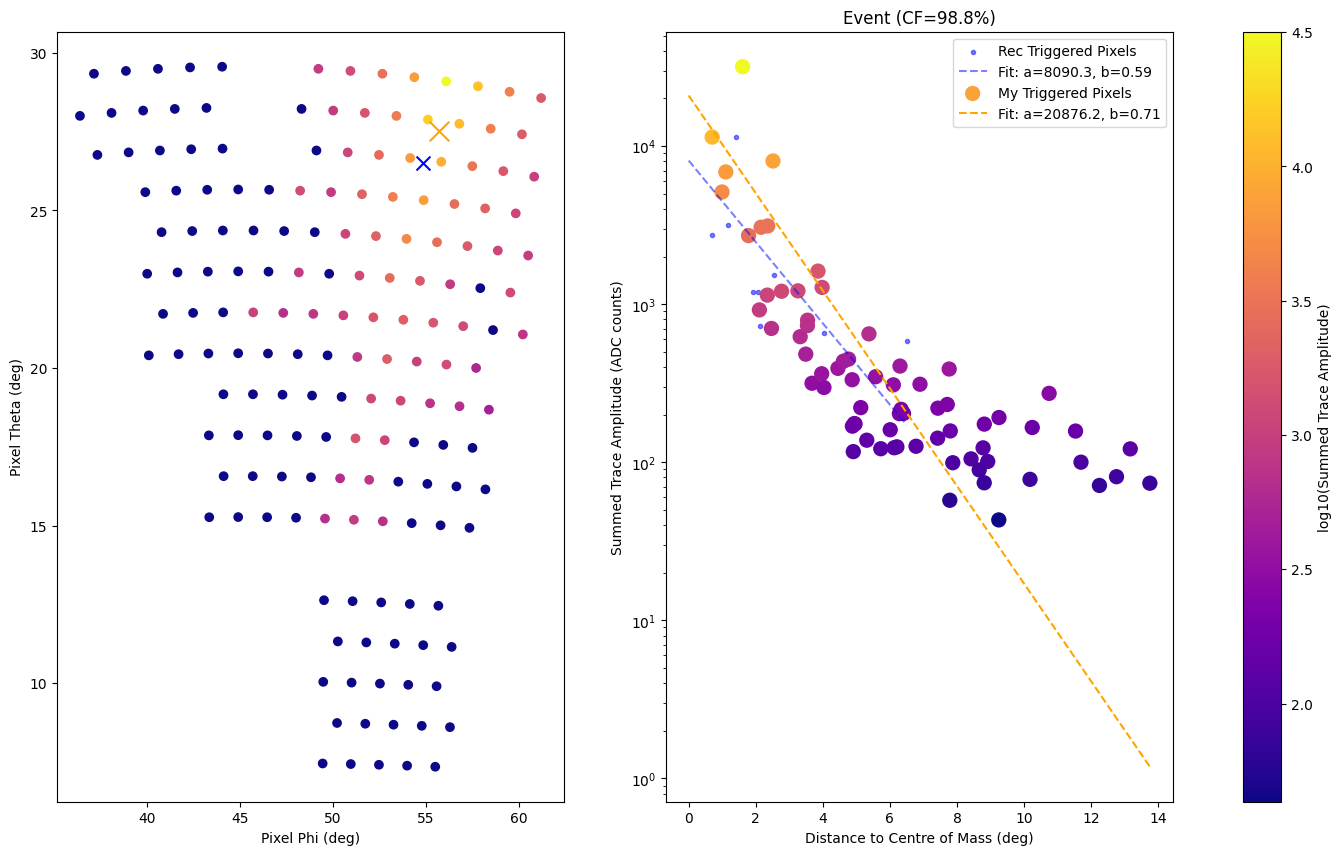

In [130]:
N_events = len(Example_Batch_Pruned)

def exponential(x, a, b):
    return a * np.exp(-b*x)

def LDF(X,X_opt,X_1,Scale,beta,alpha):
    return Scale * (X/X_opt)**beta * ((X+X_1)/(X_opt+X_1))**(beta+alpha)

UseFunc = 'Exponential'  # 'Exponential' or 'LDF'

if UseFunc == 'Exponential':
    fit_func = exponential
    bounds = ([0,0],[10**7,20])
    p0     = (1e4, 1)
elif UseFunc == 'LDF':
    fit_func = LDF
    bounds = ([0,0,0, -np.inf, -np.inf],[np.inf, np.inf, np.inf, np.inf, np.inf])
    p0     = (1e3, 100, 10e5, 1, 0)



list_of_params_rec = []
list_of_params_myy = []

for Event in Example_Batch_Pruned:
    # Find Centre of Mass
    Trace = Event['PixelData']['Trace']
    Rec_Trigger = Event['PixelData']['RecTrigger']
    Myy_Trigger = Event['MyyTrigger']

    Rec_Trace_Sum_over_time = np.sum(Trace*Rec_Trigger, axis=1).astype(float)
    Myy_Trace_Sum_over_time = np.sum(Trace*Myy_Trigger, axis=1).astype(float)

    Pixel_Thetas = Event['PixelData']['Theta']
    Pixel_Phis = Event['PixelData']['Phi']
    
    COM_Rec_Theta = np.sum(Pixel_Thetas*Rec_Trace_Sum_over_time)/np.sum(Rec_Trace_Sum_over_time)
    COM_Rec_Phi = np.sum(Pixel_Phis*Rec_Trace_Sum_over_time)/np.sum(Rec_Trace_Sum_over_time)

    COM_Myy_Theta = np.sum(Pixel_Thetas*Myy_Trace_Sum_over_time)/np.sum(Myy_Trace_Sum_over_time)
    COM_Myy_Phi = np.sum(Pixel_Phis*Myy_Trace_Sum_over_time)/np.sum(Myy_Trace_Sum_over_time)
    

    Pixel_Dist_To_COM_Rec = np.sqrt((Pixel_Thetas - COM_Rec_Theta)**2 + (Pixel_Phis - COM_Rec_Phi)**2)
    Pixel_Dist_To_COM_Myy = np.sqrt((Pixel_Thetas - COM_Myy_Theta)**2 + (Pixel_Phis - COM_Myy_Phi)**2)


    Rec_Trigger_mask = Rec_Trace_Sum_over_time > 0
    Myy_Trigger_mask = Myy_Trace_Sum_over_time > 0



    SigColor = np.log10(np.clip(Myy_Trace_Sum_over_time,a_min = 1, a_max = np.inf))
    
    fig,ax = plt.subplots(1,2, figsize = [18,10])
    # Plot Event COM and pixel positions
    ax[0].scatter(Pixel_Phis, Pixel_Thetas, c = SigColor, cmap='plasma')
    ax[0].scatter(COM_Myy_Phi, COM_Myy_Theta, marker='x', color='orange', s=200, label='My COM')
    ax[0].scatter(COM_Rec_Phi, COM_Rec_Theta, marker='x', color='blue', s=100, label='Rec COM')
    ax[0].set_xlabel('Pixel Phi (deg)')
    ax[0].set_ylabel('Pixel Theta (deg)')
    
    # Plot Signal vs Distance to COM
    x_data = Pixel_Dist_To_COM_Rec[Rec_Trigger_mask]
    y_data = Rec_Trace_Sum_over_time[Rec_Trigger_mask]
    
    popt, pcov = curve_fit(fit_func, x_data, y_data, p0=p0,bounds = bounds,maxfev=1e5)
    list_of_params_rec.append(popt)
    x_fit = np.linspace(0, np.max(x_data), 100)
    y_fit = fit_func(x_fit, *popt)


    ax[1].scatter(x_data, y_data, label='Rec Triggered Pixels', alpha=0.5,color = 'blue',marker = '.')
    ax[1].plot(x_fit, y_fit, color='blue', linestyle='--', label=f'Fit: a={popt[0]:.1f}, b={popt[1]:.2f}',alpha = 0.5)
    
    x_data = Pixel_Dist_To_COM_Myy[Myy_Trigger_mask]
    y_data = Myy_Trace_Sum_over_time[Myy_Trigger_mask]

    popt, pcov = curve_fit(fit_func, x_data, y_data, p0=p0,bounds = bounds,maxfev=1e5)
    list_of_params_myy.append(popt)
    x_fit = np.linspace(0, np.max(x_data), 100)
    y_fit = fit_func(x_fit, *popt)

    
    points_scatter = ax[1].scatter(x_data, y_data, label='My Triggered Pixels',c=SigColor[Myy_Trigger_mask],cmap = 'plasma',s=100)
    ax[1].plot(x_fit, y_fit, color='orange', linestyle='--', label=f'Fit: a={popt[0]:.1f}, b={popt[1]:.2f}')

    # ax[1].set_ylim(100, y_data.max()*1.1)
    ax[1].set_yscale('log')
    
    ax[1].set_xlabel('Distance to Centre of Mass (deg)')
    ax[1].set_ylabel('Summed Trace Amplitude (ADC counts)')
    ax[1].set_title(f'Event (CF={Event["Gen_CherenkovFraction"]:.1f}%)')
    ax[1].legend()
    # plt.show()

    cbar = fig.colorbar(points_scatter, ax=ax, label='log10(Summed Trace Amplitude)')



    

    
    # break


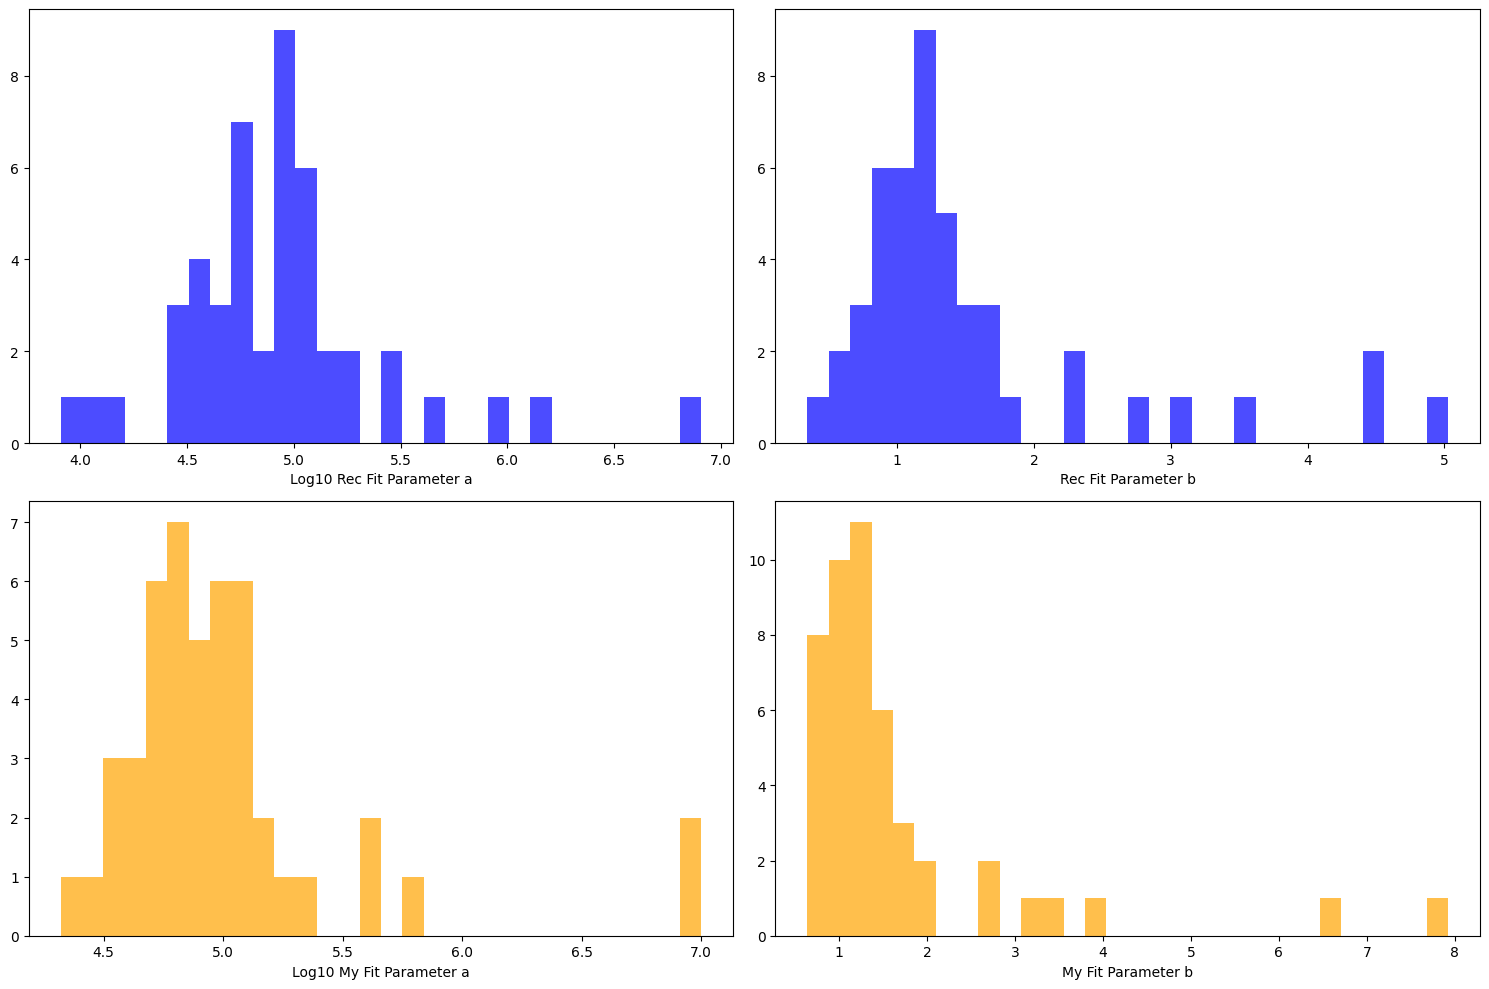

In [131]:
# Histograms of the List of Params

list_of_params_rec = np.array(list_of_params_rec)
list_of_params_myy = np.array(list_of_params_myy)

fig,ax = plt.subplots(2,2, figsize = [15,10])

ax[0,0].hist(np.log10(list_of_params_rec[:,0]), bins=30, color='blue', alpha=0.7)
ax[0,0].set_xlabel('Log10 Rec Fit Parameter a')
ax[0,1].hist(list_of_params_rec[:,1], bins=30, color='blue', alpha=0.7)
ax[0,1].set_xlabel('Rec Fit Parameter b')

ax[1,0].hist(np.log10(list_of_params_myy[:,0]), bins=30, color='orange', alpha=0.7)
ax[1,0].set_xlabel('Log10 My Fit Parameter a')
ax[1,1].hist(list_of_params_myy[:,1], bins=30, color='orange', alpha=0.7)
ax[1,1].set_xlabel('My Fit Parameter b')
plt.tight_layout()